In [ ]:
!pip install lasio

In [ ]:
import lasio
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
las_names = []
curves = []
lat = []
long = []
for file in os.listdir('/content/drive/MyDrive/log/'):
    if file.endswith(".las"):
        las_names.append('/content/drive/MyDrive/log/'+file)
        las = lasio.read('/content/drive/MyDrive/log/'+file)
        lat.append(las.well['SLAT'].value)
        long.append(las.well['SLON'].value)
        data = las.df()
        curves.append(list(data.columns))

#file_curves = dict(zip(las_names,curves))
    
# print the lists
#for l in range(len(las_names)):
#    print(las_names[l], ' ', lat[l],' ', long[l], ' ', curves[l])

In [ ]:
arr1 = np.array(lat).reshape(-1,1)
arr2 = np.array(long).reshape(-1,1)
X = np.concatenate([arr1,arr2], axis=1)  

In [ ]:
from sklearn.cluster import KMeans
model = KMeans(n_clusters=2)
model.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [ ]:
model.cluster_centers_

array([[5.80127095, 3.52103194],
       [2.27100945, 7.48227453]])

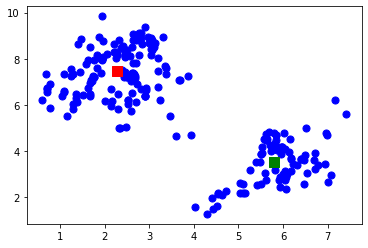

In [ ]:
plt.scatter(X[:,0], X[:,1], s =50, c='b')
plt.scatter(5.80127095, 3.52103194, s=100, c='g', marker='s')
plt.scatter(2.27100945, 7.48227453, s=100, c='r', marker='s')
plt.show()

In [ ]:
result = model.predict(X)
file_curves = dict(zip(las_names,zip( lat, long,result, curves)))

In [ ]:
print(file_curves)

{'/content/drive/MyDrive/log/0e121cce5c23_TGS.las': (6.0042871122626025, 2.9875127274344067, 0, ['AT10', 'AT20', 'AT30', 'AT60', 'AT90', 'CALD', 'CALI', 'CALI_1', 'CALI_2', 'CGR', 'DPHI_LS', 'DPHZ_LS', 'DRHO', 'DTCO', 'DTSM', 'ECGR', 'ECGRR', 'GR', 'GR_1', 'GRD', 'GRR', 'HCAL', 'HCAL_1', 'HCAL_2', 'HCALD', 'HDRA', 'PEF', 'PEFZ', 'RHOB', 'RHOZ', 'SPHI_LS', 'SPR', 'TBIT20', 'TBIT30', 'TBIT60', 'TBIT90', 'TEN', 'TEND', 'TENR', 'TENS', 'TNPH_LS']), '/content/drive/MyDrive/log/07bda346ac4d_TGS.las': (1.7417209862131067, 7.225960631755015, 1, ['RXOZ', 'HCALR', 'HLLD', 'HLLS', 'GRD', 'TNPH_LS', 'RHOZ', 'HDRA', 'PEFZ', 'DPHZ_LS', 'DTCO', 'DTRP', 'DTRS', 'DTSM']), '/content/drive/MyDrive/log/02571837c35f_TGS.las': (2.2998730455597993, 5.807630427682, 1, ['GRD', 'TNPH_LS', 'PEFZ', 'HDRA', 'CALD', 'DPHZ_LS', 'AO30', 'GRR', 'CALR', 'SPR', 'AT30', 'AT90', 'AT10', 'DTCO', 'DTSM']), '/content/drive/MyDrive/log/09a9e11b83f4_TGS.las': (1.4511292693435998, 7.402666333495006, 1, ['DPHZ_LS', 'DTCO', 'DTSM

In [ ]:
def rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    rolled = np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)
    return rolled

In [ ]:
def despike(curve, curve_sm, max_clip): 
    spikes = np.where(curve - curve_sm > max_clip)[0]
    spukes = np.where(curve_sm - curve > max_clip)[0]
    out = np.copy(curve)
    out[spikes] = curve_sm[spikes] + max_clip  # Clip at the max allowed diff
    out[spukes] = curve_sm[spukes] - max_clip  # Clip at the min allowed diff
    return out

In [ ]:
from scipy import signal
traindat = []
trainlbl = []

eval_logs = []
eval_DTSM = []

# Can change type of log inputs and output
basic_curve_set = ['GR','RHOB','NPHI','DTCO','DTSM']
DTSM1 = {}

counter2=0
for filename, curve in file_curves.items():
    count2=0
    for mnem in basic_curve_set:
        if mnem in curve[3]:
            count2+=1
            
    if count2==5:
        counter2+=1
        DTSM1[filename] = curve[3]
        
counter2=0
for filename, curves in DTSM1.items():
    print(filename, ' - ', curves)
    counter2+=1
print('\nNumber of wells that have GR, RHOB, NPHI, DTCO, DTSM is:',counter2)

count3=0
for filename in DTSM1.items(): # Run through all the training logs
 
    las = lasio.read(filename[0])
    data = las.df()
    GR_mask = data['GR'].notnull().values
    GR_mask_pos = data['GR']>=0
    DENS_mask = data['RHOB'].notnull().values
    DENS_mask_pos = data['RHOB']>=0
    NEUT_mask = data['NPHI'].notnull().values
    NEUT_mask_pos = data['NPHI']>=0
    DTC_mask = data['DTCO'].notnull().values
    DTC_mask_pos = data['DTCO']>=0
    DTS_mask = data['DTSM'].notnull().values
    DTS_mask_pos = data['DTSM']>=0
    
    mask = [all(tup) for tup in zip(GR_mask, DENS_mask, DTC_mask, DTS_mask, NEUT_mask, DTS_mask_pos, NEUT_mask_pos, GR_mask_pos, DENS_mask_pos, DTC_mask_pos)]
    GR = data['GR'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    GR = signal.medfilt(GR,11)
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    gr_sm = np.median(rolling_window(GR,window), -1)
    gr_sm = np.pad(gr_sm, int(window/2), mode='edge')
    GR = despike(GR, gr_sm, max_clip = 10)
    GR = np.reshape(np.array(GR),(GR.shape[0],1))
    DENS = data['RHOB'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    DENS = signal.medfilt(DENS,11)
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    rho_sm = np.median(rolling_window(DENS,window), -1)
    rho_sm = np.pad(rho_sm, int(window/2), mode='edge')
    DENS = despike(DENS, rho_sm, max_clip = 0.1)

    DENS = np.reshape(np.array(DENS),(DENS.shape[0],1))
    NEUT = data['NPHI'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    NEUT = signal.medfilt(NEUT,11)
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    neut_sm = np.median(rolling_window(NEUT,window), -1)
    neut_sm = np.pad(neut_sm, int(window/2), mode='edge')
    NEUT = despike(NEUT, neut_sm, max_clip = 0.1)
    NEUT = np.reshape(np.array(NEUT),(NEUT.shape[0],1))
    DT = data['DTCO'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    dt_sm = np.median(rolling_window(DT,window), -1)
    dt_sm = np.pad(dt_sm, int(window/2), mode='edge')
    DT = despike(DT, dt_sm, max_clip = 10)
    DT = np.reshape(np.array(DT),(DT.shape[0],1))

    DTS = data['DTSM'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    #window = 13 # the length of filter is 13 samples or ~ 2 metres
    #dts_sm = np.median(rolling_window(DTS,window), -1)
    #dts_sm = np.pad(dts_sm, int(window/2), mode='edge')
    #DTS = despike(DTS, dts_sm, max_clip = 10)
    DTS = np.reshape(np.array(DTS),(DTS.shape[0],1))
    
    dat=np.concatenate((GR,DENS,NEUT,DT),axis=1) # Every example will have shape (GR.shape[0],3)
    
    arr = np.zeros((len(dat),3),dtype=float)
    for i in range(len(dat)):
        arr[i,:]=file_curves[filename[0]][0:3]

    dat=np.concatenate((dat,arr),axis=1)
    
    for i in range(len(dat)):
        eval_logs.append(dat[i,:])
        eval_DTSM.append(DTS[i,:])    


/content/drive/MyDrive/log/9f87f83d222c_TGS.las  -  ['GRS', 'DT', 'DTL', 'DTSM', 'DTCO', 'GRD', 'NPHI', 'LLD', 'LLS', 'MSFL', 'GR', 'SNP', 'CALD', 'DPHI', 'DRHO', 'PEF', 'RHOB']

Number of wells that have GR, RHOB, NPHI, DTCO, DTSM is: 1


In [ ]:
np.array(eval_logs).shape

(1181, 7)

In [ ]:
# Can change type of log inputs and output
basic_curve_set = ['GRR','RHOB','NPHI','DTCO','DTSM']
DTSM2 = {}

counter2=0
for filename, curve in file_curves.items():
    count2=0
    for mnem in basic_curve_set:
        if mnem in curve[3]:
            count2+=1
            
    if count2==5 and 'GR' not in curves[3]:
        counter2+=1
        DTSM2[filename] = curve[3]
        
counter2=0
for filename, curves in DTSM2.items():
    print(filename, ' - ', curves)
    counter2+=1
print('\nNumber of wells that have GRR, RHOB, NPHI, DTCO, DTSM is:',counter2)

count3=0
for filename in DTSM2.items(): # Run through all the training logs
 
    las = lasio.read(filename[0])
    data = las.df()
    GR_mask = data['GRR'].notnull().values
    GR_mask_pos = data['GRR']>=0
    DENS_mask = data['RHOB'].notnull().values
    DENS_mask_pos = data['RHOB']>=0
    NEUT_mask = data['NPHI'].notnull().values
    NEUT_mask_pos = data['NPHI']>=0
    DTC_mask = data['DTCO'].notnull().values
    DTC_mask_pos = data['DTCO']>=0
    DTS_mask = data['DTSM'].notnull().values
    DTS_mask_pos = data['DTSM']>=0
    
    mask = [all(tup) for tup in zip(GR_mask, DENS_mask, DTC_mask, DTS_mask, NEUT_mask, DTS_mask_pos, NEUT_mask_pos, GR_mask_pos, DENS_mask_pos, DTC_mask_pos)]
    try:
        GR = data['GRR'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
        GR = signal.medfilt(GR,11)
        window = 13 # the length of filter is 13 samples or ~ 2 metres
        gr_sm = np.median(rolling_window(GR,window), -1)
        gr_sm = np.pad(gr_sm, int(window/2), mode='edge')
        GR = despike(GR, gr_sm, max_clip = 10)

        GR = np.reshape(np.array(GR),(GR.shape[0],1))
        DENS = data['RHOB'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
        DENS = signal.medfilt(DENS,11)
        window = 13 # the length of filter is 13 samples or ~ 2 metres
        rho_sm = np.median(rolling_window(DENS,window), -1)
        rho_sm = np.pad(rho_sm, int(window/2), mode='edge')
        DENS = despike(DENS, rho_sm, max_clip = 0.1)

        DENS = np.reshape(np.array(DENS),(DENS.shape[0],1))
        NEUT = data['NPHI'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
        NEUT = signal.medfilt(NEUT,11)
        window = 13 # the length of filter is 13 samples or ~ 2 metres
        neut_sm = np.median(rolling_window(NEUT,window), -1)
        neut_sm = np.pad(neut_sm, int(window/2), mode='edge')
        NEUT = despike(NEUT, neut_sm, max_clip = 0.1)
        NEUT = np.reshape(np.array(NEUT),(NEUT.shape[0],1))


        DT = data['DTCO'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
        window = 13 # the length of filter is 13 samples or ~ 2 metres
        dt_sm = np.median(rolling_window(DT,window), -1)
        dt_sm = np.pad(dt_sm, int(window/2), mode='edge')
        DT = despike(DT, dt_sm, max_clip = 10)
        DT = np.reshape(np.array(DT),(DT.shape[0],1))

        DTS = data['DTSM'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
        window = 13 # the length of filter is 13 samples or ~ 2 metres
        dts_sm = np.median(rolling_window(DTS,window), -1)
        dts_sm = np.pad(dts_sm, int(window/2), mode='edge')
        DTS = despike(DTS, dts_sm, max_clip = 10)
        DTS = np.reshape(np.array(DTS),(DTS.shape[0],1))

        if np.concatenate((GR,DENS,NEUT,DT),axis=1).shape[0]!=0:
            dat=np.concatenate((GR,DENS,NEUT,DT),axis=1) # Every example will have shape (GR.shape[0],3)
        
        
            
        arr = np.zeros((len(dat),3),dtype=float)
        for i in range(len(dat)):
            arr[i,:]=file_curves[filename[0]][0:3]

        dat=np.concatenate((dat,arr),axis=1)
    
#    if count3==0:
#        minl=dat.shape[0]
#    if count3!=0:
#        minl=min(dat.shape[0],minl)
        
#    count3+=1

#    length=int(len(dat)/43)
#    for i in range(length):
#        eval_logs.append(dat[i*43:(i+1)*43,:])
#        eval_DTSM.append(DTS[i*43:(i+1)*43,:])
    
    
        for i in range(len(dat)):
            traindat.append(dat[i,:])
            trainlbl.append(DTS[i,:])   
            
            
    except:
        continue
    
#print('Minimum sequence length:',minl)
#print(count3)

/content/drive/MyDrive/log/0a65a72dd23f_TGS.las  -  ['SPR', 'GRR', 'SFLU', 'ILD', 'ILM', 'CILD', 'ILD1', 'SFLA', 'CALD', 'PEF', 'RHOB', 'DRHO', 'NPHI', 'DPHI', 'DTCO', 'DTSM']
/content/drive/MyDrive/log/1a000e7f474b_TGS.las  -  ['SPR', 'GRR', 'AT10', 'AT90', 'AT30', 'DTCO', 'DTSM', 'CALD', 'DPHI', 'NPHI', 'RHOB', 'DRHO', 'GRD']
/content/drive/MyDrive/log/27eedabb7f1b_TGS.las  -  ['CILD', 'TEND', 'RHOB', 'PEF', 'NPHI', 'DRHO', 'TENR', 'ILM', 'DTCO', 'DTSM', 'TENS', 'CALD', 'SFLU', 'SPR', 'ILD', 'GRR']
/content/drive/MyDrive/log/1cf78b7ca1cc_TGS.las  -  ['SFLU', 'ILD', 'ILM', 'GRR', 'SPR', 'RHOB', 'PEF', 'CALD', 'DRHO', 'DPHI', 'NPHI', 'DTCO', 'DTSM']
/content/drive/MyDrive/log/3ae75d54eac9_TGS.las  -  ['DPHI', 'NPHI', 'DRHO', 'CALD', 'RHOB', 'PEF', 'GRR', 'ILD', 'SPR', 'SFLU', 'ILM', 'DTCO', 'DTSM']
/content/drive/MyDrive/log/389595b964b6_TGS.las  -  ['SPR', 'GRR', 'TENR', 'AT10', 'AT30', 'AT90', 'NPHI', 'DRHO', 'PEF', 'TEND', 'CALD', 'RHOB', 'DTCO', 'DTSM', 'TENS', 'AT20', 'AT60']
/con

In [ ]:
np.array(traindat).shape

(107470, 7)

In [ ]:
# Can change type of log inputs and output
basic_curve_set = ['GRS','RHOB','NPHI','DTCO','DTSM']
DTSM3 = {}

counter2=0
for filename, curve in file_curves.items():
    count2=0
    for mnem in basic_curve_set:
        if mnem in curve[3]:
            count2+=1
            
    if count2==5 and 'GR' not in curves[3] and 'GRR' not in curves[3]:
        counter2+=1
        DTSM3[filename] = curve[3]
        
counter2=0
for filename, curves in DTSM3.items():
    print(filename, ' - ', curves)
    counter2+=1
print('\nNumber of wells that have GRS, RHOB, NPHI, DTCO, DTSM is:',counter2)

count3=0

count3=0
for filename in DTSM3.items(): # Run through all the training logs
 
    las = lasio.read(filename[0])
    data = las.df()
    GR_mask = data['GRS'].notnull().values
    GR_mask_pos = data['GRS']>=0
    DENS_mask = data['RHOB'].notnull().values
    DENS_mask_pos = data['RHOB']>=0
    NEUT_mask = data['NPHI'].notnull().values
    NEUT_mask_pos = data['NPHI']>=0
    DTC_mask = data['DTCO'].notnull().values
    DTC_mask_pos = data['DTCO']>=0
    DTS_mask = data['DTSM'].notnull().values
    DTS_mask_pos = data['DTSM']>=0
    
    mask = [all(tup) for tup in zip(GR_mask, DENS_mask, DTC_mask, DTS_mask, NEUT_mask, DTS_mask_pos, NEUT_mask_pos, GR_mask_pos, DENS_mask_pos, DTC_mask_pos)]
    GR = data['GRS'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    GR = signal.medfilt(GR,11)
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    gr_sm = np.median(rolling_window(GR,window), -1)
    gr_sm = np.pad(gr_sm, int(window/2), mode='edge')
    GR = despike(GR, gr_sm, max_clip = 10)
    GR = np.reshape(np.array(GR),(GR.shape[0],1))
    DENS = data['RHOB'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    DENS = signal.medfilt(DENS,11)
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    rho_sm = np.median(rolling_window(DENS,window), -1)
    rho_sm = np.pad(rho_sm, int(window/2), mode='edge')
    DENS = despike(DENS, rho_sm, max_clip = 0.1)

    DENS = np.reshape(np.array(DENS),(DENS.shape[0],1))
    NEUT = data['NPHI'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    NEUT = signal.medfilt(NEUT,11)
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    neut_sm = np.median(rolling_window(NEUT,window), -1)
    neut_sm = np.pad(neut_sm, int(window/2), mode='edge')
    NEUT = despike(NEUT, neut_sm, max_clip = 0.1)
    NEUT = np.reshape(np.array(NEUT),(NEUT.shape[0],1))


    DT = data['DTCO'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    dt_sm = np.median(rolling_window(DT,window), -1)
    dt_sm = np.pad(dt_sm, int(window/2), mode='edge')
    DT = despike(DT, dt_sm, max_clip = 10)
    DT = np.reshape(np.array(DT),(DT.shape[0],1))

    DTS = data['DTSM'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    dts_sm = np.median(rolling_window(DTS,window), -1)
    dts_sm = np.pad(dts_sm, int(window/2), mode='edge')
    DTS = despike(DTS, dts_sm, max_clip = 10)
    DTS = np.reshape(np.array(DTS),(DTS.shape[0],1))
    
    if np.concatenate((GR,DENS,NEUT,DT),axis=1).shape[0]!=0:
        dat=np.concatenate((GR,DENS,NEUT,DT),axis=1) # Every example will have shape (GR.shape[0],3)
      
        if count3==0:
            minl=dat.shape[0]
        if count3!=0:
            minl=min(dat.shape[0],minl)
          
        count3+=1
        arr = np.zeros((len(dat),3),dtype=float)
        for i in range(len(dat)):
            arr[i,:]=file_curves[filename[0]][0:3]

        dat=np.concatenate((dat,arr),axis=1)
    
    
    for i in range(len(dat)):
        traindat.append(dat[i,:])
        trainlbl.append(DTS[i,:]) 
        
    #length=int(len(dat)/43)
    #for i in range(length):
        #traindat.append(dat[i*43:(i+1)*43,:])
        #trainlbl.append(DTS[i*43:(i+1)*43,:])
    
print('Minimum sequence length:',minl)
print(count3)

/content/drive/MyDrive/log/3e09ee2f5add_TGS.las  -  ['SPR', 'CILD', 'ILM', 'CALI', 'DRHO', 'PEF', 'RHOB', 'DPHI', 'NPHI', 'GRS', 'DTM', 'DT', 'DTCO', 'DTSM', 'GRD', 'CALD', 'ZCOR', 'PE', 'ZDEN', 'CNC', 'PORZ', 'ILD', 'SFLU']
/content/drive/MyDrive/log/1f439d39052a_TGS.las  -  ['RHOB', 'CALD', 'DRHO', 'DPHI', 'NPHI', 'GRS', 'DTCO', 'DTSM']
/content/drive/MyDrive/log/4503ff73396f_TGS.las  -  ['GRR', 'ILD', 'ILM', 'SFLU', 'SPR', 'CALD', 'PEF', 'RHOB', 'SGR', 'TEND', 'DRHO', 'CGR', 'DPHI', 'NPHI', 'TENS', 'DTSM', 'GRS', 'DTCO', 'SPHI']
/content/drive/MyDrive/log/8fd93f7017dc_TGS.las  -  ['SPR', 'ILD', 'ILM', 'SFLU', 'NPHI', 'CALD', 'DRHO', 'GRS', 'DTCO', 'DTSM', 'RHOB', 'DPHI']
/content/drive/MyDrive/log/8bc6a83e83c2_TGS.las  -  ['CALD', 'DPHI', 'DRHO', 'DTCO', 'DTSM', 'GRS', 'LLD', 'LLS', 'MSFL', 'NPHI', 'PEF', 'RHOB', 'SGR']
/content/drive/MyDrive/log/9f87f83d222c_TGS.las  -  ['GRS', 'DT', 'DTL', 'DTSM', 'DTCO', 'GRD', 'NPHI', 'LLD', 'LLS', 'MSFL', 'GR', 'SNP', 'CALD', 'DPHI', 'DRHO', 'P

In [ ]:
np.array(traindat).shape

(155954, 7)

In [ ]:
# Can change type of log inputs and output
basic_curve_set = ['GRD','RHOB','NPHI','DTCO','DTSM']
DTSM34 = {}

counter2=0
for filename, curve in file_curves.items():
    count2=0
    for mnem in basic_curve_set:
        if mnem in curve[3]:
            count2+=1
            
    if count2==5 and 'GR' not in curve[3] and 'GRR' not in curves[3] and 'GRS' not in curves[3]:
        counter2+=1
        DTSM34[filename] = curve[3]
        
counter2=0
for filename, curves in DTSM34.items():
    print(filename, ' - ', curves)
    counter2+=1
print('\nNumber of wells that have GRD, RHOB, NPHI, DTCO, DTSM is:',counter2)

count3=0
for filename in DTSM34.items(): # Run through all the training logs
 
    las = lasio.read(filename[0])
    data = las.df()
    GR_mask = data['GRD'].notnull().values
    GR_mask_pos = data['GRD']>=0
    DENS_mask = data['RHOB'].notnull().values
    DENS_mask_pos = data['RHOB']>=0
    NEUT_mask = data['NPHI'].notnull().values
    NEUT_mask_pos = data['NPHI']>=0
    DTC_mask = data['DTCO'].notnull().values
    DTC_mask_pos = data['DTCO']>=0
    DTS_mask = data['DTSM'].notnull().values
    DTS_mask_pos = data['DTSM']>=0
    
    mask = [all(tup) for tup in zip(GR_mask, DENS_mask, DTC_mask, DTS_mask, NEUT_mask, DTS_mask_pos, NEUT_mask_pos, GR_mask_pos, DENS_mask_pos, DTC_mask_pos)]
    GR = data['GRD'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    GR = signal.medfilt(GR,11)
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    gr_sm = np.median(rolling_window(GR,window), -1)
    gr_sm = np.pad(gr_sm, int(window/2), mode='edge')
    GR = despike(GR, gr_sm, max_clip = 10)
    GR = np.reshape(np.array(GR),(GR.shape[0],1))
    DENS = data['RHOB'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    DENS = signal.medfilt(DENS,11)
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    rho_sm = np.median(rolling_window(DENS,window), -1)
    rho_sm = np.pad(rho_sm, int(window/2), mode='edge')
    DENS = despike(DENS, rho_sm, max_clip = 0.1)

    DENS = np.reshape(np.array(DENS),(DENS.shape[0],1))
    NEUT = data['NPHI'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    NEUT = signal.medfilt(NEUT,11)
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    neut_sm = np.median(rolling_window(NEUT,window), -1)
    neut_sm = np.pad(neut_sm, int(window/2), mode='edge')
    NEUT = despike(NEUT, neut_sm, max_clip = 0.1)
    NEUT = np.reshape(np.array(NEUT),(NEUT.shape[0],1))


    DT = data['DTCO'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    dt_sm = np.median(rolling_window(DT,window), -1)
    dt_sm = np.pad(dt_sm, int(window/2), mode='edge')
    DT = despike(DT, dt_sm, max_clip = 10)
    DT = np.reshape(np.array(DT),(DT.shape[0],1))

    DTS = data['DTSM'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    dts_sm = np.median(rolling_window(DTS,window), -1)
    dts_sm = np.pad(dts_sm, int(window/2), mode='edge')
    DTS = despike(DTS, dts_sm, max_clip = 10)
    DTS = np.reshape(np.array(DTS),(DTS.shape[0],1))
    
    if np.concatenate((GR,DENS,NEUT,DT),axis=1).shape[0]!=0:
        dat=np.concatenate((GR,DENS,NEUT,DT),axis=1) # Every example will have shape (GR.shape[0],3)
      
        if count3==0:
            minl=dat.shape[0]
        if count3!=0:
            minl=min(dat.shape[0],minl)
          
        count3+=1
        
        arr = np.zeros((len(dat),3),dtype=float)
        for i in range(len(dat)):
            arr[i,:]=file_curves[filename[0]][0:3]

        dat=np.concatenate((dat,arr),axis=1)
    
    
    for i in range(len(dat)):
        traindat.append(dat[i,:])
        trainlbl.append(DTS[i,:]) 
        
    #length=int(len(dat)/43)
    #for i in range(length):
        #traindat.append(dat[i*43:(i+1)*43,:])
        #trainlbl.append(DTS[i*43:(i+1)*43,:])
    
print('Minimum sequence length:',minl)
print(count3)

/content/drive/MyDrive/log/1a000e7f474b_TGS.las  -  ['SPR', 'GRR', 'AT10', 'AT90', 'AT30', 'DTCO', 'DTSM', 'CALD', 'DPHI', 'NPHI', 'RHOB', 'DRHO', 'GRD']
/content/drive/MyDrive/log/3e09ee2f5add_TGS.las  -  ['SPR', 'CILD', 'ILM', 'CALI', 'DRHO', 'PEF', 'RHOB', 'DPHI', 'NPHI', 'GRS', 'DTM', 'DT', 'DTCO', 'DTSM', 'GRD', 'CALD', 'ZCOR', 'PE', 'ZDEN', 'CNC', 'PORZ', 'ILD', 'SFLU']
/content/drive/MyDrive/log/48b950eab493_TGS.las  -  ['LLD', 'LLS', 'MSFL', 'GRD', 'CALD', 'PEF', 'DPHI', 'NPHI', 'DRHO', 'RHOB', 'DT', 'DTL', 'DTCO', 'DTSM']
/content/drive/MyDrive/log/45f3c132a607_TGS.las  -  ['RHOB', 'GRD', 'NPHI', 'PEF', 'DPHI', 'DRHO', 'AT10', 'AT30', 'AT90', 'CALR', 'SPR', 'DT', 'DTL', 'DTCO', 'DTSM']
/content/drive/MyDrive/log/6882508038e6_TGS.las  -  ['GRD', 'NPHI', 'DPHI', 'RHOB', 'DRHO', 'CALD', 'GRR', 'ILD', 'ILM', 'SFLU', 'SPR', 'DTCO', 'DTSM']
/content/drive/MyDrive/log/8dd418b39f5d_TGS.las  -  ['CALD', 'RHOB', 'DRHO', 'GRD', 'NPHI', 'DPHI', 'DTSM', 'DTCO', 'SPR', 'SFL', 'ILD', 'ILM', 

In [ ]:
np.array(traindat).shape

(177699, 7)

In [ ]:
# Can change type of log inputs and output
basic_curve_set = ['GRD','RHOB','NPHI_LS','DTCO','DTSM']
DTSM4 = {}

counter2=0
for filename, curve in file_curves.items():
    count2=0
    for mnem in basic_curve_set:
        if mnem in curve[3]:
            count2+=1
            
    if count2==5 and 'GR' not in curves[3] and 'GRR' not in curves[3] and 'GRS' not in curves[3]:
        counter2+=1
        DTSM4[filename] = curve[3]
        
counter2=0
for filename, curves in DTSM4.items():
    print(filename, ' - ', curves)
    counter2+=1
print('\nNumber of wells that have GRD, RHOB, NPHI_LS, DTCO, DTSM is:',counter2)

count3=0
for filename in DTSM4.items(): # Run through all the training logs
 
    las = lasio.read(filename[0])
    data = las.df()
    GR_mask = data['GRD'].notnull().values
    GR_mask_pos = data['GRD']>=0
    DENS_mask = data['RHOB'].notnull().values
    DENS_mask_pos = data['RHOB']>=0
    NEUT_mask = data['NPHI_LS'].notnull().values
    NEUT_mask_pos = data['NPHI_LS']>=0
    DTC_mask = data['DTCO'].notnull().values
    DTC_mask_pos = data['DTCO']>=0
    DTS_mask = data['DTSM'].notnull().values
    DTS_mask_pos = data['DTSM']>=0
    
    mask = [all(tup) for tup in zip(GR_mask, DENS_mask, DTC_mask, DTS_mask, NEUT_mask, DTS_mask_pos, NEUT_mask_pos, GR_mask_pos, DENS_mask_pos, DTC_mask_pos)]
    GR = data['GRD'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    GR = signal.medfilt(GR,11)
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    gr_sm = np.median(rolling_window(GR,window), -1)
    gr_sm = np.pad(gr_sm, int(window/2), mode='edge')
    GR = despike(GR, gr_sm, max_clip = 10)

    GR = np.reshape(np.array(GR),(GR.shape[0],1))
    DENS = data['RHOB'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    DENS = signal.medfilt(DENS,11)
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    rho_sm = np.median(rolling_window(DENS,window), -1)
    rho_sm = np.pad(rho_sm, int(window/2), mode='edge')
    DENS = despike(DENS, rho_sm, max_clip = 0.1)

    DENS = np.reshape(np.array(DENS),(DENS.shape[0],1))
    NEUT = data['NPHI_LS'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    NEUT = signal.medfilt(NEUT,11)
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    neut_sm = np.median(rolling_window(NEUT,window), -1)
    neut_sm = np.pad(neut_sm, int(window/2), mode='edge')
    NEUT = despike(NEUT, neut_sm, max_clip = 0.1)
    NEUT = np.reshape(np.array(NEUT),(NEUT.shape[0],1))


    DT = data['DTCO'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    dt_sm = np.median(rolling_window(DT,window), -1)
    dt_sm = np.pad(dt_sm, int(window/2), mode='edge')
    DT = despike(DT, dt_sm, max_clip = 10)
    DT = np.reshape(np.array(DT),(DT.shape[0],1))

    DTS = data['DTSM'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    dts_sm = np.median(rolling_window(DTS,window), -1)
    dts_sm = np.pad(dts_sm, int(window/2), mode='edge')
    DTS = despike(DTS, dts_sm, max_clip = 10)
    DTS = np.reshape(np.array(DTS),(DTS.shape[0],1))
    
    if np.concatenate((GR,DENS,NEUT,DT),axis=1).shape[0]!=0:
        dat=np.concatenate((GR,DENS,NEUT,DT),axis=1) # Every example will have shape (GR.shape[0],3)

        if count3==0:
            minl=dat.shape[0]
        if count3!=0:
            minl=min(dat.shape[0],minl)

        count3+=1
        arr = np.zeros((len(dat),3),dtype=float)
        for i in range(len(dat)):
            arr[i,:]=file_curves[filename[0]][0:3]

        dat=np.concatenate((dat,arr),axis=1)
    
    
    for i in range(len(dat)):
        traindat.append(dat[i,:])
        trainlbl.append(DTS[i,:]) 
        
        
#    length=int(len(dat)/43)
#    for i in range(length):
#        traindat.append(dat[i*43:(i+1)*43,:])
#        trainlbl.append(DTS[i*43:(i+1)*43,:])
    
print('Minimum sequence length:',minl)
print(count3)

/content/drive/MyDrive/log/1f901b2ab8a5_TGS.las  -  ['CALD', 'CALS', 'CILD', 'DPHI_LS', 'DRHO', 'DT', 'DTCO', 'DTSM', 'GRD', 'GRR', 'GRS', 'IDBC', 'IDPH', 'ILD', 'ILM', 'IMBC', 'IMPH', 'LLD', 'LLS', 'NPHI_LS', 'PEF', 'RHOB', 'RILD', 'SFLA', 'SFLU', 'SPHI_LS', 'SPR', 'TEND', 'TENR', 'TENS']
/content/drive/MyDrive/log/3d6dde594223_TGS.las  -  ['DT', 'DTCO', 'DTSM', 'GRD', 'NPHI_LS', 'DPHI_LS', 'CALD', 'DRHO', 'RHOB']
/content/drive/MyDrive/log/559e559909d1_TGS.las  -  ['CALS', 'DT', 'DTCO', 'DTL', 'DTLF', 'DTLN', 'DTSM', 'DPHI_LS', 'DRHO', 'GRD', 'NPHI_LS', 'PEF', 'RHOB']
/content/drive/MyDrive/log/8c261ddf84f0_TGS.las  -  ['RHOB', 'GRD', 'NPHI_LS', 'CALD', 'PEF', 'DPHI_LS', 'DRHO', 'LLD', 'LLS', 'MSFL', 'SPR', 'DTCO', 'DTSM']
/content/drive/MyDrive/log/d09b501c79b2_TGS.las  -  ['CALD', 'DPHI_LS', 'DRHO', 'DTCO', 'DTSM', 'GR', 'GRD', 'GRR', 'GRS', 'ILD', 'ILM', 'NPHI_LS', 'PEF', 'RHOB', 'SFLU', 'SPR']
/content/drive/MyDrive/log/e2cffc9d263b_TGS.las  -  ['CAL1R', 'CALD', 'CALSR', 'DPHI_LS

In [ ]:
np.array(traindat).shape

(219635, 7)

In [ ]:
# Can change type of log inputs and output
basic_curve_set = ['GR','RHOB','NPHI_LS','DTCO','DTSM']
DTSM5 = {}

counter2=0
for filename, curve in file_curves.items():
    count2=0
    for mnem in basic_curve_set:
        if mnem in curve[3]:
            count2+=1
            
    if count2==5 and 'NPHI' not in curves[3]:
        counter2+=1
        DTSM5[filename] = curve[3]
        
counter2=0
for filename, curves in DTSM5.items():
    print(filename, ' - ', curves)
    counter2+=1
print('\nNumber of wells that have GR, RHOB, NPHI_LS, DTCO, DTSM is:',counter2)

count3=0
for filename in DTSM5.items(): # Run through all the training logs
 
    las = lasio.read(filename[0])
    data = las.df()
    GR_mask = data['GR'].notnull().values
    GR_mask_pos = data['GR']>=0
    DENS_mask = data['RHOB'].notnull().values
    DENS_mask_pos = data['RHOB']>=0
    NEUT_mask = data['NPHI_LS'].notnull().values
    NEUT_mask_pos = data['NPHI_LS']>=0
    DTC_mask = data['DTCO'].notnull().values
    DTC_mask_pos = data['DTCO']>=0
    DTS_mask = data['DTSM'].notnull().values
    DTS_mask_pos = data['DTSM']>=0
    
    mask = [all(tup) for tup in zip(GR_mask, DENS_mask, DTC_mask, DTS_mask, NEUT_mask, DTS_mask_pos, NEUT_mask_pos, GR_mask_pos, DENS_mask_pos, DTC_mask_pos)]
    GR = data['GR'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    GR = signal.medfilt(GR,11)
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    gr_sm = np.median(rolling_window(GR,window), -1)
    gr_sm = np.pad(gr_sm, int(window/2), mode='edge')
    GR = despike(GR, gr_sm, max_clip = 10)

    GR = np.reshape(np.array(GR),(GR.shape[0],1))
    DENS = data['RHOB'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    DENS = signal.medfilt(DENS,11)
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    rho_sm = np.median(rolling_window(DENS,window), -1)
    rho_sm = np.pad(rho_sm, int(window/2), mode='edge')
    DENS = despike(DENS, rho_sm, max_clip = 0.1)

    DENS = np.reshape(np.array(DENS),(DENS.shape[0],1))
    NEUT = data['NPHI_LS'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    NEUT = signal.medfilt(NEUT,11)
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    neut_sm = np.median(rolling_window(NEUT,window), -1)
    neut_sm = np.pad(neut_sm, int(window/2), mode='edge')
    NEUT = despike(NEUT, neut_sm, max_clip = 0.1)
    NEUT = np.reshape(np.array(NEUT),(NEUT.shape[0],1))


    DT = data['DTCO'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    dt_sm = np.median(rolling_window(DT,window), -1)
    dt_sm = np.pad(dt_sm, int(window/2), mode='edge')
    DT = despike(DT, dt_sm, max_clip = 10)
    DT = np.reshape(np.array(DT),(DT.shape[0],1))

    DTS = data['DTSM'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    dts_sm = np.median(rolling_window(DTS,window), -1)
    dts_sm = np.pad(dts_sm, int(window/2), mode='edge')
    DTS = despike(DTS, dts_sm, max_clip = 10)
    DTS = np.reshape(np.array(DTS),(DTS.shape[0],1))
    
    if np.concatenate((GR,DENS,NEUT,DT),axis=1).shape[0]!=0:
        dat=np.concatenate((GR,DENS,NEUT,DT),axis=1) # Every example will have shape (GR.shape[0],3)

        if count3==0:
            minl=dat.shape[0]
        if count3!=0:
            minl=min(dat.shape[0],minl)

        count3+=1
        
        arr = np.zeros((len(dat),3),dtype=float)
        for i in range(len(dat)):
            arr[i,:]=file_curves[filename[0]][0:3]

        dat=np.concatenate((dat,arr),axis=1)
    
    
    for i in range(len(dat)):
        traindat.append(dat[i,:])
        trainlbl.append(DTS[i,:]) 
        
        
#    length=int(len(dat)/43)
#    for i in range(length):
#        traindat.append(dat[i*43:(i+1)*43,:])
#        trainlbl.append(DTS[i*43:(i+1)*43,:])
    
print('Minimum sequence length:',minl)
print(count3)

/content/drive/MyDrive/log/d09b501c79b2_TGS.las  -  ['CALD', 'DPHI_LS', 'DRHO', 'DTCO', 'DTSM', 'GR', 'GRD', 'GRR', 'GRS', 'ILD', 'ILM', 'NPHI_LS', 'PEF', 'RHOB', 'SFLU', 'SPR']
/content/drive/MyDrive/log/cbe115c74a89_TGS.las  -  ['GR', 'GRD', 'NPHI_LS', 'DPHI_LS', 'RHOB', 'CALD', 'QRHO', 'AST10', 'AST30', 'AST90', 'SPR', 'DTCO', 'DTSM']

Number of wells that have GR, RHOB, NPHI_LS, DTCO, DTSM is: 2
Minimum sequence length: 1001
2


In [ ]:
np.array(traindat).shape

(225217, 7)

In [ ]:
# Can change type of log inputs and output
basic_curve_set = ['GRR','RHOB','NPHI_LS','DTCO','DTSM']
DTSM6 = {}

counter2=0
for filename, curve in file_curves.items():
    count2=0
    for mnem in basic_curve_set:
        if mnem in curve[3]:
            count2+=1
            
    if count2==5 and 'NPHI' not in curve[3] and 'GR' not in curve[3]:
        counter2+=1
        DTSM6[filename] = curve[3]
        
counter2=0
for filename, curves in DTSM6.items():
    print(filename, ' - ', curves)
    counter2+=1
print('\nNumber of wells that have GRR, RHOB, NPHI_LS, DTCO, DTSM is:',counter2)

count3=0
for filename in DTSM6.items(): # Run through all the training logs
 
    las = lasio.read(filename[0])
    data = las.df()
    GR_mask = data['GRR'].notnull().values
    GR_mask_pos = data['GRR']>=0
    DENS_mask = data['RHOB'].notnull().values
    DENS_mask_pos = data['RHOB']>=0
    NEUT_mask = data['NPHI_LS'].notnull().values
    NEUT_mask_pos = data['NPHI_LS']>=0
    DTC_mask = data['DTCO'].notnull().values
    DTC_mask_pos = data['DTCO']>=0
    DTS_mask = data['DTSM'].notnull().values
    DTS_mask_pos = data['DTSM']>=0
    
    mask = [all(tup) for tup in zip(GR_mask, DENS_mask, DTC_mask, DTS_mask, NEUT_mask, DTS_mask_pos, NEUT_mask_pos, GR_mask_pos, DENS_mask_pos, DTC_mask_pos)]
    GR = data['GRR'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    GR = signal.medfilt(GR,11)
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    gr_sm = np.median(rolling_window(GR,window), -1)
    gr_sm = np.pad(gr_sm, int(window/2), mode='edge')
    GR = despike(GR, gr_sm, max_clip = 10)

    GR = np.reshape(np.array(GR),(GR.shape[0],1))
    DENS = data['RHOB'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    DENS = signal.medfilt(DENS,11)
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    rho_sm = np.median(rolling_window(DENS,window), -1)
    rho_sm = np.pad(rho_sm, int(window/2), mode='edge')
    DENS = despike(DENS, rho_sm, max_clip = 0.1)

    DENS = np.reshape(np.array(DENS),(DENS.shape[0],1))
    NEUT = data['NPHI_LS'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    NEUT = signal.medfilt(NEUT,11)
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    neut_sm = np.median(rolling_window(NEUT,window), -1)
    neut_sm = np.pad(neut_sm, int(window/2), mode='edge')
    NEUT = despike(NEUT, neut_sm, max_clip = 0.1)
    NEUT = np.reshape(np.array(NEUT),(NEUT.shape[0],1))


    DT = data['DTCO'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    dt_sm = np.median(rolling_window(DT,window), -1)
    dt_sm = np.pad(dt_sm, int(window/2), mode='edge')
    DT = despike(DT, dt_sm, max_clip = 10)
    DT = np.reshape(np.array(DT),(DT.shape[0],1))

    DTS = data['DTSM'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    dts_sm = np.median(rolling_window(DTS,window), -1)
    dts_sm = np.pad(dts_sm, int(window/2), mode='edge')
    DTS = despike(DTS, dts_sm, max_clip = 10)
    DTS = np.reshape(np.array(DTS),(DTS.shape[0],1))
    
    if np.concatenate((GR,DENS,NEUT,DT),axis=1).shape[0]!=0:
        dat=np.concatenate((GR,DENS,NEUT,DT),axis=1) # Every example will have shape (GR.shape[0],3)

        if count3==0:
            minl=dat.shape[0]
        if count3!=0:
            minl=min(dat.shape[0],minl)

        count3+=1

        arr = np.zeros((len(dat),3),dtype=float)
        for i in range(len(dat)):
            arr[i,:]=file_curves[filename[0]][0:3]

        dat=np.concatenate((dat,arr),axis=1)
    
    
    for i in range(len(dat)):
        traindat.append(dat[i,:])
        trainlbl.append(DTS[i,:]) 
        
        
        
#    length=int(len(dat)/43)
#    for i in range(length):
#        traindat.append(dat[i*43:(i+1)*43,:])
#        trainlbl.append(DTS[i*43:(i+1)*43,:])
    
print('Minimum sequence length:',minl)
print(count3)

/content/drive/MyDrive/log/260af024a4c2_TGS.las  -  ['DTCO', 'DTSM', 'GRR', 'ILD', 'CILD', 'SPR', 'SFLA', 'ILM', 'SFLU', 'NPHI_LS', 'DPHI_LS', 'DRHO', 'CALD', 'PEF', 'RHOB', 'PEFL', 'PEFS']
/content/drive/MyDrive/log/15560bf61021_TGS.las  -  ['GRR', 'SPR', 'ILM', 'CIDP', 'IDPH', 'SFLU', 'DTCO', 'DTSM', 'CALD', 'DRHO', 'DPHI_LS', 'NPHI_LS', 'PEF', 'RHOB']
/content/drive/MyDrive/log/1f901b2ab8a5_TGS.las  -  ['CALD', 'CALS', 'CILD', 'DPHI_LS', 'DRHO', 'DT', 'DTCO', 'DTSM', 'GRD', 'GRR', 'GRS', 'IDBC', 'IDPH', 'ILD', 'ILM', 'IMBC', 'IMPH', 'LLD', 'LLS', 'NPHI_LS', 'PEF', 'RHOB', 'RILD', 'SFLA', 'SFLU', 'SPHI_LS', 'SPR', 'TEND', 'TENR', 'TENS']
/content/drive/MyDrive/log/1737d6c90d5e_TGS.las  -  ['GRR', 'ILD', 'ILM', 'SFLU', 'SPR', 'DPHI_LS', 'NPHI_LS', 'DRHO', 'CALD', 'PEF', 'RHOB', 'DTCO', 'DTSM']
/content/drive/MyDrive/log/683429fdaabf_TGS.las  -  ['NPHI_LS', 'DPHI_LS', 'CALD', 'RHOB', 'GRR', 'IDPH', 'ILD', 'IMPH', 'DTSM', 'DTCO']
/content/drive/MyDrive/log/8a551cb29776_TGS.las  -  ['DTC

In [ ]:
np.array(traindat).shape

(307560, 7)

In [ ]:
# Can change type of log inputs and output
basic_curve_set = ['GRS','RHOB','NPHI_LS','DTCO','DTSM']
DTSM7 = {}

counter2=0
for filename, curve in file_curves.items():
    count2=0
    for mnem in basic_curve_set:
        if mnem in curve[3]:
            count2+=1
            
    if count2==5 and 'NPHI' not in curve[3] and 'GR' not in curve[3] and 'GRR' not in curve[3]:
        counter2+=1
        DTSM7[filename] = curve[3]
        
counter2=0
for filename, curves in DTSM7.items():
    print(filename, ' - ', curves)
    counter2+=1
print('\nNumber of wells that have GRS, RHOB, NPHI_LS, DTCO, DTSM is:',counter2)

count3=0
for filename in DTSM7.items(): # Run through all the training logs
 
    las = lasio.read(filename[0])
    data = las.df()
    GR_mask = data['GRS'].notnull().values
    GR_mask_pos = data['GRS']>=0
    DENS_mask = data['RHOB'].notnull().values
    DENS_mask_pos = data['RHOB']>=0
    NEUT_mask = data['NPHI_LS'].notnull().values
    NEUT_mask_pos = data['NPHI_LS']>=0
    DTC_mask = data['DTCO'].notnull().values
    DTC_mask_pos = data['DTCO']>=0
    DTS_mask = data['DTSM'].notnull().values
    DTS_mask_pos = data['DTSM']>=0
    
    mask = [all(tup) for tup in zip(GR_mask, DENS_mask, DTC_mask, DTS_mask, NEUT_mask, DTS_mask_pos, NEUT_mask_pos, GR_mask_pos, DENS_mask_pos, DTC_mask_pos)]
    GR = data['GRS'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    GR = signal.medfilt(GR,11)
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    gr_sm = np.median(rolling_window(GR,window), -1)
    gr_sm = np.pad(gr_sm, int(window/2), mode='edge')
    GR = despike(GR, gr_sm, max_clip = 10)

    GR = np.reshape(np.array(GR),(GR.shape[0],1))
    DENS = data['RHOB'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    DENS = signal.medfilt(DENS,11)
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    rho_sm = np.median(rolling_window(DENS,window), -1)
    rho_sm = np.pad(rho_sm, int(window/2), mode='edge')
    DENS = despike(DENS, rho_sm, max_clip = 0.1)

    DENS = np.reshape(np.array(DENS),(DENS.shape[0],1))
    NEUT = data['NPHI_LS'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    NEUT = signal.medfilt(NEUT,11)
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    neut_sm = np.median(rolling_window(NEUT,window), -1)
    neut_sm = np.pad(neut_sm, int(window/2), mode='edge')
    NEUT = despike(NEUT, neut_sm, max_clip = 0.1)
    NEUT = np.reshape(np.array(NEUT),(NEUT.shape[0],1))


    DT = data['DTCO'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    dt_sm = np.median(rolling_window(DT,window), -1)
    dt_sm = np.pad(dt_sm, int(window/2), mode='edge')
    DT = despike(DT, dt_sm, max_clip = 10)
    DT = np.reshape(np.array(DT),(DT.shape[0],1))

    DTS = data['DTSM'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    dts_sm = np.median(rolling_window(DTS,window), -1)
    dts_sm = np.pad(dts_sm, int(window/2), mode='edge')
    DTS = despike(DTS, dts_sm, max_clip = 10)
    DTS = np.reshape(np.array(DTS),(DTS.shape[0],1))
    
    if np.concatenate((GR,DENS,NEUT,DT),axis=1).shape[0]!=0:
        dat=np.concatenate((GR,DENS,NEUT,DT),axis=1) # Every example will have shape (GR.shape[0],3)

        if count3==0:
            minl=dat.shape[0]
        if count3!=0:
            minl=min(dat.shape[0],minl)

        count3+=1

        arr = np.zeros((len(dat),3),dtype=float)
        for i in range(len(dat)):
            arr[i,:]=file_curves[filename[0]][0:3]

        dat=np.concatenate((dat,arr),axis=1)
    
    
    for i in range(len(dat)):
        traindat.append(dat[i,:])
        trainlbl.append(DTS[i,:]) 
                
        
        
#    length=int(len(dat)/43)
#    for i in range(length):
#        traindat.append(dat[i*43:(i+1)*43,:])
#        trainlbl.append(DTS[i*43:(i+1)*43,:])
    
print('Minimum sequence length:',minl)
print(count3)

/content/drive/MyDrive/log/99f3cc15a9f5_TGS.las  -  ['DTCO', 'NPHI_LS', 'DPHI_LS', 'MSFL', 'ILD', 'ILM', 'SFLU', 'SPR', 'DTSM', 'GRS', 'DTC', 'DTS', 'CALS', 'RHOB', 'PEF', 'DRHO', 'LLD', 'LLS']
/content/drive/MyDrive/log/c7e8322b8b3b_TGS.las  -  ['SPR', 'SFLU', 'ILD', 'ILM', 'NPHI_LS', 'DPHI_LS', 'CALD', 'PEF', 'DRHO', 'RHOB', 'GRS', 'DTCO', 'DTSM']
/content/drive/MyDrive/log/e2cffc9d263b_TGS.las  -  ['CAL1R', 'CALD', 'CALSR', 'DPHI_LS', 'DRHO', 'DTCO', 'DTSM', 'GRD', 'GRS', 'LLD', 'LLS', 'MSFL', 'NPHI_LS', 'PEF', 'PR', 'RHOB', 'SPHI_LS', 'TEND', 'TENR', 'TENS', 'VPVS']
/content/drive/MyDrive/log/ccfbdab3304f_TGS.las  -  ['TEND', 'GRD', 'NPHI_LS', 'DPO_LS', 'LCALD', 'DRH', 'RHOB', 'AT20', 'AT60', 'TENR', 'AT10', 'AT30', 'AT90', 'SPR', 'GRS', 'SPHI_LS', 'DTCO', 'DTSM']

Number of wells that have GRS, RHOB, NPHI_LS, DTCO, DTSM is: 4
Minimum sequence length: 1204
4


In [ ]:
np.array(traindat).shape

(336820, 7)

In [ ]:
# Can change type of log inputs and output
basic_curve_set = ['GRD','RHOZ','NPHI','DT','DTSM']
DTSM9 = {}

counter2=0
for filename, curve in file_curves.items():
    count2=0
    for mnem in basic_curve_set:
        if mnem in curve[3]:
            count2+=1
            
    if count2==5 and 'DTCO' not in curve[3]:
        counter2+=1
        DTSM9[filename] = curve[3]
        
counter2=0
for filename, curves in DTSM9.items():
    print(filename, ' - ', curves)
    counter2+=1
print('\nNumber of wells that have GRD, RHOZ, NPHI, DT, DTSM is:',counter2)

count3=0
for filename in DTSM9.items(): # Run through all the training logs
 
    las = lasio.read(filename[0])
    data = las.df()
    GR_mask = data['GRD'].notnull().values
    GR_mask_pos = data['GRD']>=0
    DENS_mask = data['RHOZ'].notnull().values
    DENS_mask_pos = data['RHOZ']>=0
    NEUT_mask = data['NPHI'].notnull().values
    NEUT_mask_pos = data['NPHI']>=0
    DTC_mask = data['DT'].notnull().values
    DTC_mask_pos = data['DT']>=0
    DTS_mask = data['DTSM'].notnull().values
    DTS_mask_pos = data['DTSM']>=0
    
    mask = [all(tup) for tup in zip(GR_mask, DENS_mask, DTC_mask, DTS_mask, NEUT_mask, DTS_mask_pos, NEUT_mask_pos, GR_mask_pos, DENS_mask_pos, DTC_mask_pos)]
    try:
        GR = data['GRD'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
        GR = signal.medfilt(GR,11)
        window = 13 # the length of filter is 13 samples or ~ 2 metres
        gr_sm = np.median(rolling_window(GR,window), -1)
        gr_sm = np.pad(gr_sm, int(window/2), mode='edge')
        GR = despike(GR, gr_sm, max_clip = 10)

        GR = np.reshape(np.array(GR),(GR.shape[0],1))
        DENS = data['RHOZ'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
        DENS = signal.medfilt(DENS,11)
        window = 13 # the length of filter is 13 samples or ~ 2 metres
        rho_sm = np.median(rolling_window(DENS,window), -1)
        rho_sm = np.pad(rho_sm, int(window/2), mode='edge')
        DENS = despike(DENS, rho_sm, max_clip = 0.1)

        DENS = np.reshape(np.array(DENS),(DENS.shape[0],1))
        NEUT = data['NPHI'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
        NEUT = signal.medfilt(NEUT,11)
        window = 13 # the length of filter is 13 samples or ~ 2 metres
        neut_sm = np.median(rolling_window(NEUT,window), -1)
        neut_sm = np.pad(neut_sm, int(window/2), mode='edge')
        NEUT = despike(NEUT, neut_sm, max_clip = 0.1)
        NEUT = np.reshape(np.array(NEUT),(NEUT.shape[0],1))


        DT = data['DT'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
        window = 13 # the length of filter is 13 samples or ~ 2 metres
        dt_sm = np.median(rolling_window(DT,window), -1)
        dt_sm = np.pad(dt_sm, int(window/2), mode='edge')
        DT = despike(DT, dt_sm, max_clip = 10)
        DT = np.reshape(np.array(DT),(DT.shape[0],1))

        DTS = data['DTSM'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
        window = 13 # the length of filter is 13 samples or ~ 2 metres
        dts_sm = np.median(rolling_window(DTS,window), -1)
        dts_sm = np.pad(dts_sm, int(window/2), mode='edge')
        DTS = despike(DTS, dts_sm, max_clip = 10)
        DTS = np.reshape(np.array(DTS),(DTS.shape[0],1))

        if np.concatenate((GR,DENS,NEUT,DT),axis=1).shape[0]!=0:
            dat=np.concatenate((GR,DENS,NEUT,DT),axis=1) # Every example will have shape (GR.shape[0],3)


            if count3==0:
                minl=dat.shape[0]
            if count3!=0:
                minl=min(dat.shape[0],minl)

            count3+=1
            
            arr = np.zeros((len(dat),3),dtype=float)
            for i in range(len(dat)):
                arr[i,:]=file_curves[filename[0]][0:3]

            dat=np.concatenate((dat,arr),axis=1)


        for i in range(len(dat)):
            traindat.append(dat[i,:])
            trainlbl.append(DTS[i,:]) 
        
            
            
#        length=int(len(dat)/43)
#        for i in range(length):
#            traindat.append(dat[i*43:(i+1)*43,:])
#            trainlbl.append(DTS[i*43:(i+1)*43,:])
    except:
        continue
    
print('Minimum sequence length:',minl)
print(count3)

/content/drive/MyDrive/log/16bb5ea9d2d3_TGS.las  -  ['HCAL', 'HDRA', 'PEFZ', 'RHOZ', 'DRH', 'LCAL', 'RHOM', 'DPO', 'GRD', 'PEFL', 'AT10', 'AT30', 'AT90', 'GRR', 'SPR', 'DT', 'DTSM', 'DPHZ', 'NPHI']

Number of wells that have GRD, RHOZ, NPHI, DT, DTSM is: 1
Minimum sequence length: 1204
0


In [ ]:
np.array(traindat).shape

(336820, 7)

In [ ]:
# Can change type of log inputs and output
basic_curve_set = ['GR','RHOB_SLDT','NPHI_LS','DT','DTSM']
DTSM10 = {}

counter2=0
for filename, curve in file_curves.items():
    count2=0
    for mnem in basic_curve_set:
        if mnem in curve[3]:
            count2+=1
            
    if count2==5 and 'DTCO' not in curve[3]:
        counter2+=1
        DTSM10[filename] = curve[3]
        
counter2=0
for filename, curves in DTSM10.items():
    print(filename, ' - ', curves)
    counter2+=1
print('\nNumber of wells that have GR, RHOB_SLDT, NPHI_LS, DT, DTSM is:',counter2)

count3=0
for filename in DTSM10.items(): # Run through all the training logs
 
    las = lasio.read(filename[0])
    data = las.df()
    GR_mask = data['GR'].notnull().values
    GR_mask_pos = data['GR']>=0
    DENS_mask = data['RHOB_SLDT'].notnull().values
    DENS_mask_pos = data['RHOB_SLDT']>=0
    NEUT_mask = data['NPHI_LS'].notnull().values
    NEUT_mask_pos = data['NPHI_LS']>=0
    DTC_mask = data['DT'].notnull().values
    DTC_mask_pos = data['DT']>=0
    DTS_mask = data['DTSM'].notnull().values
    DTS_mask_pos = data['DTSM']>=0
    
    mask = [all(tup) for tup in zip(GR_mask, DENS_mask, DTC_mask, DTS_mask, NEUT_mask, DTS_mask_pos, NEUT_mask_pos, GR_mask_pos, DENS_mask_pos, DTC_mask_pos)]
    GR = data['GR'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    GR = signal.medfilt(GR,11)
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    gr_sm = np.median(rolling_window(GR,window), -1)
    gr_sm = np.pad(gr_sm, int(window/2), mode='edge')
    GR = despike(GR, gr_sm, max_clip = 10)

    GR = np.reshape(np.array(GR),(GR.shape[0],1))
    DENS = data['RHOB_SLDT'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    DENS = signal.medfilt(DENS,11)
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    rho_sm = np.median(rolling_window(DENS,window), -1)
    rho_sm = np.pad(rho_sm, int(window/2), mode='edge')
    DENS = despike(DENS, rho_sm, max_clip = 0.1)

    DENS = np.reshape(np.array(DENS),(DENS.shape[0],1))
    NEUT = data['NPHI_LS'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    NEUT = signal.medfilt(NEUT,11)
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    neut_sm = np.median(rolling_window(NEUT,window), -1)
    neut_sm = np.pad(neut_sm, int(window/2), mode='edge')
    NEUT = despike(NEUT, neut_sm, max_clip = 0.1)
    NEUT = np.reshape(np.array(NEUT),(NEUT.shape[0],1))


    DT = data['DT'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    dt_sm = np.median(rolling_window(DT,window), -1)
    dt_sm = np.pad(dt_sm, int(window/2), mode='edge')
    DT = despike(DT, dt_sm, max_clip = 10)
    DT = np.reshape(np.array(DT),(DT.shape[0],1))

    DTS = data['DTSM'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    dts_sm = np.median(rolling_window(DTS,window), -1)
    dts_sm = np.pad(dts_sm, int(window/2), mode='edge')
    DTS = despike(DTS, dts_sm, max_clip = 10)
    DTS = np.reshape(np.array(DTS),(DTS.shape[0],1))
        
    if np.concatenate((GR,DENS,NEUT,DT),axis=1).shape[0]!=0:
        dat=np.concatenate((GR,DENS,NEUT,DT),axis=1) # Every example will have shape (GR.shape[0],3)


        if count3==0:
            minl=dat.shape[0]
        if count3!=0:
            minl=min(dat.shape[0],minl)

        count3+=1

        arr = np.zeros((len(dat),3),dtype=float)
        for i in range(len(dat)):
            arr[i,:]=file_curves[filename[0]][0:3]

        dat=np.concatenate((dat,arr),axis=1)
    
    
    for i in range(len(dat)):
        traindat.append(dat[i,:])
        trainlbl.append(DTS[i,:]) 
        
        
#    length=int(len(dat)/43)
#    for i in range(length):
#        traindat.append(dat[i*43:(i+1)*43,:])
#        trainlbl.append(DTS[i*43:(i+1)*43,:])
    
print('Minimum sequence length:',minl)
print(count3)

/content/drive/MyDrive/log/6c22c24c3e7c_TGS.las  -  ['AST10', 'AST30', 'AST90', 'CALI_SPCS', 'DPHI_SLDT', 'DT', 'DTC', 'DTS', 'DTSM', 'GR', 'GR_STGC', 'NPHI_LS', 'PEF_SLDT', 'QRHO_SLDT', 'RHOB_SLDT', 'SPR']

Number of wells that have GR, RHOB_SLDT, NPHI_LS, DT, DTSM is: 1
Minimum sequence length: 9993
1


In [ ]:
np.array(traindat).shape

(346813, 7)

In [ ]:
# Can change type of log inputs and output
basic_curve_set = ['GRR','RHOZ','NPHI','DTCO','DTSM']
DTSM11 = {}

counter2=0
for filename, curve in file_curves.items():
    count2=0
    for mnem in basic_curve_set:
        if mnem in curve[3]:
            count2+=1
            
    if count2==5 and 'RHOB' not in curve[3]:
        counter2+=1
        DTSM11[filename] = curve[3]
        
counter2=0
for filename, curves in DTSM11.items():
    print(filename, ' - ', curves)
    counter2+=1
print('\nNumber of wells that have GRR, RHOZ, NPHI, DTCO, DTSM is:',counter2)

count3=0
for filename in DTSM11.items(): # Run through all the training logs
 
    las = lasio.read(filename[0])
    data = las.df()
    GR_mask = data['GRR'].notnull().values
    GR_mask_pos = data['GRR']>=0
    DENS_mask = data['RHOZ'].notnull().values
    DENS_mask_pos = data['RHOZ']>=0
    NEUT_mask = data['NPHI'].notnull().values
    NEUT_mask_pos = data['NPHI']>=0
    DTC_mask = data['DTCO'].notnull().values
    DTC_mask_pos = data['DTCO']>=0
    DTS_mask = data['DTSM'].notnull().values
    DTS_mask_pos = data['DTSM']>=0
    
    mask = [all(tup) for tup in zip(GR_mask, DENS_mask, DTC_mask, DTS_mask, NEUT_mask, DTS_mask_pos, NEUT_mask_pos, GR_mask_pos, DENS_mask_pos, DTC_mask_pos)]
    GR = data['GRR'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    GR = signal.medfilt(GR,11)
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    gr_sm = np.median(rolling_window(GR,window), -1)
    gr_sm = np.pad(gr_sm, int(window/2), mode='edge')
    GR = despike(GR, gr_sm, max_clip = 10)

    GR = np.reshape(np.array(GR),(GR.shape[0],1))
    DENS = data['RHOZ'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    DENS = signal.medfilt(DENS,11)
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    rho_sm = np.median(rolling_window(DENS,window), -1)
    rho_sm = np.pad(rho_sm, int(window/2), mode='edge')
    DENS = despike(DENS, rho_sm, max_clip = 0.1)

    DENS = np.reshape(np.array(DENS),(DENS.shape[0],1))
    NEUT = data['NPHI'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    NEUT = signal.medfilt(NEUT,11)
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    neut_sm = np.median(rolling_window(NEUT,window), -1)
    neut_sm = np.pad(neut_sm, int(window/2), mode='edge')
    NEUT = despike(NEUT, neut_sm, max_clip = 0.1)
    NEUT = np.reshape(np.array(NEUT),(NEUT.shape[0],1))


    DT = data['DTCO'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    dt_sm = np.median(rolling_window(DT,window), -1)
    dt_sm = np.pad(dt_sm, int(window/2), mode='edge')
    DT = despike(DT, dt_sm, max_clip = 10)
    DT = np.reshape(np.array(DT),(DT.shape[0],1))

    DTS = data['DTSM'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    dts_sm = np.median(rolling_window(DTS,window), -1)
    dts_sm = np.pad(dts_sm, int(window/2), mode='edge')
    DTS = despike(DTS, dts_sm, max_clip = 10)
    DTS = np.reshape(np.array(DTS),(DTS.shape[0],1))
        
    if np.concatenate((GR,DENS,NEUT,DT),axis=1).shape[0]!=0:
        dat=np.concatenate((GR,DENS,NEUT,DT),axis=1) # Every example will have shape (GR.shape[0],3)


        if count3==0:
            minl=dat.shape[0]
        if count3!=0:
            minl=min(dat.shape[0],minl)

        count3+=1

        arr = np.zeros((len(dat),3),dtype=float)
        for i in range(len(dat)):
            arr[i,:]=file_curves[filename[0]][0:3]

        dat=np.concatenate((dat,arr),axis=1)
    
    
    for i in range(len(dat)):
        traindat.append(dat[i,:])
        trainlbl.append(DTS[i,:]) 
        
        
#    length=int(len(dat)/43)
#    for i in range(length):
#        traindat.append(dat[i*43:(i+1)*43,:])
#        trainlbl.append(DTS[i*43:(i+1)*43,:])
    
print('Minimum sequence length:',minl)
print(count3)

/content/drive/MyDrive/log/0f7a4609731a_TGS.las  -  ['DTCO', 'DTSM', 'GRR', 'SPR', 'AFCO', 'AT30', 'HCAL', 'PEFZ', 'HDRA', 'RHOZ', 'NPHI', 'DPHI', 'AT60', 'AT20']
/content/drive/MyDrive/log/64b8d826e247_TGS.las  -  ['DTCO', 'DTSM', 'AT20', 'AT30', 'AT60', 'GRR', 'SPR', 'HCAL', 'HDRA', 'PEFZ', 'RHOZ', 'DPHZ', 'NPHI', 'AF20', 'AF60', 'AFCO60']
/content/drive/MyDrive/log/980433cae8b3_TGS.las  -  ['DTCO', 'TENS', 'DTSM', 'TENR', 'SPR', 'GRR', 'AF20', 'AF60', 'AT90', 'AT60', 'AT30', 'AT20', 'AT10', 'TEND', 'GRD', 'PEFZ', 'RHOZ', 'HDRA', 'CALD', 'NPHI']
/content/drive/MyDrive/log/b838bb38e2c2_TGS.las  -  ['AST10', 'AST30', 'AST90', 'HCAL', 'PEFZ', 'HDRA', 'RHOZ', 'NPHI', 'DPHZ', 'DTCO', 'DTSM', 'GRR', 'SPR', 'AFCO', 'AT20', 'AT30', 'AT60', 'AF20', 'AF60']
/content/drive/MyDrive/log/d322975c9aaf_TGS.las  -  ['GRR', 'NPHI', 'DTCO', 'DTSM', 'CALR', 'DRHO', 'PEFZ', 'RHOZ', 'RLA2', 'RLA4', 'RLA5']

Number of wells that have GRR, RHOZ, NPHI, DTCO, DTSM is: 5
Minimum sequence length: 2251
5


In [ ]:
np.array(traindat).shape

(393006, 7)

In [ ]:
# Can change type of log inputs and output
basic_curve_set = ['GRR','RHOZ','NPHI_LS','DTCO','DTSM']
DTSM12 = {}

counter2=0
for filename, curve in file_curves.items():
    count2=0
    for mnem in basic_curve_set:
        if mnem in curve[3]:
            count2+=1
            
    if count2==5 and 'RHOB' not in curve and 'NPHI' not in curve[3]:
        counter2+=1
        DTSM12[filename] = curve[3]
        
counter2=0
for filename, curves in DTSM12.items():
    print(filename, ' - ', curves)
    counter2+=1
print('\nNumber of wells that have GRR, RHOZ, NPHI_LS, DTCO, DTSM is:',counter2)

count3=0
for filename in DTSM12.items(): # Run through all the training logs
 
    las = lasio.read(filename[0])
    data = las.df()
    GR_mask = data['GRR'].notnull().values
    GR_mask_pos = data['GRR']>=0
    DENS_mask = data['RHOZ'].notnull().values
    DENS_mask_pos = data['RHOZ']>=0
    NEUT_mask = data['NPHI_LS'].notnull().values
    NEUT_mask_pos = data['NPHI_LS']>=0
    DTC_mask = data['DTCO'].notnull().values
    DTC_mask_pos = data['DTCO']>=0
    DTS_mask = data['DTSM'].notnull().values
    DTS_mask_pos = data['DTSM']>=0
    
    mask = [all(tup) for tup in zip(GR_mask, DENS_mask, DTC_mask, DTS_mask, NEUT_mask, DTS_mask_pos, NEUT_mask_pos, GR_mask_pos, DENS_mask_pos, DTC_mask_pos)]
    GR = data['GRR'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    GR = signal.medfilt(GR,11)
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    gr_sm = np.median(rolling_window(GR,window), -1)
    gr_sm = np.pad(gr_sm, int(window/2), mode='edge')
    GR = despike(GR, gr_sm, max_clip = 10)

    GR = np.reshape(np.array(GR),(GR.shape[0],1))
    DENS = data['RHOZ'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    DENS = signal.medfilt(DENS,11)
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    rho_sm = np.median(rolling_window(DENS,window), -1)
    rho_sm = np.pad(rho_sm, int(window/2), mode='edge')
    DENS = despike(DENS, rho_sm, max_clip = 0.1)

    DENS = np.reshape(np.array(DENS),(DENS.shape[0],1))
    NEUT = data['NPHI_LS'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    NEUT = signal.medfilt(NEUT,11)
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    neut_sm = np.median(rolling_window(NEUT,window), -1)
    neut_sm = np.pad(neut_sm, int(window/2), mode='edge')
    NEUT = despike(NEUT, neut_sm, max_clip = 0.1)
    NEUT = np.reshape(np.array(NEUT),(NEUT.shape[0],1))


    DT = data['DTCO'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    dt_sm = np.median(rolling_window(DT,window), -1)
    dt_sm = np.pad(dt_sm, int(window/2), mode='edge')
    DT = despike(DT, dt_sm, max_clip = 10)
    DT = np.reshape(np.array(DT),(DT.shape[0],1))

    DTS = data['DTSM'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    dts_sm = np.median(rolling_window(DTS,window), -1)
    dts_sm = np.pad(dts_sm, int(window/2), mode='edge')
    DTS = despike(DTS, dts_sm, max_clip = 10)
    DTS = np.reshape(np.array(DTS),(DTS.shape[0],1))
        
    if np.concatenate((GR,DENS,NEUT,DT),axis=1).shape[0]!=0:
        dat=np.concatenate((GR,DENS,NEUT,DT),axis=1) # Every example will have shape (GR.shape[0],3)
      
      
        if count3==0:
            minl=dat.shape[0]
        if count3!=0:
            minl=min(dat.shape[0],minl)
          
        count3+=1

        arr = np.zeros((len(dat),3),dtype=float)
        for i in range(len(dat)):
            arr[i,:]=file_curves[filename[0]][0:3]

        dat=np.concatenate((dat,arr),axis=1)
    
    
    for i in range(len(dat)):
        traindat.append(dat[i,:])
        trainlbl.append(DTS[i,:]) 
        
#    length=int(len(dat)/43)
#    for i in range(length):
#        traindat.append(dat[i*43:(i+1)*43,:])
#        trainlbl.append(DTS[i*43:(i+1)*43,:])
    
print('Minimum sequence length:',minl)
print(count3)

/content/drive/MyDrive/log/3ca90f59eddb_TGS.las  -  ['DTSM', 'DTCO', 'NPHI_LS', 'DPHZ_LS', 'HCALD', 'HDRA', 'PEFZ', 'RHOZ', 'GRR', 'IMPH', 'SPR', 'SFLU', 'AHT30', 'AHT60', 'AHT20', 'AHF20', 'AHFCO60', 'DPO_LS', 'DRH', 'LCALD', 'RHOM', 'CIDP', 'AHT90']
/content/drive/MyDrive/log/4eeb27e8a754_TGS.las  -  ['DPHZ_LS', 'NPHI_LS', 'PEFZ', 'RHOZ', 'HDRA', 'DTSM_FAST', 'DTSM_SLOW', 'AHT20', 'AHT30', 'AHT60', 'CALR', 'GRR', 'SPR', 'AHF20', 'AHF60', 'AHFCO60', 'DTCO', 'DTSM']
/content/drive/MyDrive/log/845a53b34139_TGS.las  -  ['NPHI_LS', 'DPHZ_LS', 'HDRA', 'PEFZ', 'RHOZ', 'GRR', 'HCALR', 'AT30', 'AT90', 'AT10', 'SPR', 'DTCO', 'DTSM']
/content/drive/MyDrive/log/d2ee13fadfac_TGS.las  -  ['HCALD', 'HDRA', 'PEFZ', 'RHOZ', 'DPHZ_LS', 'NPHI_LS', 'SPR', 'GRR', 'AT30', 'AT60', 'AT90', 'AF60', 'AFCO60', 'AO30', 'AO60', 'AO90', 'DTSM', 'DTCO']
/content/drive/MyDrive/log/e6026d8a5c5c_TGS.las  -  ['GRR', 'HCALR', 'AHT10', 'AHT30', 'AHT90', 'SPR', 'DTCO', 'DTSM', 'NPHI_LS', 'DPHZ_LS', 'HDRA', 'PEFZ', 'RHOZ'

In [ ]:
# Can change type of log inputs and output
basic_curve_set = ['GRD','RHOZ','NPHI_LS','DTCO','DTSM']
DTSM13 = {}

counter2=0
for filename, curve in file_curves.items():
    count2=0
    for mnem in basic_curve_set:
        if mnem in curve[3]:
            count2+=1
            
    if count2==5 and 'RHOB' not in curve[3] and 'NPHI' not in curve[3] and 'GRR' not in curve[3]:
        counter2+=1
        DTSM13[filename] = curve[3]
        
counter2=0
for filename, curves in DTSM13.items():
    print(filename, ' - ', curves)
    counter2+=1
print('\nNumber of wells that have GRD, RHOZ, NPHI_LS, DTCO, DTSM is:',counter2)

count3=0
for filename in DTSM13.items(): # Run through all the training logs
 
    las = lasio.read(filename[0])
    data = las.df()
    GR_mask = data['GRD'].notnull().values
    GR_mask_pos = data['GRD']>=0
    DENS_mask = data['RHOZ'].notnull().values
    DENS_mask_pos = data['RHOZ']>=0
    NEUT_mask = data['NPHI_LS'].notnull().values
    NEUT_mask_pos = data['NPHI_LS']>=0
    DTC_mask = data['DTCO'].notnull().values
    DTC_mask_pos = data['DTCO']>=0
    DTS_mask = data['DTSM'].notnull().values
    DTS_mask_pos = data['DTSM']>=0
    
    mask = [all(tup) for tup in zip(GR_mask, DENS_mask, DTC_mask, DTS_mask, NEUT_mask, DTS_mask_pos, NEUT_mask_pos, GR_mask_pos, DENS_mask_pos, DTC_mask_pos)]
    try:
        GR = data['GRD'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
        GR = signal.medfilt(GR,11)
        window = 13 # the length of filter is 13 samples or ~ 2 metres
        gr_sm = np.median(rolling_window(GR,window), -1)
        gr_sm = np.pad(gr_sm, int(window/2), mode='edge')
        GR = despike(GR, gr_sm, max_clip = 10)

        GR = np.reshape(np.array(GR),(GR.shape[0],1))
        DENS = data['RHOZ'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
        DENS = signal.medfilt(DENS,11)
        window = 13 # the length of filter is 13 samples or ~ 2 metres
        rho_sm = np.median(rolling_window(DENS,window), -1)
        rho_sm = np.pad(rho_sm, int(window/2), mode='edge')
        DENS = despike(DENS, rho_sm, max_clip = 0.1)

        DENS = np.reshape(np.array(DENS),(DENS.shape[0],1))
        NEUT = data['NPHI_LS'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
        NEUT = signal.medfilt(NEUT,11)
        window = 13 # the length of filter is 13 samples or ~ 2 metres
        neut_sm = np.median(rolling_window(NEUT,window), -1)
        neut_sm = np.pad(neut_sm, int(window/2), mode='edge')
        NEUT = despike(NEUT, neut_sm, max_clip = 0.1)
        NEUT = np.reshape(np.array(NEUT),(NEUT.shape[0],1))


        DT = data['DTCO'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
        window = 13 # the length of filter is 13 samples or ~ 2 metres
        dt_sm = np.median(rolling_window(DT,window), -1)
        dt_sm = np.pad(dt_sm, int(window/2), mode='edge')
        DT = despike(DT, dt_sm, max_clip = 10)
        DT = np.reshape(np.array(DT),(DT.shape[0],1))

        DTS = data['DTSM'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
        window = 13 # the length of filter is 13 samples or ~ 2 metres
        dts_sm = np.median(rolling_window(DTS,window), -1)
        dts_sm = np.pad(dts_sm, int(window/2), mode='edge')
        DTS = despike(DTS, dts_sm, max_clip = 10)
        DTS = np.reshape(np.array(DTS),(DTS.shape[0],1))

        if np.concatenate((GR,DENS,NEUT,DT),axis=1).shape[0]!=0:
            dat=np.concatenate((GR,DENS,NEUT,DT),axis=1) # Every example will have shape (GR.shape[0],3)


            if count3==0:
                minl=dat.shape[0]
            if count3!=0:
                minl=min(dat.shape[0],minl)

            count3+=1

            arr = np.zeros((len(dat),3),dtype=float)
            
            for i in range(len(dat)):
                arr[i,:]=file_curves[filename[0]][0:3]

            dat=np.concatenate((dat,arr),axis=1)
    
    
        for i in range(len(dat)):
            traindat.append(dat[i,:])
            trainlbl.append(DTS[i,:]) 
        
            
#        length=int(len(dat)/43)
#        for i in range(length):
#            traindat.append(dat[i*43:(i+1)*43,:])
#            trainlbl.append(DTS[i*43:(i+1)*43,:])
    except:
        continue
    
print('Minimum sequence length:',minl)
print(count3)

/content/drive/MyDrive/log/84967b1f42e0_TGS.las  -  ['NPHI_LS', 'DPHZ_LS', 'GRD', 'HCALD', 'HDRA', 'PEFZ', 'RHOZ', 'AT20', 'AT30', 'AT90', 'SPR', 'DT', 'GR_EDTC', 'TNPH_LS', 'DPO_LS', 'LCALD', 'PE', 'DRH', 'RHOM', 'AE20', 'AE30', 'AE90', 'DTCO', 'DTSM', 'GRS']
/content/drive/MyDrive/log/a98d1d702d02_TGS.las  -  ['HCALR', 'DTCO', 'DTSM', 'HLLD', 'HLLS', 'RXOZ', 'TNPH_LS', 'PEFZ', 'HDRA', 'DPHZ_LS', 'RHOZ', 'NPHI_LS', 'GRD']

Number of wells that have GRD, RHOZ, NPHI_LS, DTCO, DTSM is: 2
Minimum sequence length: 173
1


In [ ]:
# Can change type of log inputs and output
basic_curve_set = ['GRR','RHOB','NPHILS','DTCO','DTSM']
DTSM14 = {}

counter2=0
for filename, curve in file_curves.items():
    count2=0
    for mnem in basic_curve_set:
        if mnem in curve[3]:
            count2+=1
            
    if count2==5 and 'NPHI_LS' not in curve[3] and 'NPHI' not in curve[3]:
        counter2+=1
        DTSM14[filename] = curve[3]
        
counter2=0
for filename, curves in DTSM14.items():
    print(filename, ' - ', curves)
    counter2+=1
print('\nNumber of wells that have GRR, RHOB, NPHILS, DTCO, DTSM is:',counter2)

count3=0
for filename in DTSM14.items(): # Run through all the training logs
 
    las = lasio.read(filename[0])
    data = las.df()
    GR_mask = data['GRR'].notnull().values
    GR_mask_pos = data['GRR']>=0
    DENS_mask = data['RHOB'].notnull().values
    DENS_mask_pos = data['RHOB']>=0
    NEUT_mask = data['NPHILS'].notnull().values
    NEUT_mask_pos = data['NPHILS']>=0
    DTC_mask = data['DTCO'].notnull().values
    DTC_mask_pos = data['DTCO']>=0
    DTS_mask = data['DTSM'].notnull().values
    DTS_mask_pos = data['DTSM']>=0
    
    mask = [all(tup) for tup in zip(GR_mask, DENS_mask, DTC_mask, DTS_mask, NEUT_mask, DTS_mask_pos, NEUT_mask_pos, GR_mask_pos, DENS_mask_pos, DTC_mask_pos)]
    GR = data['GRR'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    GR = signal.medfilt(GR,11)
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    gr_sm = np.median(rolling_window(GR,window), -1)
    gr_sm = np.pad(gr_sm, int(window/2), mode='edge')
    GR = despike(GR, gr_sm, max_clip = 10)

    GR = np.reshape(np.array(GR),(GR.shape[0],1))
    DENS = data['RHOB'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    DENS = signal.medfilt(DENS,11)
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    rho_sm = np.median(rolling_window(DENS,window), -1)
    rho_sm = np.pad(rho_sm, int(window/2), mode='edge')
    DENS = despike(DENS, rho_sm, max_clip = 0.1)

    DENS = np.reshape(np.array(DENS),(DENS.shape[0],1))
    NEUT = data['NPHILS'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    NEUT = signal.medfilt(NEUT,11)
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    neut_sm = np.median(rolling_window(NEUT,window), -1)
    neut_sm = np.pad(neut_sm, int(window/2), mode='edge')
    NEUT = despike(NEUT, neut_sm, max_clip = 0.1)
    NEUT = np.reshape(np.array(NEUT),(NEUT.shape[0],1))


    DT = data['DTCO'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    dt_sm = np.median(rolling_window(DT,window), -1)
    dt_sm = np.pad(dt_sm, int(window/2), mode='edge')
    DT = despike(DT, dt_sm, max_clip = 10)
    DT = np.reshape(np.array(DT),(DT.shape[0],1))

    DTS = data['DTSM'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    dts_sm = np.median(rolling_window(DTS,window), -1)
    dts_sm = np.pad(dts_sm, int(window/2), mode='edge')
    DTS = despike(DTS, dts_sm, max_clip = 10)
    DTS = np.reshape(np.array(DTS),(DTS.shape[0],1))
        
    if np.concatenate((GR,DENS,NEUT,DT),axis=1).shape[0]!=0:
        dat=np.concatenate((GR,DENS,NEUT,DT),axis=1) # Every example will have shape (GR.shape[0],3)


        if count3==0:
            minl=dat.shape[0]
        if count3!=0:
            minl=min(dat.shape[0],minl)

        count3+=1

        arr = np.zeros((len(dat),3),dtype=float)
        for i in range(len(dat)):
            arr[i,:]=file_curves[filename[0]][0:3]

        dat=np.concatenate((dat,arr),axis=1)
    
    
    for i in range(len(dat)):
        traindat.append(dat[i,:])
        trainlbl.append(DTS[i,:]) 
         
        
#    length=int(len(dat)/43)
#    for i in range(length):
#        traindat.append(dat[i*43:(i+1)*43,:])
#        trainlbl.append(DTS[i*43:(i+1)*43,:])
    
print('Minimum sequence length:',minl)
print(count3)

/content/drive/MyDrive/log/a4751745ddb7_TGS.las  -  ['CAL1R', 'CALR', 'DPHILS', 'DRHO', 'DT', 'DTCO', 'DTLF', 'DTLN', 'DTSM', 'GRD1', 'GRR', 'GRS', 'GRS1', 'LLD', 'LLS', 'MSFL', 'NPHILS', 'NPHILS1', 'PEF', 'RHOB', 'TEND1', 'TENR', 'TENS', 'TENS1']

Number of wells that have GRR, RHOB, NPHILS, DTCO, DTSM is: 1
Minimum sequence length: 824
1


In [ ]:
# Can change type of log inputs and output
basic_curve_set = ['GR','RHOB','TNPH','DTCO','DTSM']
DTSM16 = {}

counter2=0
for filename, curve in file_curves.items():
    count2=0
    for mnem in basic_curve_set:
        if mnem in curve[3]:
            count2+=1
            
    if count2==5 and 'NPHI' not in curve[3] and 'NPHI_LS' not in curve[3] and 'NPHILS' not in curve[3]:
        counter2+=1
        DTSM16[filename] = curve[3]
        
counter2=0
for filename, curves in DTSM16.items():
    print(filename, ' - ', curves)
    counter2+=1
print('\nNumber of wells that have GR, RHOB, TNPH, DTCO, DTSM is:',counter2)

count3=0
for filename in DTSM16.items(): # Run through all the training logs
 
    las = lasio.read(filename[0])
    data = las.df()
    GR_mask = data['GR'].notnull().values
    GR_mask_pos = data['GR']>=0
    DENS_mask = data['RHOB'].notnull().values
    DENS_mask_pos = data['RHOB']>=0
    NEUT_mask = data['TNPH'].notnull().values
    NEUT_mask_pos = data['TNPH']>=0
    DTC_mask = data['DTCO'].notnull().values
    DTC_mask_pos = data['DTCO']>=0
    DTS_mask = data['DTSM'].notnull().values
    DTS_mask_pos = data['DTSM']>=0
    
    mask = [all(tup) for tup in zip(GR_mask, DENS_mask, DTC_mask, DTS_mask, NEUT_mask, DTS_mask_pos, NEUT_mask_pos, GR_mask_pos, DENS_mask_pos, DTC_mask_pos)]
    GR = data['GR'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    GR = signal.medfilt(GR,11)
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    gr_sm = np.median(rolling_window(GR,window), -1)
    gr_sm = np.pad(gr_sm, int(window/2), mode='edge')
    GR = despike(GR, gr_sm, max_clip = 10)

    GR = np.reshape(np.array(GR),(GR.shape[0],1))
    DENS = data['RHOB'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    DENS = signal.medfilt(DENS,11)
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    rho_sm = np.median(rolling_window(DENS,window), -1)
    rho_sm = np.pad(rho_sm, int(window/2), mode='edge')
    DENS = despike(DENS, rho_sm, max_clip = 0.1)

    DENS = np.reshape(np.array(DENS),(DENS.shape[0],1))
    NEUT = data['TNPH'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    NEUT = signal.medfilt(NEUT,11)
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    neut_sm = np.median(rolling_window(NEUT,window), -1)
    neut_sm = np.pad(neut_sm, int(window/2), mode='edge')
    NEUT = despike(NEUT, neut_sm, max_clip = 0.1)
    NEUT = np.reshape(np.array(NEUT),(NEUT.shape[0],1))


    DT = data['DTCO'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    dt_sm = np.median(rolling_window(DT,window), -1)
    dt_sm = np.pad(dt_sm, int(window/2), mode='edge')
    DT = despike(DT, dt_sm, max_clip = 10)
    DT = np.reshape(np.array(DT),(DT.shape[0],1))

    DTS = data['DTSM'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    dts_sm = np.median(rolling_window(DTS,window), -1)
    dts_sm = np.pad(dts_sm, int(window/2), mode='edge')
    DTS = despike(DTS, dts_sm, max_clip = 10)
    DTS = np.reshape(np.array(DTS),(DTS.shape[0],1))
        
    if np.concatenate((GR,DENS,NEUT,DT),axis=1).shape[0]!=0:
        dat=np.concatenate((GR,DENS,NEUT,DT),axis=1) # Every example will have shape (GR.shape[0],3)


        if count3==0:
            minl=dat.shape[0]
        if count3!=0:
            minl=min(dat.shape[0],minl)

        count3+=1

        arr = np.zeros((len(dat),3),dtype=float)
        for i in range(len(dat)):
            arr[i,:]=file_curves[filename[0]][0:3]

        dat=np.concatenate((dat,arr),axis=1)
    
    
    for i in range(len(dat)):
        traindat.append(dat[i,:])
        trainlbl.append(DTS[i,:]) 
        
        
#    length=int(len(dat)/43)
#    for i in range(length):
#        traindat.append(dat[i*43:(i+1)*43,:])
#        trainlbl.append(DTS[i*43:(i+1)*43,:])
    
print('Minimum sequence length:',minl)
print(count3)

/content/drive/MyDrive/log/294246409a5b_TGS.las  -  ['C2', 'CALI', 'CBL', 'CGR', 'DCAL', 'DEVI', 'DPHI', 'DRHO', 'DTCO', 'DTSM', 'GR', 'GTEM', 'PEF', 'PHIX', 'POTA', 'RB', 'RHOB', 'SGR', 'STIT', 'TENS', 'THOR', 'TNPH', 'URAN', 'WTEP']

Number of wells that have GR, RHOB, TNPH, DTCO, DTSM is: 1
Minimum sequence length: 9823
1


In [ ]:
# Can change type of log inputs and output
basic_curve_set = ['GRR','RHOZ','TNPH','DTCO','DTSM']
DTSM17 = {}

counter2=0
for filename, curve in file_curves.items():
    count2=0
    for mnem in basic_curve_set:
        if mnem in curve[3]:
            count2+=1
            
    if count2==5 and 'NPHI' not in curve[3] and 'NPHI_LS' not in curve[3] and 'NPHILS' not in curve[3] and 'RHOB' not in curve[3]:
        counter2+=1
        DTSM17[filename] = curve[3]
        
counter2=0
for filename, curves in DTSM17.items():
    print(filename, ' - ', curves)
    counter2+=1
print('\nNumber of wells that have GRR, RHOZ, TNPH, DTCO, DTSM is:',counter2)

count3=0
for filename in DTSM17.items(): # Run through all the training logs
 
    las = lasio.read(filename[0])
    data = las.df()
    GR_mask = data['GRR'].notnull().values
    GR_mask_pos = data['GRR']>=0
    DENS_mask = data['RHOZ'].notnull().values
    DENS_mask_pos = data['RHOZ']>=0
    NEUT_mask = data['TNPH'].notnull().values
    NEUT_mask_pos = data['TNPH']>=0
    DTC_mask = data['DTCO'].notnull().values
    DTC_mask_pos = data['DTCO']>=0
    DTS_mask = data['DTSM'].notnull().values
    DTS_mask_pos = data['DTSM']>=0
    
    mask = [all(tup) for tup in zip(GR_mask, DENS_mask, DTC_mask, DTS_mask, NEUT_mask, DTS_mask_pos, NEUT_mask_pos, GR_mask_pos, DENS_mask_pos, DTC_mask_pos)]
    GR = data['GRR'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    GR = signal.medfilt(GR,11)
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    gr_sm = np.median(rolling_window(GR,window), -1)
    gr_sm = np.pad(gr_sm, int(window/2), mode='edge')
    GR = despike(GR, gr_sm, max_clip = 10)

    GR = np.reshape(np.array(GR),(GR.shape[0],1))
    DENS = data['RHOZ'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    DENS = signal.medfilt(DENS,11)
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    rho_sm = np.median(rolling_window(DENS,window), -1)
    rho_sm = np.pad(rho_sm, int(window/2), mode='edge')
    DENS = despike(DENS, rho_sm, max_clip = 0.1)

    DENS = np.reshape(np.array(DENS),(DENS.shape[0],1))
    NEUT = data['TNPH'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    NEUT = signal.medfilt(NEUT,11)
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    neut_sm = np.median(rolling_window(NEUT,window), -1)
    neut_sm = np.pad(neut_sm, int(window/2), mode='edge')
    NEUT = despike(NEUT, neut_sm, max_clip = 0.1)
    NEUT = np.reshape(np.array(NEUT),(NEUT.shape[0],1))


    DT = data['DTCO'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    dt_sm = np.median(rolling_window(DT,window), -1)
    dt_sm = np.pad(dt_sm, int(window/2), mode='edge')
    DT = despike(DT, dt_sm, max_clip = 10)
    DT = np.reshape(np.array(DT),(DT.shape[0],1))

    DTS = data['DTSM'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    dts_sm = np.median(rolling_window(DTS,window), -1)
    dts_sm = np.pad(dts_sm, int(window/2), mode='edge')
    DTS = despike(DTS, dts_sm, max_clip = 10)
    DTS = np.reshape(np.array(DTS),(DTS.shape[0],1))
        
    if np.concatenate((GR,DENS,NEUT,DT),axis=1).shape[0]!=0:
        dat=np.concatenate((GR,DENS,NEUT,DT),axis=1) # Every example will have shape (GR.shape[0],3)


        if count3==0:
            minl=dat.shape[0]
        if count3!=0:
            minl=min(dat.shape[0],minl)

        count3+=1

        
        arr = np.zeros((len(dat),3),dtype=float)
        for i in range(len(dat)):
            arr[i,:]=file_curves[filename[0]][0:3]

        dat=np.concatenate((dat,arr),axis=1)
    
    
    for i in range(len(dat)):
        traindat.append(dat[i,:])
        trainlbl.append(DTS[i,:]) 
        
#    length=int(len(dat)/43)
#    for i in range(length):
#        traindat.append(dat[i*43:(i+1)*43,:])
#        trainlbl.append(DTS[i*43:(i+1)*43,:])
    
print('Minimum sequence length:',minl)
print(count3)

/content/drive/MyDrive/log/00a60e5cc262_TGS.las  -  ['HLLD', 'HLLS', 'RXOZ', 'GRR', 'GRD', 'RHOZ', 'TNPH', 'DPHZ', 'HCAL', 'HDRA', 'PEFZ', 'DTCO', 'DTLF', 'DTLN', 'DTSM', 'PR', 'VPVS']

Number of wells that have GRR, RHOZ, TNPH, DTCO, DTSM is: 1
Minimum sequence length: 5487
1


In [ ]:
# Can change type of log inputs and output
basic_curve_set = ['GRD','RHOZ','TNPH','DTCO','DTSM']
DTSM18 = {}

counter2=0
for filename, curve in file_curves.items():
    count2=0
    for mnem in basic_curve_set:
        if mnem in curve[3]:
            count2+=1
            
    if count2==5 and 'NPHI' not in curve[3] and 'NPHI_LS' not in curve[3] and 'NPHILS' not in curve[3] and 'GRR' not in curve[3] and 'RHOB' not in curve[3]:
        counter2+=1
        DTSM18[filename] = curve[3]
        
counter2=0
for filename, curves in DTSM18.items():
    print(filename, ' - ', curves)
    counter2+=1
print('\nNumber of wells that have GRD, RHOZ, TNPH, DTCO, DTSM is:',counter2)

count3=0
for filename in DTSM18.items(): # Run through all the training logs
 
    las = lasio.read(filename[0])
    data = las.df()
    GR_mask = data['GRD'].notnull().values
    GR_mask_pos = data['GRD']>=0
    DENS_mask = data['RHOZ'].notnull().values
    DENS_mask_pos = data['RHOZ']>=0
    NEUT_mask = data['TNPH'].notnull().values
    NEUT_mask_pos = data['TNPH']>=0
    DTC_mask = data['DTCO'].notnull().values
    DTC_mask_pos = data['DTCO']>=0
    DTS_mask = data['DTSM'].notnull().values
    DTS_mask_pos = data['DTSM']>=0
    
    mask = [all(tup) for tup in zip(GR_mask, DENS_mask, DTC_mask, DTS_mask, NEUT_mask, DTS_mask_pos, NEUT_mask_pos, GR_mask_pos, DENS_mask_pos, DTC_mask_pos)]
    GR = data['GRD'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    GR = signal.medfilt(GR,11)
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    gr_sm = np.median(rolling_window(GR,window), -1)
    gr_sm = np.pad(gr_sm, int(window/2), mode='edge')
    GR = despike(GR, gr_sm, max_clip = 10)

    GR = np.reshape(np.array(GR),(GR.shape[0],1))
    DENS = data['RHOZ'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    DENS = signal.medfilt(DENS,11)
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    rho_sm = np.median(rolling_window(DENS,window), -1)
    rho_sm = np.pad(rho_sm, int(window/2), mode='edge')
    DENS = despike(DENS, rho_sm, max_clip = 0.1)

    DENS = np.reshape(np.array(DENS),(DENS.shape[0],1))
    NEUT = data['TNPH'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    NEUT = signal.medfilt(NEUT,11)
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    neut_sm = np.median(rolling_window(NEUT,window), -1)
    neut_sm = np.pad(neut_sm, int(window/2), mode='edge')
    NEUT = despike(NEUT, neut_sm, max_clip = 0.1)
    NEUT = np.reshape(np.array(NEUT),(NEUT.shape[0],1))


    DT = data['DTCO'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    dt_sm = np.median(rolling_window(DT,window), -1)
    dt_sm = np.pad(dt_sm, int(window/2), mode='edge')
    DT = despike(DT, dt_sm, max_clip = 10)
    DT = np.reshape(np.array(DT),(DT.shape[0],1))

    DTS = data['DTSM'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    dts_sm = np.median(rolling_window(DTS,window), -1)
    dts_sm = np.pad(dts_sm, int(window/2), mode='edge')
    DTS = despike(DTS, dts_sm, max_clip = 10)
    DTS = np.reshape(np.array(DTS),(DTS.shape[0],1))
        
    if np.concatenate((GR,DENS,NEUT,DT),axis=1).shape[0]!=0:
        dat=np.concatenate((GR,DENS,NEUT,DT),axis=1) # Every example will have shape (GR.shape[0],3)


        if count3==0:
            minl=dat.shape[0]
        if count3!=0:
            minl=min(dat.shape[0],minl)
        count3+=1

        arr = np.zeros((len(dat),3),dtype=float)
        for i in range(len(dat)):
            arr[i,:]=file_curves[filename[0]][0:3]

        dat=np.concatenate((dat,arr),axis=1)
    
    
    for i in range(len(dat)):
        traindat.append(dat[i,:])
        trainlbl.append(DTS[i,:]) 
        
        
#    length=int(len(dat)/43)
#    for i in range(length):
#        traindat.append(dat[i*43:(i+1)*43,:])
#        trainlbl.append(DTS[i*43:(i+1)*43,:])
    
print('Minimum sequence length:',minl)
print(count3)

/content/drive/MyDrive/log/6e79db80b34b_TGS.las  -  ['DTCO', 'DTSM', 'HCALS', 'DT4P', 'DT4S', 'DTRP', 'DTRS', 'DTTP', 'DTTS', 'GRD', 'TNPH', 'HDRA', 'PEFZ', 'DPHZ', 'RHOZ']
/content/drive/MyDrive/log/927b6483bd1f_TGS.las  -  ['GRD', 'TNPH', 'HCAL', 'DPHZ', 'HDRA', 'PEFZ', 'RHOZ', 'DTCO', 'DTSM', 'HD', 'DTCO1']
/content/drive/MyDrive/log/b13f2e23d0b3_TGS.las  -  ['AT10', 'AT30', 'AT90', 'SPR', 'GRD', 'HCAL', 'PEFZ', 'HDRA', 'DPHZ', 'TNPH', 'RHOZ', 'DTCO', 'DTSM']
/content/drive/MyDrive/log/c09ca9d54f82_TGS.las  -  ['DTCO', 'DTSM', 'DPHZ', 'GRD', 'HDRA', 'PEFZ', 'TNPH', 'HCAL', 'RHOZ', 'RLA3', 'RLA5', 'RXOZ', 'SPR']
/content/drive/MyDrive/log/edd2626cc4b8_TGS.las  -  ['GRD', 'TNPH', 'CALD', 'DPHZ', 'HDRA', 'PEFZ', 'RHOZ', 'DT4P', 'DT4S', 'DTCO', 'DTRP', 'DTRS', 'DTSM', 'AF10', 'AF30', 'AF90', 'SPR']

Number of wells that have GRD, RHOZ, TNPH, DTCO, DTSM is: 5
Minimum sequence length: 2086
5


In [ ]:
# Can change type of log inputs and output
basic_curve_set = ['HSGR','RHOZ','TNPH','DTCO','DTSM']
DTSM15 = {}

counter2=0
for filename, curve in file_curves.items():
    count2=0
    for mnem in basic_curve_set:
        if mnem in curve[3]:
            count2+=1
            
    if count2==5 and 'GR' not in curve[3] and 'GRD' not in curve[3] and 'GRS' not in curve[3] and 'NPHI' not in curve[3] and 'NPHI_LS' not in curve[3] and 'NPHILS' not in curve[3] and 'RHOB' not in curve[3]:
        counter2+=1
        DTSM15[filename] = curve[3]
        
counter2=0
for filename, curves in DTSM15.items():
    print(filename, ' - ', curves)
    counter2+=1
print('\nNumber of wells that have HSGR, RHOZ, TNPH, DTCO, DTSM is:',counter2)

count3=0
for filename in DTSM15.items(): # Run through all the training logs
 
    las = lasio.read(filename[0])
    data = las.df()
    GR_mask = data['HSGR'].notnull().values
    GR_mask_pos = data['HSGR']>=0
    DENS_mask = data['RHOZ'].notnull().values
    DENS_mask_pos = data['RHOZ']>=0
    NEUT_mask = data['TNPH'].notnull().values
    NEUT_mask_pos = data['TNPH']>=0
    DTC_mask = data['DTCO'].notnull().values
    DTC_mask_pos = data['DTCO']>=0
    DTS_mask = data['DTSM'].notnull().values
    DTS_mask_pos = data['DTSM']>=0
    
    mask = [all(tup) for tup in zip(GR_mask, DENS_mask, DTC_mask, DTS_mask, NEUT_mask, DTS_mask_pos, NEUT_mask_pos, GR_mask_pos, DENS_mask_pos, DTC_mask_pos)]
    GR = data['HSGR'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    GR = signal.medfilt(GR,11)
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    gr_sm = np.median(rolling_window(GR,window), -1)
    gr_sm = np.pad(gr_sm, int(window/2), mode='edge')
    GR = despike(GR, gr_sm, max_clip = 10)

    GR = np.reshape(np.array(GR),(GR.shape[0],1))
    DENS = data['RHOZ'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    DENS = signal.medfilt(DENS,11)
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    rho_sm = np.median(rolling_window(DENS,window), -1)
    rho_sm = np.pad(rho_sm, int(window/2), mode='edge')
    DENS = despike(DENS, rho_sm, max_clip = 0.1)

    DENS = np.reshape(np.array(DENS),(DENS.shape[0],1))
    NEUT = data['TNPH'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    NEUT = signal.medfilt(NEUT,11)
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    neut_sm = np.median(rolling_window(NEUT,window), -1)
    neut_sm = np.pad(neut_sm, int(window/2), mode='edge')
    NEUT = despike(NEUT, neut_sm, max_clip = 0.1)
    NEUT = np.reshape(np.array(NEUT),(NEUT.shape[0],1))


    DT = data['DTCO'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    dt_sm = np.median(rolling_window(DT,window), -1)
    dt_sm = np.pad(dt_sm, int(window/2), mode='edge')
    DT = despike(DT, dt_sm, max_clip = 10)
    DT = np.reshape(np.array(DT),(DT.shape[0],1))

    DTS = data['DTSM'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    dts_sm = np.median(rolling_window(DTS,window), -1)
    dts_sm = np.pad(dts_sm, int(window/2), mode='edge')
    DTS = despike(DTS, dts_sm, max_clip = 10)
    DTS = np.reshape(np.array(DTS),(DTS.shape[0],1))
        
    if np.concatenate((GR,DENS,NEUT,DT),axis=1).shape[0]!=0:
        dat=np.concatenate((GR,DENS,NEUT,DT),axis=1) # Every example will have shape (GR.shape[0],3)


        if count3==0:
            minl=dat.shape[0]
        if count3!=0:
            minl=min(dat.shape[0],minl)
        count3+=1

        arr = np.zeros((len(dat),3),dtype=float)
        for i in range(len(dat)):
            arr[i,:]=file_curves[filename[0]][0:3]

        dat=np.concatenate((dat,arr),axis=1)
    
    
    for i in range(len(dat)):
        traindat.append(dat[i,:])
        trainlbl.append(DTS[i,:]) 
        
        
#    length=int(len(dat)/43)
#    for i in range(length):
#        traindat.append(dat[i*43:(i+1)*43,:])
#        trainlbl.append(DTS[i*43:(i+1)*43,:])
    
print('Minimum sequence length:',minl)
print(count3)

/content/drive/MyDrive/log/2009a7f4a0fb_TGS.las  -  ['DTCO', 'DTSM', 'HSGR', 'HCAL', 'TNPH', 'DPHZ', 'HDRA', 'PEFZ', 'RHOZ']
/content/drive/MyDrive/log/72a148eac9f5_TGS.las  -  ['DPHZ', 'HCALD', 'HSGR', 'PEFZ', 'TNPH', 'HDRA', 'RHOZ', 'DT', 'DTCO', 'DTSM', 'RLA3', 'RLA4', 'RLA5']
/content/drive/MyDrive/log/aea70fdc0581_TGS.las  -  ['DTCO', 'DTSM', 'HSGR', 'RLA3', 'RLA5', 'RXOZ', 'TNPH', 'PEFZ', 'DPHZ', 'HCALD', 'HDRA', 'HSGRD', 'RHOZ']
/content/drive/MyDrive/log/9b0ec67e0c3d_TGS.las  -  ['DTCO', 'DTSM', 'DPHZ', 'HCAL', 'HDRA', 'HSGR', 'PEFZ', 'TNPH', 'RHOZ']

Number of wells that have HSGR, RHOZ, TNPH, DTCO, DTSM is: 4
Minimum sequence length: 1075
4


In [ ]:
# Can change type of log inputs and output
basic_curve_set = ['GR','RHOB','TNPH_LS','DTCO','DTSM']
DTSM8 = {}

counter2=0
for filename, curve in file_curves.items():
    count2=0
    for mnem in basic_curve_set:
        if mnem in curve[3]:
            count2+=1
            
    if count2==5 and 'NPHI' not in curve[3] and 'NPHI_LS' not in curve[3] and 'NPHILS' not in curve[3] and 'TNPH' not in curve[3]:
        counter2+=1
        DTSM8[filename] = curve[3]
        
counter2=0
for filename, curves in DTSM8.items():
    print(filename, ' - ', curves)
    counter2+=1
print('\nNumber of wells that have GR, RHOB, TNPH_LS, DTCO, DTSM is:',counter2)

count3=0
for filename in DTSM8.items(): # Run through all the training logs
 
    las = lasio.read(filename[0])
    data = las.df()
    GR_mask = data['GR'].notnull().values
    GR_mask_pos = data['GR']>=0
    DENS_mask = data['RHOB'].notnull().values
    DENS_mask_pos = data['RHOB']>=0
    NEUT_mask = data['TNPH_LS'].notnull().values
    NEUT_mask_pos = data['TNPH_LS']>=0
    DTC_mask = data['DTCO'].notnull().values
    DTC_mask_pos = data['DTCO']>=0
    DTS_mask = data['DTSM'].notnull().values
    DTS_mask_pos = data['DTSM']>=0
    
    mask = [all(tup) for tup in zip(GR_mask, DENS_mask, DTC_mask, DTS_mask, NEUT_mask, DTS_mask_pos, NEUT_mask_pos, GR_mask_pos, DENS_mask_pos, DTC_mask_pos)]
    try:
        GR = data['GR'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
        GR = signal.medfilt(GR,11)
        window = 13 # the length of filter is 13 samples or ~ 2 metres
        gr_sm = np.median(rolling_window(GR,window), -1)
        gr_sm = np.pad(gr_sm, int(window/2), mode='edge')
        GR = despike(GR, gr_sm, max_clip = 10)

        GR = np.reshape(np.array(GR),(GR.shape[0],1))
        DENS = data['RHOB'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
        DENS = signal.medfilt(DENS,11)
        window = 13 # the length of filter is 13 samples or ~ 2 metres
        rho_sm = np.median(rolling_window(DENS,window), -1)
        rho_sm = np.pad(rho_sm, int(window/2), mode='edge')
        DENS = despike(DENS, rho_sm, max_clip = 0.1)

        DENS = np.reshape(np.array(DENS),(DENS.shape[0],1))
        NEUT = data['TNPH_LS'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
        NEUT = signal.medfilt(NEUT,11)
        window = 13 # the length of filter is 13 samples or ~ 2 metres
        neut_sm = np.median(rolling_window(NEUT,window), -1)
        neut_sm = np.pad(neut_sm, int(window/2), mode='edge')
        NEUT = despike(NEUT, neut_sm, max_clip = 0.1)
        NEUT = np.reshape(np.array(NEUT),(NEUT.shape[0],1))


        DT = data['DTCO'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
        window = 13 # the length of filter is 13 samples or ~ 2 metres
        dt_sm = np.median(rolling_window(DT,window), -1)
        dt_sm = np.pad(dt_sm, int(window/2), mode='edge')
        DT = despike(DT, dt_sm, max_clip = 10)
        DT = np.reshape(np.array(DT),(DT.shape[0],1))

        DTS = data['DTSM'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
        window = 13 # the length of filter is 13 samples or ~ 2 metres
        dts_sm = np.median(rolling_window(DTS,window), -1)
        dts_sm = np.pad(dts_sm, int(window/2), mode='edge')
        DTS = despike(DTS, dts_sm, max_clip = 10)
        DTS = np.reshape(np.array(DTS),(DTS.shape[0],1))

        if np.concatenate((GR,DENS,NEUT,DT),axis=1).shape[0]!=0:
            dat=np.concatenate((GR,DENS,NEUT,DT),axis=1) # Every example will have shape (GR.shape[0],3)


            if count3==0:
                minl=dat.shape[0]
            if count3!=0:
                minl=min(dat.shape[0],minl)

            count3+=1

            arr = np.zeros((len(dat),3),dtype=float)
            for i in range(len(dat)):
                arr[i,:]=file_curves[filename[0]][0:3]

            dat=np.concatenate((dat,arr),axis=1)
    
    
        for i in range(len(dat)):
            traindat.append(dat[i,:])
            trainlbl.append(DTS[i,:]) 
        
            
#        length=int(len(dat)/43)
#        for i in range(length):
#            traindat.append(dat[i*43:(i+1)*43,:])
#            trainlbl.append(DTS[i*43:(i+1)*43,:])
    except:
        continue
    
print('Minimum sequence length:',minl)
print(count3)

/content/drive/MyDrive/log/0e121cce5c23_TGS.las  -  ['AT10', 'AT20', 'AT30', 'AT60', 'AT90', 'CALD', 'CALI', 'CALI_1', 'CALI_2', 'CGR', 'DPHI_LS', 'DPHZ_LS', 'DRHO', 'DTCO', 'DTSM', 'ECGR', 'ECGRR', 'GR', 'GR_1', 'GRD', 'GRR', 'HCAL', 'HCAL_1', 'HCAL_2', 'HCALD', 'HDRA', 'PEF', 'PEFZ', 'RHOB', 'RHOZ', 'SPHI_LS', 'SPR', 'TBIT20', 'TBIT30', 'TBIT60', 'TBIT90', 'TEN', 'TEND', 'TENR', 'TENS', 'TNPH_LS']

Number of wells that have GR, RHOB, TNPH_LS, DTCO, DTSM is: 1
Minimum sequence length: 1075
0


In [ ]:
# Can change type of log inputs and output
basic_curve_set = ['GRR','RHOB','TNPH_LS','DTCO','DTSM']
DTSM19 = {}

counter2=0
for filename, curve in file_curves.items():
    count2=0
    for mnem in basic_curve_set:
        if mnem in curve[3]:
            count2+=1
            
    if count2==5 and 'NPHI' not in curve[3] and 'NPHI_LS' not in curve[3] and 'NPHILS' not in curve[3] and 'TNPH' not in curve[3] and 'GR' not in curve[3]:
        counter2+=1
        DTSM19[filename] = curve[3]
        
counter2=0
for filename, curves in DTSM19.items():
    print(filename, ' - ', curves)
    counter2+=1
print('\nNumber of wells that have GRR, RHOB, TNPH_LS, DTCO, DTSM is:',counter2)

count3=0
for filename in DTSM19.items(): # Run through all the training logs
 
    las = lasio.read(filename[0])
    data = las.df()
    GR_mask = data['GRR'].notnull().values
    GR_mask_pos = data['GRR']>=0
    DENS_mask = data['RHOB'].notnull().values
    DENS_mask_pos = data['RHOB']>=0
    NEUT_mask = data['TNPH_LS'].notnull().values
    NEUT_mask_pos = data['TNPH_LS']>=0
    DTC_mask = data['DTCO'].notnull().values
    DTC_mask_pos = data['DTCO']>=0
    DTS_mask = data['DTSM'].notnull().values
    DTS_mask_pos = data['DTSM']>=0
    
    mask = [all(tup) for tup in zip(GR_mask, DENS_mask, DTC_mask, DTS_mask, NEUT_mask, DTS_mask_pos, NEUT_mask_pos, GR_mask_pos, DENS_mask_pos, DTC_mask_pos)]
    GR = data['GRR'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    GR = signal.medfilt(GR,11)
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    gr_sm = np.median(rolling_window(GR,window), -1)
    gr_sm = np.pad(gr_sm, int(window/2), mode='edge')
    GR = despike(GR, gr_sm, max_clip = 10)

    GR = np.reshape(np.array(GR),(GR.shape[0],1))
    DENS = data['RHOB'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    DENS = signal.medfilt(DENS,11)
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    rho_sm = np.median(rolling_window(DENS,window), -1)
    rho_sm = np.pad(rho_sm, int(window/2), mode='edge')
    DENS = despike(DENS, rho_sm, max_clip = 0.1)

    DENS = np.reshape(np.array(DENS),(DENS.shape[0],1))
    NEUT = data['TNPH_LS'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    NEUT = signal.medfilt(NEUT,11)
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    neut_sm = np.median(rolling_window(NEUT,window), -1)
    neut_sm = np.pad(neut_sm, int(window/2), mode='edge')
    NEUT = despike(NEUT, neut_sm, max_clip = 0.1)
    NEUT = np.reshape(np.array(NEUT),(NEUT.shape[0],1))


    DT = data['DTCO'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    dt_sm = np.median(rolling_window(DT,window), -1)
    dt_sm = np.pad(dt_sm, int(window/2), mode='edge')
    DT = despike(DT, dt_sm, max_clip = 10)
    DT = np.reshape(np.array(DT),(DT.shape[0],1))

    DTS = data['DTSM'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    dts_sm = np.median(rolling_window(DTS,window), -1)
    dts_sm = np.pad(dts_sm, int(window/2), mode='edge')
    DTS = despike(DTS, dts_sm, max_clip = 10)
    DTS = np.reshape(np.array(DTS),(DTS.shape[0],1))
        
    if np.concatenate((GR,DENS,NEUT,DT),axis=1).shape[0]!=0:
        dat=np.concatenate((GR,DENS,NEUT,DT),axis=1) # Every example will have shape (GR.shape[0],3)


        if count3==0:
            minl=dat.shape[0]
        if count3!=0:
            minl=min(dat.shape[0],minl)
        count3+=1
        arr = np.zeros((len(dat),3),dtype=float)
        for i in range(len(dat)):
            arr[i,:]=file_curves[filename[0]][0:3]

        dat=np.concatenate((dat,arr),axis=1)
    
    
    for i in range(len(dat)):
        traindat.append(dat[i,:])
        trainlbl.append(DTS[i,:]) 
        
        
#    length=int(len(dat)/43)
#    for i in range(length):
#        traindat.append(dat[i*43:(i+1)*43,:])
#        trainlbl.append(DTS[i*43:(i+1)*43,:])
    
print('Minimum sequence length:',minl)
print(count3)

/content/drive/MyDrive/log/09a9e11b83f4_TGS.las  -  ['DPHZ_LS', 'DTCO', 'DTSM', 'GRD', 'GRR', 'GRS', 'HCALR', 'HDRA', 'HLLD', 'HLLS', 'PEFZ', 'PR', 'RHOB', 'RXOZ', 'SPHI_LS', 'TEND', 'TENR', 'TENS', 'TNPH_LS', 'VPVS']
/content/drive/MyDrive/log/b8940cd011a1_TGS.las  -  ['CAL1R', 'CALD', 'CALSR', 'CGRD', 'DPHI_LS', 'DRHO', 'DT', 'DTCO', 'DTCO_1', 'DTRP', 'DTRS', 'DTSM', 'ENPH_LS', 'GRR', 'LLD', 'LLS', 'MSFL', 'PEF', 'RHOB', 'SGRDD', 'SPHI_LS', 'TEND', 'TENR', 'TENS', 'TNPH_LS', 'VPVS']

Number of wells that have GRR, RHOB, TNPH_LS, DTCO, DTSM is: 2
Minimum sequence length: 1347
2


In [ ]:
# Can change type of log inputs and output
basic_curve_set = ['GRD','RHOB','TNPH_LS','DTCO','DTSM']
DTSM20 = {}

counter2=0
for filename, curve in file_curves.items():
    count2=0
    for mnem in basic_curve_set:
        if mnem in curve[3]:
            count2+=1
            
    if count2==5 and 'NPHI' not in curve[3] and 'NPHI_LS' not in curve[3] and 'NPHILS' not in curve[3] and 'TNPH' not in curve[3] and 'GR' not in curve[3] and 'GRR' not in curve[3]:
        counter2+=1
        DTSM20[filename] = curve
        
counter2=0
for filename, curves in DTSM20.items():
    print(filename, ' - ', curves)
    counter2+=1
print('\nNumber of wells that have GRD, RHOB, TNPH_LS, DTCO, DTSM is:',counter2)

count3=0
for filename in DTSM20.items(): # Run through all the training logs
 
    las = lasio.read(filename[0])
    data = las.df()
    GR_mask = data['GRD'].notnull().values
    GR_mask_pos = data['GRD']>=0
    DENS_mask = data['RHOB'].notnull().values
    DENS_mask_pos = data['RHOB']>=0
    NEUT_mask = data['TNPH_LS'].notnull().values
    NEUT_mask_pos = data['TNPH_LS']>=0
    DTC_mask = data['DTCO'].notnull().values
    DTC_mask_pos = data['DTCO']>=0
    DTS_mask = data['DTSM'].notnull().values
    DTS_mask_pos = data['DTSM']>=0
    
    mask = [all(tup) for tup in zip(GR_mask, DENS_mask, DTC_mask, DTS_mask, NEUT_mask, DTS_mask_pos, NEUT_mask_pos, GR_mask_pos, DENS_mask_pos, DTC_mask_pos)]
    try:
        GR = data['GRD'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
        GR = signal.medfilt(GR,11)
        window = 13 # the length of filter is 13 samples or ~ 2 metres
        gr_sm = np.median(rolling_window(GR,window), -1)
        gr_sm = np.pad(gr_sm, int(window/2), mode='edge')
        GR = despike(GR, gr_sm, max_clip = 10)

        GR = np.reshape(np.array(GR),(GR.shape[0],1))
        DENS = data['RHOB'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
        DENS = signal.medfilt(DENS,11)
        window = 13 # the length of filter is 13 samples or ~ 2 metres
        rho_sm = np.median(rolling_window(DENS,window), -1)
        rho_sm = np.pad(rho_sm, int(window/2), mode='edge')
        DENS = despike(DENS, rho_sm, max_clip = 0.1)

        DENS = np.reshape(np.array(DENS),(DENS.shape[0],1))
        NEUT = data['TNPH_LS'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
        NEUT = signal.medfilt(NEUT,11)
        window = 13 # the length of filter is 13 samples or ~ 2 metres
        neut_sm = np.median(rolling_window(NEUT,window), -1)
        neut_sm = np.pad(neut_sm, int(window/2), mode='edge')
        NEUT = despike(NEUT, neut_sm, max_clip = 0.1)
        NEUT = np.reshape(np.array(NEUT),(NEUT.shape[0],1))


        DT = data['DTCO'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
        window = 13 # the length of filter is 13 samples or ~ 2 metres
        dt_sm = np.median(rolling_window(DT,window), -1)
        dt_sm = np.pad(dt_sm, int(window/2), mode='edge')
        DT = despike(DT, dt_sm, max_clip = 10)
        DT = np.reshape(np.array(DT),(DT.shape[0],1))

        DTS = data['DTSM'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
        window = 13 # the length of filter is 13 samples or ~ 2 metres
        dts_sm = np.median(rolling_window(DTS,window), -1)
        dts_sm = np.pad(dts_sm, int(window/2), mode='edge')
        DTS = despike(DTS, dts_sm, max_clip = 10)
        DTS = np.reshape(np.array(DTS),(DTS.shape[0],1))

        if np.concatenate((GR,DENS,NEUT,DT),axis=1).shape[0]!=0:
            dat=np.concatenate((GR,DENS,NEUT,DT),axis=1) # Every example will have shape (GR.shape[0],3)


            if count3==0:
                minl=dat.shape[0]
            if count3!=0:
                minl=min(dat.shape[0],minl)

            count3+=1

            
            arr = np.zeros((len(dat),3),dtype=float)
            for i in range(len(dat)):
                arr[i,:]=file_curves[filename[0]][0:3]

        dat=np.concatenate((dat,arr),axis=1)
    
    
        for i in range(len(dat)):
            traindat.append(dat[i,:])
            trainlbl.append(DTS[i,:]) 
           
#        length=int(len(dat)/43)
#        for i in range(length):
#            traindat.append(dat[i*43:(i+1)*43,:])
#            trainlbl.append(DTS[i*43:(i+1)*43,:])

    except:
        continue
    
print('Minimum sequence length:',minl)
print(count3)

/content/drive/MyDrive/log/115b34035794_TGS.las  -  (6.0621870470735, 2.8688390492602025, 0, ['CALD', 'DPHI_LS', 'DRHO', 'DTCO', 'DTSM', 'GRD', 'PEF', 'PR', 'PYR', 'RHOB', 'TBIT20', 'TBIT30', 'TBIT60', 'TBIT90', 'TNPH_LS', 'VPVS_X', 'VPVS_Y'])
/content/drive/MyDrive/log/5e1afa63de2d_TGS.las  -  (5.959390092250096, 2.8158245771146966, 0, ['CALD', 'DPHI_LS', 'DRHO', 'DTCO', 'DTSM', 'GRD', 'PEF', 'RHOB', 'SPHI', 'TBIT20', 'TBIT30', 'TBIT60', 'TBIT90', 'TNPH_LS'])
/content/drive/MyDrive/log/4bc281e7f645_TGS.las  -  (5.932122971417705, 2.4470423769568015, 0, ['AT10', 'AT30', 'AT90', 'CALD', 'DPHZ_LS', 'DRHO', 'DTCO', 'DTSM', 'ECGRD', 'GRD', 'HCALD', 'HDRA', 'PEF', 'PEFZ', 'RHOB', 'RHOZ', 'SPR', 'TBIT20', 'TBIT30', 'TBIT90', 'TNPH_LS'])

Number of wells that have GRD, RHOB, TNPH_LS, DTCO, DTSM is: 3
Minimum sequence length: 10307
2


In [ ]:
# Can change type of log inputs and output
basic_curve_set = ['GR','RHOZ','TNPH_LS','DTCO','DTSM']
DTSM21 = {}

counter2=0
for filename, curve in file_curves.items():
    count2=0
    for mnem in basic_curve_set:
        if mnem in curve[3]:
            count2+=1
            
    if count2==5 and 'NPHI' not in curve[3] and 'NPHI_LS' not in curve[3] and 'NPHILS' not in curve[3] and 'TNPH' not in curve[3] and 'RHOB' not in curve[3]:
        counter2+=1
        DTSM21[filename] = curve[3]
        
counter2=0
for filename, curves in DTSM21.items():
    print(filename, ' - ', curves)
    counter2+=1
print('\nNumber of wells that have GR, RHOZ, TNPH_LS, DTCO, DTSM is:',counter2)

count3=0
for filename in DTSM21.items(): # Run through all the training logs
 
    las = lasio.read(filename[0])
    data = las.df()
    GR_mask = data['GR'].notnull().values
    GR_mask_pos = data['GR']>=0
    DENS_mask = data['RHOZ'].notnull().values
    DENS_mask_pos = data['RHOZ']>=0
    NEUT_mask = data['TNPH_LS'].notnull().values
    NEUT_mask_pos = data['TNPH_LS']>=0
    DTC_mask = data['DTCO'].notnull().values
    DTC_mask_pos = data['DTCO']>=0
    DTS_mask = data['DTSM'].notnull().values
    DTS_mask_pos = data['DTSM']>=0
    
    mask = [all(tup) for tup in zip(GR_mask, DENS_mask, DTC_mask, DTS_mask, NEUT_mask, DTS_mask_pos, NEUT_mask_pos, GR_mask_pos, DENS_mask_pos, DTC_mask_pos)]
    GR = data['GR'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    GR = signal.medfilt(GR,11)
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    gr_sm = np.median(rolling_window(GR,window), -1)
    gr_sm = np.pad(gr_sm, int(window/2), mode='edge')
    GR = despike(GR, gr_sm, max_clip = 10)

    GR = np.reshape(np.array(GR),(GR.shape[0],1))
    DENS = data['RHOZ'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    DENS = signal.medfilt(DENS,11)
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    rho_sm = np.median(rolling_window(DENS,window), -1)
    rho_sm = np.pad(rho_sm, int(window/2), mode='edge')
    DENS = despike(DENS, rho_sm, max_clip = 0.1)

    DENS = np.reshape(np.array(DENS),(DENS.shape[0],1))
    NEUT = data['TNPH_LS'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    NEUT = signal.medfilt(NEUT,11)
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    neut_sm = np.median(rolling_window(NEUT,window), -1)
    neut_sm = np.pad(neut_sm, int(window/2), mode='edge')
    NEUT = despike(NEUT, neut_sm, max_clip = 0.1)
    NEUT = np.reshape(np.array(NEUT),(NEUT.shape[0],1))


    DT = data['DTCO'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    dt_sm = np.median(rolling_window(DT,window), -1)
    dt_sm = np.pad(dt_sm, int(window/2), mode='edge')
    DT = despike(DT, dt_sm, max_clip = 10)
    DT = np.reshape(np.array(DT),(DT.shape[0],1))

    DTS = data['DTSM'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    dts_sm = np.median(rolling_window(DTS,window), -1)
    dts_sm = np.pad(dts_sm, int(window/2), mode='edge')
    DTS = despike(DTS, dts_sm, max_clip = 10)
    DTS = np.reshape(np.array(DTS),(DTS.shape[0],1))
        
    if np.concatenate((GR,DENS,NEUT,DT),axis=1).shape[0]!=0:
        dat=np.concatenate((GR,DENS,NEUT,DT),axis=1) # Every example will have shape (GR.shape[0],3)

        if count3==0:
            minl=dat.shape[0]
        if count3!=0:
            minl=min(dat.shape[0],minl)

        count3+=1
        arr = np.zeros((len(dat),3),dtype=float)
        for i in range(len(dat)):
            arr[i,:]=file_curves[filename[0]][0:3]

        dat=np.concatenate((dat,arr),axis=1)
    
    
    for i in range(len(dat)):
        traindat.append(dat[i,:])
        trainlbl.append(DTS[i,:]) 
        
#    length=int(len(dat)/43)
#    for i in range(length):
#        traindat.append(dat[i*43:(i+1)*43,:])
#        trainlbl.append(DTS[i*43:(i+1)*43,:])
    
print('Minimum sequence length:',minl)
print(count3)

/content/drive/MyDrive/log/7e0ff0d533e8_TGS.las  -  ['DPHZ_LS', 'DTCO', 'DTSM', 'ECGREDTC', 'GR', 'GRATIO', 'GRT', 'HCAL', 'HCAL_1', 'HCAL_2', 'HCALD', 'HCGRD', 'HD1_PPC1', 'HDRA', 'HSGRD', 'PEFZ', 'RHOZ', 'RLA3', 'RLA4', 'RLA5', 'RXOZ', 'SIGM', 'SPHI', 'TEN', 'TEND', 'TENR', 'TENS', 'TENT', 'TNPH_LS', 'TPHI_LS']
/content/drive/MyDrive/log/7afba96e8dba_TGS.las  -  ['CGRR', 'CGRS', 'DPHZ_LS', 'DTCO', 'DTSM', 'GR', 'HCALD', 'HCALR', 'HDRA', 'HLLD', 'HLLS', 'PEFZ', 'PR', 'RHOZ', 'RXOZ', 'SGRS', 'SPHI_LS', 'TEND', 'TENR', 'TENS', 'TNPH_LS', 'VPVS']

Number of wells that have GR, RHOZ, TNPH_LS, DTCO, DTSM is: 2
Minimum sequence length: 7367
2


In [ ]:
# Can change type of log inputs and output
basic_curve_set = ['GRD','RHOZ','TNPH_LS','DTCO','DTSM']
DTSM22 = {}

counter2=0
for filename, curve in file_curves.items():
    count2=0
    for mnem in basic_curve_set:
        if mnem in curve[3]:
            count2+=1
            
    if count2==5 and 'NPHI' not in curve[3] and 'NPHI_LS' not in curve[3] and 'NPHILS' not in curve[3] and 'TNPH' not in curve[3] and 'RHOB' not in curve[3] and 'GR' not in curve[3]:
        counter2+=1
        DTSM22[filename] = curve[3]
        
counter2=0
for filename, curves in DTSM22.items():
    print(filename, ' - ', curves)
    counter2+=1
print('\nNumber of wells that have GRD, RHOZ, TNPH_LS, DTCO, DTSM is:',counter2)

count3=0
for filename in DTSM22.items(): # Run through all the training logs
 
    las = lasio.read(filename[0])
    data = las.df()
    GR_mask = data['GRD'].notnull().values
    GR_mask_pos = data['GRD']>=0
    DENS_mask = data['RHOZ'].notnull().values
    DENS_mask_pos = data['RHOZ']>=0
    NEUT_mask = data['TNPH_LS'].notnull().values
    NEUT_mask_pos = data['TNPH_LS']>=0
    DTC_mask = data['DTCO'].notnull().values
    DTC_mask_pos = data['DTCO']>=0
    DTS_mask = data['DTSM'].notnull().values
    DTS_mask_pos = data['DTSM']>=0
    
    mask = [all(tup) for tup in zip(GR_mask, DENS_mask, DTC_mask, DTS_mask, NEUT_mask, DTS_mask_pos, NEUT_mask_pos, GR_mask_pos, DENS_mask_pos, DTC_mask_pos)]
    GR = data['GRD'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    GR = signal.medfilt(GR,11)
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    gr_sm = np.median(rolling_window(GR,window), -1)
    gr_sm = np.pad(gr_sm, int(window/2), mode='edge')
    GR = despike(GR, gr_sm, max_clip = 10)

    GR = np.reshape(np.array(GR),(GR.shape[0],1))
    DENS = data['RHOZ'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    DENS = signal.medfilt(DENS,11)
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    rho_sm = np.median(rolling_window(DENS,window), -1)
    rho_sm = np.pad(rho_sm, int(window/2), mode='edge')
    DENS = despike(DENS, rho_sm, max_clip = 0.1)

    DENS = np.reshape(np.array(DENS),(DENS.shape[0],1))
    NEUT = data['TNPH_LS'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    NEUT = signal.medfilt(NEUT,11)
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    neut_sm = np.median(rolling_window(NEUT,window), -1)
    neut_sm = np.pad(neut_sm, int(window/2), mode='edge')
    NEUT = despike(NEUT, neut_sm, max_clip = 0.1)
    NEUT = np.reshape(np.array(NEUT),(NEUT.shape[0],1))


    DT = data['DTCO'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    dt_sm = np.median(rolling_window(DT,window), -1)
    dt_sm = np.pad(dt_sm, int(window/2), mode='edge')
    DT = despike(DT, dt_sm, max_clip = 10)
    DT = np.reshape(np.array(DT),(DT.shape[0],1))

    DTS = data['DTSM'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    dts_sm = np.median(rolling_window(DTS,window), -1)
    dts_sm = np.pad(dts_sm, int(window/2), mode='edge')
    DTS = despike(DTS, dts_sm, max_clip = 10)
    DTS = np.reshape(np.array(DTS),(DTS.shape[0],1))
        
    if np.concatenate((GR,DENS,NEUT,DT),axis=1).shape[0]!=0:
        dat=np.concatenate((GR,DENS,NEUT,DT),axis=1) # Every example will have shape (GR.shape[0],3)


        if count3==0:
            minl=dat.shape[0]
        if count3!=0:
            minl=min(dat.shape[0],minl)

        count3+=1
        arr = np.zeros((len(dat),3),dtype=float)
        for i in range(len(dat)):
            arr[i,:]=file_curves[filename[0]][0:3]

        dat=np.concatenate((dat,arr),axis=1)
    
    
    for i in range(len(dat)):
        traindat.append(dat[i,:])
        trainlbl.append(DTS[i,:]) 
        
#    length=int(len(dat)/43)
#    for i in range(length):
#        traindat.append(dat[i*43:(i+1)*43,:])
#        trainlbl.append(DTS[i*43:(i+1)*43,:])
    
print('Minimum sequence length:',minl)
print(count3)

/content/drive/MyDrive/log/07bda346ac4d_TGS.las  -  ['RXOZ', 'HCALR', 'HLLD', 'HLLS', 'GRD', 'TNPH_LS', 'RHOZ', 'HDRA', 'PEFZ', 'DPHZ_LS', 'DTCO', 'DTRP', 'DTRS', 'DTSM']
/content/drive/MyDrive/log/146b023afbcf_TGS.las  -  ['AT10', 'AT20', 'AT30', 'AT60', 'AT90', 'CALR', 'CALS', 'DPHZ_LS', 'DTCO', 'DTSM', 'GRD', 'HDRA', 'PEFZ', 'RHOZ', 'SPHI_LS', 'SPR', 'TEND', 'TENR', 'TENS', 'TNPH_LS']
/content/drive/MyDrive/log/66f22901d10e_TGS.las  -  ['DPHZ_LS', 'DTCO', 'DTSM', 'GR_EDTC', 'GRD', 'GRS', 'HCALD', 'HCGR', 'HDRA', 'HDS', 'HFK', 'HMIN', 'HMNO', 'HSGR', 'HTHO', 'HURA', 'PEFZ', 'PR', 'RHOZ', 'RLA1', 'RLA2', 'RLA3', 'RLA4', 'RLA5', 'RT_HRLT', 'RXOZ', 'SPHI_LS', 'TEND', 'TENS', 'TNPH_LS']
/content/drive/MyDrive/log/74757db27a2a_TGS.las  -  ['CALD', 'DPHZ_LS', 'DTCO', 'DTSM', 'GRD', 'GRN', 'GRS', 'HCALR', 'HDRA', 'HLLD', 'HLLS', 'PEFZ', 'RHOZ', 'RXOZ', 'SPHI_LS', 'TEND', 'TENR', 'TENS', 'TNPH_LS_1', 'TNPH_LS', 'VPVS']
/content/drive/MyDrive/log/9847bb58b85e_TGS.las  -  ['AT10', 'AT20', 'AT3

In [ ]:
# Can change type of log inputs and output
basic_curve_set = ['GRS','RHOZ','TNPH_LS','DTCO','DTSM']
DTSM23 = {}

counter2=0
for filename, curve in file_curves.items():
    count2=0
    for mnem in basic_curve_set:
        if mnem in curve[3]:
            count2+=1
            
    if count2==5 and 'NPHI' not in curve[3] and 'NPHI_LS' not in curve[3] and 'NPHILS' not in curve[3] and 'TNPH' not in curve[3] and 'RHOB' not in curve[3] and 'GR' not in curve[3] and 'GRD' not in curve[3]:
        counter2+=1
        DTSM23[filename] = curve[3]
        
counter2=0
for filename, curves in DTSM23.items():
    print(filename, ' - ', curves)
    counter2+=1
print('\nNumber of wells that have GRS, RHOZ, TNPH_LS, DTCO, DTSM is:',counter2)

count3=0
for filename in DTSM23.items(): # Run through all the training logs
 
    las = lasio.read(filename[0])
    data = las.df()
    GR_mask = data['GRS'].notnull().values
    GR_mask_pos = data['GRS']>=0
    DENS_mask = data['RHOZ'].notnull().values
    DENS_mask_pos = data['RHOZ']>=0
    NEUT_mask = data['TNPH_LS'].notnull().values
    NEUT_mask_pos = data['TNPH_LS']>=0
    DTC_mask = data['DTCO'].notnull().values
    DTC_mask_pos = data['DTCO']>=0
    DTS_mask = data['DTSM'].notnull().values
    DTS_mask_pos = data['DTSM']>=0
    
    mask = [all(tup) for tup in zip(GR_mask, DENS_mask, DTC_mask, DTS_mask, NEUT_mask, DTS_mask_pos, NEUT_mask_pos, GR_mask_pos, DENS_mask_pos, DTC_mask_pos)]
    try:
        GR = data['GRS'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
        GR = signal.medfilt(GR,11)
        window = 13 # the length of filter is 13 samples or ~ 2 metres
        gr_sm = np.median(rolling_window(GR,window), -1)
        gr_sm = np.pad(gr_sm, int(window/2), mode='edge')
        GR = despike(GR, gr_sm, max_clip = 10)

        GR = np.reshape(np.array(GR),(GR.shape[0],1))
        DENS = data['RHOZ'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
        DENS = signal.medfilt(DENS,11)
        window = 13 # the length of filter is 13 samples or ~ 2 metres
        rho_sm = np.median(rolling_window(DENS,window), -1)
        rho_sm = np.pad(rho_sm, int(window/2), mode='edge')
        DENS = despike(DENS, rho_sm, max_clip = 0.1)

        DENS = np.reshape(np.array(DENS),(DENS.shape[0],1))
        NEUT = data['TNPH_LS'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
        NEUT = signal.medfilt(NEUT,11)
        window = 13 # the length of filter is 13 samples or ~ 2 metres
        neut_sm = np.median(rolling_window(NEUT,window), -1)
        neut_sm = np.pad(neut_sm, int(window/2), mode='edge')
        NEUT = despike(NEUT, neut_sm, max_clip = 0.1)
        NEUT = np.reshape(np.array(NEUT),(NEUT.shape[0],1))


        DT = data['DTCO'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
        window = 13 # the length of filter is 13 samples or ~ 2 metres
        dt_sm = np.median(rolling_window(DT,window), -1)
        dt_sm = np.pad(dt_sm, int(window/2), mode='edge')
        DT = despike(DT, dt_sm, max_clip = 10)
        DT = np.reshape(np.array(DT),(DT.shape[0],1))

        DTS = data['DTSM'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
        window = 13 # the length of filter is 13 samples or ~ 2 metres
        dts_sm = np.median(rolling_window(DTS,window), -1)
        dts_sm = np.pad(dts_sm, int(window/2), mode='edge')
        DTS = despike(DTS, dts_sm, max_clip = 10)
        DTS = np.reshape(np.array(DTS),(DTS.shape[0],1))

        if np.concatenate((GR,DENS,NEUT,DT),axis=1).shape[0]!=0:
            dat=np.concatenate((GR,DENS,NEUT,DT),axis=1) # Every example will have shape (GR.shape[0],3)


            if count3==0:
                minl=dat.shape[0]
            if count3!=0:
                minl=min(dat.shape[0],minl)

            count3+=1
            arr = np.zeros((len(dat),3),dtype=float)
            for i in range(len(dat)):
                arr[i,:]=file_curves[filename[0]][0:3]

            dat=np.concatenate((dat,arr),axis=1)
    
    
        for i in range(len(dat)):
            traindat.append(dat[i,:])
            trainlbl.append(DTS[i,:]) 


    except:
        continue
    
print('Minimum sequence length:',minl)
print(count3)

/content/drive/MyDrive/log/4e536dc14f41_TGS.las  -  ['CALD', 'CALR', 'CGRD', 'CGRR', 'DPHZ_LS', 'DTCO', 'DTSM', 'GRS', 'HDRA', 'PEFZ', 'RHOZ', 'RLA3', 'RLA5', 'RXOZ', 'SGRD', 'SGRR', 'SPHI_LS', 'TEND', 'TENR', 'TENS', 'TNPH_LS']
/content/drive/MyDrive/log/a60d6fbacca1_TGS.las  -  ['SGRDD', 'TNPH_LS', 'CALD', 'DPHZ_LS', 'HDRA', 'PEFZ', 'RHOZ', 'CGRD', 'TEND', 'TENR', 'TENS', 'RLA5', 'RLA3', 'RLA4', 'RXOZ', 'DTCO', 'DTSM', 'GRS', 'SPHI_LS']
/content/drive/MyDrive/log/b61f13791419_TGS.las  -  ['CALD', 'CALI', 'DPHZ_LS', 'DTCO', 'DTSM', 'GRS', 'HDRA', 'PEFZ', 'RHOZ', 'SGRD', 'SPHI_LS', 'TEND', 'TENS', 'TNPH_LS']

Number of wells that have GRS, RHOZ, TNPH_LS, DTCO, DTSM is: 3
Minimum sequence length: 7911
2


In [ ]:
# Can change type of log inputs and output
basic_curve_set = ['GRR','RHOB','NPOR_LS','DTCO','DTSM']
DTSM24 = {}

counter2=0
for filename, curve in file_curves.items():
    count2=0
    for mnem in basic_curve_set:
        if mnem in curve[3]:
            count2+=1
            
    if count2==5 and 'NPHI' not in curve[3] and 'NPHI_LS' not in curve[3] and 'NPHILS' not in curve[3] and 'TNPH' not in curve[3] and 'TNPH_LS' not in curve[3]:
        counter2+=1
        DTSM24[filename] = curve[3]
        
counter2=0
for filename, curves in DTSM24.items():
    print(filename, ' - ', curves)
    counter2+=1
print('\nNumber of wells that have GRR, RHOB, NPOR_LS, DTCO, DTSM is:',counter2)

count3=0
for filename in DTSM24.items(): # Run through all the training logs
 
    las = lasio.read(filename[0])
    data = las.df()
    GR_mask = data['GRR'].notnull().values
    GR_mask_pos = data['GRR']>=0
    DENS_mask = data['RHOB'].notnull().values
    DENS_mask_pos = data['RHOB']>=0
    NEUT_mask = data['NPOR_LS'].notnull().values
    NEUT_mask_pos = data['NPOR_LS']>=0
    DTC_mask = data['DTCO'].notnull().values
    DTC_mask_pos = data['DTCO']>=0
    DTS_mask = data['DTSM'].notnull().values
    DTS_mask_pos = data['DTSM']>=0
    
    mask = [all(tup) for tup in zip(GR_mask, DENS_mask, DTC_mask, DTS_mask, NEUT_mask, DTS_mask_pos, NEUT_mask_pos, GR_mask_pos, DENS_mask_pos, DTC_mask_pos)]
    try:
      GR = data['GRR'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
      GR = signal.medfilt(GR,11)
      window = 13 # the length of filter is 13 samples or ~ 2 metres
      gr_sm = np.median(rolling_window(GR,window), -1)
      gr_sm = np.pad(gr_sm, int(window/2), mode='edge')
      GR = despike(GR, gr_sm, max_clip = 10)

      GR = np.reshape(np.array(GR),(GR.shape[0],1))
      DENS = data['RHOB'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
      DENS = signal.medfilt(DENS,11)
      window = 13 # the length of filter is 13 samples or ~ 2 metres
      rho_sm = np.median(rolling_window(DENS,window), -1)
      rho_sm = np.pad(rho_sm, int(window/2), mode='edge')
      DENS = despike(DENS, rho_sm, max_clip = 0.1)

      DENS = np.reshape(np.array(DENS),(DENS.shape[0],1))
      NEUT = data['NPOR_LS'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
      NEUT = signal.medfilt(NEUT,11)
      window = 13 # the length of filter is 13 samples or ~ 2 metres
      neut_sm = np.median(rolling_window(NEUT,window), -1)
      neut_sm = np.pad(neut_sm, int(window/2), mode='edge')
      NEUT = despike(NEUT, neut_sm, max_clip = 0.1)
      NEUT = np.reshape(np.array(NEUT),(NEUT.shape[0],1))


      DT = data['DTCO'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
      window = 13 # the length of filter is 13 samples or ~ 2 metres
      dt_sm = np.median(rolling_window(DT,window), -1)
      dt_sm = np.pad(dt_sm, int(window/2), mode='edge')
      DT = despike(DT, dt_sm, max_clip = 10)
      DT = np.reshape(np.array(DT),(DT.shape[0],1))

      DTS = data['DTSM'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
      window = 13 # the length of filter is 13 samples or ~ 2 metres
      dts_sm = np.median(rolling_window(DTS,window), -1)
      dts_sm = np.pad(dts_sm, int(window/2), mode='edge')
      DTS = despike(DTS, dts_sm, max_clip = 10)
      DTS = np.reshape(np.array(DTS),(DTS.shape[0],1))
          
      if np.concatenate((GR,DENS,NEUT,DT),axis=1).shape[0]!=0:
        dat=np.concatenate((GR,DENS,NEUT,DT),axis=1) # Every example will have shape (GR.shape[0],3)
        
        
        if count3==0:
            minl=dat.shape[0]
        if count3!=0:
            minl=min(dat.shape[0],minl)
            
        count3+=1
        arr = np.zeros((len(dat),3),dtype=float)
        for i in range(len(dat)):
            arr[i,:]=file_curves[filename[0]][0:3]

        dat=np.concatenate((dat,arr),axis=1)
    
    
      for i in range(len(dat)):
        traindat.append(dat[i,:])
        trainlbl.append(DTS[i,:]) 
   
    except:
      continue
    
print('Minimum sequence length:',minl)
print(count3)

/content/drive/MyDrive/log/7c65e832e5a9_TGS.las  -  ['APLC_LS', 'AT20', 'AT30', 'AT60', 'AT90', 'CALD', 'DCOR', 'DPHI_LS', 'DPHZ_LS', 'DPO_LS', 'DRH', 'DT1R', 'DT2R', 'DTCO', 'DTRP', 'DTRS', 'DTSM', 'GRR', 'GRS', 'HCALR', 'HDRA', 'LCALR', 'LLD', 'LLS', 'MGUARD', 'MODT', 'NPOR_LS', 'PE', 'PEFL', 'PEFZ', 'RHOB', 'RHOM', 'RHOZ', 'SPHI_LS', 'TEND', 'TENS', 'XDT2', 'YDT']
/content/drive/MyDrive/log/a22060c0c155_TGS.las  -  ['APLC_LS', 'AT10', 'AT20', 'AT30', 'AT60', 'AT90', 'CALD', 'CALR', 'CORR', 'DPO_LS', 'DPOR_LS', 'DRH', 'DTCO', 'DTSM', 'DTST', 'DTX', 'DTY', 'GRD', 'GRD_1', 'GRR', 'HRID', 'HRIM', 'LCALD', 'LLD', 'LLS', 'MGUARD', 'NPOR_LS', 'PE', 'PEFL', 'RHOB', 'RHOM', 'SPHI_LS', 'TEND', 'TEND_1', 'TENR']

Number of wells that have GRR, RHOB, NPOR_LS, DTCO, DTSM is: 2
Minimum sequence length: 7911
0


In [ ]:
# Can change type of log inputs and output
basic_curve_set = ['GRD','RHOB','NPOR_LS','DTCO','DTSM']
DTSM25 = {}

counter2=0
for filename, curve in file_curves.items():
    count2=0
    for mnem in basic_curve_set:
        if mnem in curve[3]:
            count2+=1
            
    if count2==5 and 'NPHI' not in curve[3] and 'NPHI_LS' not in curve[3] and 'NPHILS' not in curve[3] and 'TNPH' not in curve[3] and 'TNPH_LS' not in curve[3] and 'GRR' not in curve[3]:
        counter2+=1
        DTSM25[filename] = curve[3]
        
counter2=0
for filename, curves in DTSM25.items():
    print(filename, ' - ', curves)
    counter2+=1
print('\nNumber of wells that have GRD, RHOB, NPOR_LS, DTCO, DTSM is:',counter2)

count3=0
for filename in DTSM25.items(): # Run through all the training logs
 
    las = lasio.read(filename[0])
    data = las.df()
    GR_mask = data['GRD'].notnull().values
    GR_mask_pos = data['GRD']>=0
    DENS_mask = data['RHOB'].notnull().values
    DENS_mask_pos = data['RHOB']>=0
    NEUT_mask = data['NPOR_LS'].notnull().values
    NEUT_mask_pos = data['NPOR_LS']>=0
    DTC_mask = data['DTCO'].notnull().values
    DTC_mask_pos = data['DTCO']>=0
    DTS_mask = data['DTSM'].notnull().values
    DTS_mask_pos = data['DTSM']>=0
    
    mask = [all(tup) for tup in zip(GR_mask, DENS_mask, DTC_mask, DTS_mask, NEUT_mask, DTS_mask_pos, NEUT_mask_pos, GR_mask_pos, DENS_mask_pos, DTC_mask_pos)]
    GR = data['GRD'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    GR = signal.medfilt(GR,11)
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    gr_sm = np.median(rolling_window(GR,window), -1)
    gr_sm = np.pad(gr_sm, int(window/2), mode='edge')
    GR = despike(GR, gr_sm, max_clip = 10)

    GR = np.reshape(np.array(GR),(GR.shape[0],1))
    DENS = data['RHOB'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    DENS = signal.medfilt(DENS,11)
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    rho_sm = np.median(rolling_window(DENS,window), -1)
    rho_sm = np.pad(rho_sm, int(window/2), mode='edge')
    DENS = despike(DENS, rho_sm, max_clip = 0.1)

    DENS = np.reshape(np.array(DENS),(DENS.shape[0],1))
    NEUT = data['NPOR_LS'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    NEUT = signal.medfilt(NEUT,11)
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    neut_sm = np.median(rolling_window(NEUT,window), -1)
    neut_sm = np.pad(neut_sm, int(window/2), mode='edge')
    NEUT = despike(NEUT, neut_sm, max_clip = 0.1)
    NEUT = np.reshape(np.array(NEUT),(NEUT.shape[0],1))


    DT = data['DTCO'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    dt_sm = np.median(rolling_window(DT,window), -1)
    dt_sm = np.pad(dt_sm, int(window/2), mode='edge')
    DT = despike(DT, dt_sm, max_clip = 10)
    DT = np.reshape(np.array(DT),(DT.shape[0],1))

    DTS = data['DTSM'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    dts_sm = np.median(rolling_window(DTS,window), -1)
    dts_sm = np.pad(dts_sm, int(window/2), mode='edge')
    DTS = despike(DTS, dts_sm, max_clip = 10)
    DTS = np.reshape(np.array(DTS),(DTS.shape[0],1))
        
    if np.concatenate((GR,DENS,NEUT,DT),axis=1).shape[0]!=0:
      dat=np.concatenate((GR,DENS,NEUT,DT),axis=1) # Every example will have shape (GR.shape[0],3)
      
      
      if count3==0:
          minl=dat.shape[0]
      if count3!=0:
          minl=min(dat.shape[0],minl)
          
      count3+=1
      arr = np.zeros((len(dat),3),dtype=float)
      for i in range(len(dat)):
        arr[i,:]=file_curves[filename[0]][0:3]

      dat=np.concatenate((dat,arr),axis=1)
    
    
    for i in range(len(dat)):
        traindat.append(dat[i,:])
        trainlbl.append(DTS[i,:]) 
    
print('Minimum sequence length:',minl)
print(count3)

/content/drive/MyDrive/log/0f3ce2a7dd98_TGS.las  -  ['ILD', 'SPR', 'ILM', 'SFLU', 'NPOR_LS', 'DPHI_LS', 'GRD', 'DRHO', 'RHOB', 'CALD', 'DTCO', 'DTMD', 'DTSM']

Number of wells that have GRD, RHOB, NPOR_LS, DTCO, DTSM is: 1
Minimum sequence length: 5561
1


In [ ]:
# Can change type of log inputs and output
basic_curve_set = ['GRR','RHOZ','NPOR_LS','DTCO','DTSM']
DTSM26 = {}

counter2=0
for filename, curve in file_curves.items():
    count2=0
    for mnem in basic_curve_set:
        if mnem in curve[3]:
            count2+=1
            
    if count2==5 and 'NPHI' not in curve[3] and 'NPHI_LS' not in curve[3] and 'NPHILS' not in curve[3] and 'TNPH' not in curve[3] and 'TNPH_LS' not in curve[3] and 'RHOB' not in curve[3]:
        counter2+=1
        DTSM26[filename] = curve[3]
        
counter2=0
for filename, curves in DTSM26.items():
    print(filename, ' - ', curves)
    counter2+=1
print('\nNumber of wells that have GRR, RHOZ, NPOR_LS, DTCO, DTSM is:',counter2)

count3=0
for filename in DTSM26.items(): # Run through all the training logs
 
    las = lasio.read(filename[0])
    data = las.df()
    GR_mask = data['GRR'].notnull().values
    GR_mask_pos = data['GRR']>=0
    DENS_mask = data['RHOZ'].notnull().values
    DENS_mask_pos = data['RHOZ']>=0
    NEUT_mask = data['NPOR_LS'].notnull().values
    NEUT_mask_pos = data['NPOR_LS']>=0
    DTC_mask = data['DTCO'].notnull().values
    DTC_mask_pos = data['DTCO']>=0
    DTS_mask = data['DTSM'].notnull().values
    DTS_mask_pos = data['DTSM']>=0
    
    mask = [all(tup) for tup in zip(GR_mask, DENS_mask, DTC_mask, DTS_mask, NEUT_mask, DTS_mask_pos, NEUT_mask_pos, GR_mask_pos, DENS_mask_pos, DTC_mask_pos)]
    GR = data['GRR'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    GR = signal.medfilt(GR,11)
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    gr_sm = np.median(rolling_window(GR,window), -1)
    gr_sm = np.pad(gr_sm, int(window/2), mode='edge')
    GR = despike(GR, gr_sm, max_clip = 10)

    GR = np.reshape(np.array(GR),(GR.shape[0],1))
    DENS = data['RHOZ'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    DENS = signal.medfilt(DENS,11)
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    rho_sm = np.median(rolling_window(DENS,window), -1)
    rho_sm = np.pad(rho_sm, int(window/2), mode='edge')
    DENS = despike(DENS, rho_sm, max_clip = 0.1)

    DENS = np.reshape(np.array(DENS),(DENS.shape[0],1))
    NEUT = data['NPOR_LS'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    NEUT = signal.medfilt(NEUT,11)
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    neut_sm = np.median(rolling_window(NEUT,window), -1)
    neut_sm = np.pad(neut_sm, int(window/2), mode='edge')
    NEUT = despike(NEUT, neut_sm, max_clip = 0.1)
    NEUT = np.reshape(np.array(NEUT),(NEUT.shape[0],1))


    DT = data['DTCO'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    dt_sm = np.median(rolling_window(DT,window), -1)
    dt_sm = np.pad(dt_sm, int(window/2), mode='edge')
    DT = despike(DT, dt_sm, max_clip = 10)
    DT = np.reshape(np.array(DT),(DT.shape[0],1))

    DTS = data['DTSM'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    dts_sm = np.median(rolling_window(DTS,window), -1)
    dts_sm = np.pad(dts_sm, int(window/2), mode='edge')
    DTS = despike(DTS, dts_sm, max_clip = 10)
    DTS = np.reshape(np.array(DTS),(DTS.shape[0],1))
        
    if np.concatenate((GR,DENS,NEUT,DT),axis=1).shape[0]!=0:
      dat=np.concatenate((GR,DENS,NEUT,DT),axis=1) # Every example will have shape (GR.shape[0],3)
      
      
      if count3==0:
          minl=dat.shape[0]
      if count3!=0:
          minl=min(dat.shape[0],minl)
          
      count3+=1

      arr = np.zeros((len(dat),3),dtype=float)
      for i in range(len(dat)):
          arr[i,:]=file_curves[filename[0]][0:3]

      dat=np.concatenate((dat,arr),axis=1)
    
    
    for i in range(len(dat)):
        traindat.append(dat[i,:])
        trainlbl.append(DTS[i,:]) 
    
print('Minimum sequence length:',minl)
print(count3)

/content/drive/MyDrive/log/adef5ffb1e3f_TGS.las  -  ['SPR', 'AHT90', 'AHT30', 'AHT10', 'GRR', 'TENR', 'HCALR', 'AHT20', 'AHT60', 'HCALD', 'GRD', 'PEFZ', 'NPOR_LS', 'DPHZ_LS', 'HDRA', 'RHOZ', 'TEND', 'DTCO', 'DTSM', 'GRS', 'TENS', 'VPVS']

Number of wells that have GRR, RHOZ, NPOR_LS, DTCO, DTSM is: 1
Minimum sequence length: 11433
1


In [ ]:
# Can change type of log inputs and output
basic_curve_set = ['GRD','RHOZ','NPOR_LS','DTCO','DTSM']
DTSM27 = {}

counter2=0
for filename, curve in file_curves.items():
    count2=0
    for mnem in basic_curve_set:
        if mnem in curve[3]:
            count2+=1
            
    if count2==5 and 'NPHI' not in curve[3] and 'NPHI_LS' not in curve[3] and 'NPHILS' not in curve[3] and 'TNPH' not in curve[3] and 'TNPH_LS' not in curve[3] and 'RHOB' not in curve[3] and 'GRR' not in curve[3]:
        counter2+=1
        DTSM27[filename] = curve[3]
        
counter2=0
for filename, curves in DTSM27.items():
    print(filename, ' - ', curves)
    counter2+=1
print('\nNumber of wells that have GRD, RHOZ, NPOR_LS, DTCO, DTSM is:',counter2)

count3=0
for filename in DTSM27.items(): # Run through all the training logs
 
    las = lasio.read(filename[0])
    data = las.df()
    GR_mask = data['GRD'].notnull().values
    GR_mask_pos = data['GRD']>=0
    DENS_mask = data['RHOZ'].notnull().values
    DENS_mask_pos = data['RHOZ']>=0
    NEUT_mask = data['NPOR_LS'].notnull().values
    NEUT_mask_pos = data['NPOR_LS']>=0
    DTC_mask = data['DTCO'].notnull().values
    DTC_mask_pos = data['DTCO']>=0
    DTS_mask = data['DTSM'].notnull().values
    DTS_mask_pos = data['DTSM']>=0
    
    mask = [all(tup) for tup in zip(GR_mask, DENS_mask, DTC_mask, DTS_mask, NEUT_mask, DTS_mask_pos, NEUT_mask_pos, GR_mask_pos, DENS_mask_pos, DTC_mask_pos)]
    try:
      GR = data['GRD'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
      GR = signal.medfilt(GR,11)
      window = 13 # the length of filter is 13 samples or ~ 2 metres
      gr_sm = np.median(rolling_window(GR,window), -1)
      gr_sm = np.pad(gr_sm, int(window/2), mode='edge')
      GR = despike(GR, gr_sm, max_clip = 10)

      GR = np.reshape(np.array(GR),(GR.shape[0],1))
      DENS = data['RHOZ'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
      DENS = signal.medfilt(DENS,11)
      window = 13 # the length of filter is 13 samples or ~ 2 metres
      rho_sm = np.median(rolling_window(DENS,window), -1)
      rho_sm = np.pad(rho_sm, int(window/2), mode='edge')
      DENS = despike(DENS, rho_sm, max_clip = 0.1)

      DENS = np.reshape(np.array(DENS),(DENS.shape[0],1))
      NEUT = data['NPOR_LS'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
      NEUT = signal.medfilt(NEUT,11)
      window = 13 # the length of filter is 13 samples or ~ 2 metres
      neut_sm = np.median(rolling_window(NEUT,window), -1)
      neut_sm = np.pad(neut_sm, int(window/2), mode='edge')
      NEUT = despike(NEUT, neut_sm, max_clip = 0.1)
      NEUT = np.reshape(np.array(NEUT),(NEUT.shape[0],1))


      DT = data['DTCO'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
      window = 13 # the length of filter is 13 samples or ~ 2 metres
      dt_sm = np.median(rolling_window(DT,window), -1)
      dt_sm = np.pad(dt_sm, int(window/2), mode='edge')
      DT = despike(DT, dt_sm, max_clip = 10)
      DT = np.reshape(np.array(DT),(DT.shape[0],1))

      DTS = data['DTSM'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
      window = 13 # the length of filter is 13 samples or ~ 2 metres
      dts_sm = np.median(rolling_window(DTS,window), -1)
      dts_sm = np.pad(dts_sm, int(window/2), mode='edge')
      DTS = despike(DTS, dts_sm, max_clip = 10)
      DTS = np.reshape(np.array(DTS),(DTS.shape[0],1))
          
      if np.concatenate((GR,DENS,NEUT,DT),axis=1).shape[0]!=0:
        dat=np.concatenate((GR,DENS,NEUT,DT),axis=1) # Every example will have shape (GR.shape[0],3)
        
        
        if count3==0:
            minl=dat.shape[0]
        if count3!=0:
            minl=min(dat.shape[0],minl)
            
        count3+=1

        arr = np.zeros((len(dat),3),dtype=float)
        for i in range(len(dat)):
            arr[i,:]=file_curves[filename[0]][0:3]

        dat=np.concatenate((dat,arr),axis=1)
    
    
      for i in range(len(dat)):
        traindat.append(dat[i,:])
        trainlbl.append(DTS[i,:]) 

    except:
      continue
    
print('Minimum sequence length:',minl)
print(count3)

/content/drive/MyDrive/log/069d09bef946_TGS.las  -  ['NPOR_LS', 'GRD', 'HCALD', 'HDRA', 'DPHZ_LS', 'PEFZ', 'RHOZ', 'AE20', 'AE30', 'AE90', 'GRS', 'DTCO', 'DTSM']

Number of wells that have GRD, RHOZ, NPOR_LS, DTCO, DTSM is: 1
Minimum sequence length: 11433
0


In [ ]:
# Can change type of log inputs and output
basic_curve_set = ['GRD','RHOZ','TNPH_LS','DT4P','DTSM']
DTSM28 = {}

counter2=0
for filename, curve in file_curves.items():
    count2=0
    for mnem in basic_curve_set:
        if mnem in curve[3]:
            count2+=1
            
    if count2==5 and 'DT' not in curve[3] and 'DTCO' not in curve[3]:
        counter2+=1
        DTSM28[filename] = curve[3]
        
counter2=0
for filename, curves in DTSM28.items():
    print(filename, ' - ', curves)
    counter2+=1
print('\nNumber of wells that have GRD, RHOZ, TNPH_LS, DT4P, DTSM is:',counter2)

count3=0
for filename in DTSM28.items(): # Run through all the training logs
 
    las = lasio.read(filename[0])
    data = las.df()
    GR_mask = data['GRD'].notnull().values
    GR_mask_pos = data['GRD']>=0
    DENS_mask = data['RHOZ'].notnull().values
    DENS_mask_pos = data['RHOZ']>=0
    NEUT_mask = data['TNPH_LS'].notnull().values
    NEUT_mask_pos = data['TNPH_LS']>=0
    DTC_mask = data['DT4P'].notnull().values
    DTC_mask_pos = data['DT4P']>=0
    DTS_mask = data['DTSM'].notnull().values
    DTS_mask_pos = data['DTSM']>=0
    
    mask = [all(tup) for tup in zip(GR_mask, DENS_mask, DTC_mask, DTS_mask, NEUT_mask, DTS_mask_pos, NEUT_mask_pos, GR_mask_pos, DENS_mask_pos, DTC_mask_pos)]
    GR = data['GRD'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    GR = signal.medfilt(GR,11)
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    gr_sm = np.median(rolling_window(GR,window), -1)
    gr_sm = np.pad(gr_sm, int(window/2), mode='edge')
    GR = despike(GR, gr_sm, max_clip = 10)

    GR = np.reshape(np.array(GR),(GR.shape[0],1))
    DENS = data['RHOZ'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    DENS = signal.medfilt(DENS,11)
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    rho_sm = np.median(rolling_window(DENS,window), -1)
    rho_sm = np.pad(rho_sm, int(window/2), mode='edge')
    DENS = despike(DENS, rho_sm, max_clip = 0.1)

    DENS = np.reshape(np.array(DENS),(DENS.shape[0],1))
    NEUT = data['TNPH_LS'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    NEUT = signal.medfilt(NEUT,11)
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    neut_sm = np.median(rolling_window(NEUT,window), -1)
    neut_sm = np.pad(neut_sm, int(window/2), mode='edge')
    NEUT = despike(NEUT, neut_sm, max_clip = 0.1)
    NEUT = np.reshape(np.array(NEUT),(NEUT.shape[0],1))


    DT = data['DT4P'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    dt_sm = np.median(rolling_window(DT,window), -1)
    dt_sm = np.pad(dt_sm, int(window/2), mode='edge')
    DT = despike(DT, dt_sm, max_clip = 10)
    DT = np.reshape(np.array(DT),(DT.shape[0],1))

    DTS = data['DTSM'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    dts_sm = np.median(rolling_window(DTS,window), -1)
    dts_sm = np.pad(dts_sm, int(window/2), mode='edge')
    DTS = despike(DTS, dts_sm, max_clip = 10)
    DTS = np.reshape(np.array(DTS),(DTS.shape[0],1))
        
    if np.concatenate((GR,DENS,NEUT,DT),axis=1).shape[0]!=0:
      dat=np.concatenate((GR,DENS,NEUT,DT),axis=1) # Every example will have shape (GR.shape[0],3)
      
      
      if count3==0:
          minl=dat.shape[0]
      if count3!=0:
          minl=min(dat.shape[0],minl)
          
      count3+=1

      arr = np.zeros((len(dat),3),dtype=float)
      for i in range(len(dat)):
          arr[i,:]=file_curves[filename[0]][0:3]

      dat=np.concatenate((dat,arr),axis=1)
    
    
    for i in range(len(dat)):
        traindat.append(dat[i,:])
        trainlbl.append(DTS[i,:]) 
    
print('Minimum sequence length:',minl)
print(count3)

/content/drive/MyDrive/log/fe8ab5538224_TGS.las  -  ['CALD', 'DPHZ_LS', 'DT4P', 'DTSM', 'GRD', 'HDRA', 'PEFZ', 'RHOZ', 'RLA3', 'RLA5', 'RXOZ', 'TNPH_LS']

Number of wells that have GRD, RHOZ, TNPH_LS, DT4P, DTSM is: 1
Minimum sequence length: 9263
1


In [ ]:
# Can change type of log inputs and output
basic_curve_set = ['SGRDD','RHOZ','TNPH_LS','DTCO','DTSM']
DTSM29 = {}

counter2=0
for filename, curve in file_curves.items():
    count2=0
    for mnem in basic_curve_set:
        if mnem in curve[3]:
            count2+=1
            
    if count2==5 and 'GR' not in curve[3] and 'GRD' not in curve[3] and 'GRS' not in curve[3] and 'GRR' not in curve[3] and 'HSGR' not in curve[3]:
        counter2+=1
        DTSM29[filename] = curve[3]
        
counter2=0
for filename, curves in DTSM29.items():
    print(filename, ' - ', curves)
    counter2+=1
print('\nNumber of wells that have SGRDD, RHOZ, TNPH_LS, DTCO, DTSM is:',counter2)

count3=0
for filename in DTSM29.items(): # Run through all the training logs
 
    las = lasio.read(filename[0])
    data = las.df()
    GR_mask = data['SGRDD'].notnull().values
    GR_mask_pos = data['SGRDD']>=0
    DENS_mask = data['RHOZ'].notnull().values
    DENS_mask_pos = data['RHOZ']>=0
    NEUT_mask = data['TNPH_LS'].notnull().values
    NEUT_mask_pos = data['TNPH_LS']>=0
    DTC_mask = data['DTCO'].notnull().values
    DTC_mask_pos = data['DTCO']>=0
    DTS_mask = data['DTSM'].notnull().values
    DTS_mask_pos = data['DTSM']>=0
    
    mask = [all(tup) for tup in zip(GR_mask, DENS_mask, DTC_mask, DTS_mask, NEUT_mask, DTS_mask_pos, NEUT_mask_pos, GR_mask_pos, DENS_mask_pos, DTC_mask_pos)]
    GR = data['SGRDD'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    GR = signal.medfilt(GR,11)
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    gr_sm = np.median(rolling_window(GR,window), -1)
    gr_sm = np.pad(gr_sm, int(window/2), mode='edge')
    GR = despike(GR, gr_sm, max_clip = 10)

    GR = np.reshape(np.array(GR),(GR.shape[0],1))
    DENS = data['RHOZ'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    DENS = signal.medfilt(DENS,11)
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    rho_sm = np.median(rolling_window(DENS,window), -1)
    rho_sm = np.pad(rho_sm, int(window/2), mode='edge')
    DENS = despike(DENS, rho_sm, max_clip = 0.1)

    DENS = np.reshape(np.array(DENS),(DENS.shape[0],1))
    NEUT = data['TNPH_LS'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    NEUT = signal.medfilt(NEUT,11)
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    neut_sm = np.median(rolling_window(NEUT,window), -1)
    neut_sm = np.pad(neut_sm, int(window/2), mode='edge')
    NEUT = despike(NEUT, neut_sm, max_clip = 0.1)
    NEUT = np.reshape(np.array(NEUT),(NEUT.shape[0],1))


    DT = data['DTCO'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    dt_sm = np.median(rolling_window(DT,window), -1)
    dt_sm = np.pad(dt_sm, int(window/2), mode='edge')
    DT = despike(DT, dt_sm, max_clip = 10)
    DT = np.reshape(np.array(DT),(DT.shape[0],1))

    DTS = data['DTSM'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    dts_sm = np.median(rolling_window(DTS,window), -1)
    dts_sm = np.pad(dts_sm, int(window/2), mode='edge')
    DTS = despike(DTS, dts_sm, max_clip = 10)
    DTS = np.reshape(np.array(DTS),(DTS.shape[0],1))
        
    if np.concatenate((GR,DENS,NEUT,DT),axis=1).shape[0]!=0:
      dat=np.concatenate((GR,DENS,NEUT,DT),axis=1) # Every example will have shape (GR.shape[0],3)
      
      
      if count3==0:
          minl=dat.shape[0]
      if count3!=0:
          minl=min(dat.shape[0],minl)
          
      count3+=1

      arr = np.zeros((len(dat),3),dtype=float)
      for i in range(len(dat)):
          arr[i,:]=file_curves[filename[0]][0:3]

      dat=np.concatenate((dat,arr),axis=1)
    
    
    for i in range(len(dat)):
        traindat.append(dat[i,:])
        trainlbl.append(DTS[i,:]) 
    
print('Minimum sequence length:',minl)
print(count3)

/content/drive/MyDrive/log/33a468d6daa8_TGS.las  -  ['DTCO', 'DTSM', 'RLA3', 'RLA4', 'RLA5', 'SGRDD', 'TNPH_LS', 'CALD', 'DPHZ_LS', 'PEFZ', 'HDRA', 'RHOZ']
/content/drive/MyDrive/log/603a9d4c558d_TGS.las  -  ['SGRDD', 'TNPH_LS', 'CALD', 'PEFZ', 'DPHZ_LS', 'RHOZ', 'DTCO', 'DTSM', 'HDRA', 'AT10', 'AT30', 'AT90']
/content/drive/MyDrive/log/4950c91e0421_TGS.las  -  ['C1', 'DPHZ_LS', 'DTCO', 'DTSM', 'HDRA', 'PEFZ', 'RHOZ', 'RLA3', 'RLA5', 'SGRDD', 'TNPH_LS']
/content/drive/MyDrive/log/81b5071e7b19_TGS.las  -  ['CALD', 'DPHZ_LS', 'DT1', 'DT4P', 'DT4PR', 'DT4PT', 'DT4S', 'DT4SR', 'DT4ST', 'DTCO', 'DTSM', 'HDRA', 'PEFZ', 'RHOZ', 'RLA3', 'RLA5', 'RXOZ', 'SGRDD', 'TNPH_LS']
/content/drive/MyDrive/log/9a136bc9d56d_TGS.las  -  ['SGRDD', 'TNPH_LS', 'DPHZ_LS', 'HDRA', 'PEFZ', 'CALD', 'DTCO', 'DTSM', 'RHOZ', 'RXOZ', 'RLA5', 'RLA3']
/content/drive/MyDrive/log/99e5f8c423e7_TGS.las  -  ['SGRDD', 'TNPH_LS', 'CALD', 'DPHZ_LS', 'HDRA', 'PEFZ', 'RHOZ', 'RXOZ', 'RLA3', 'RLA5', 'DTCO', 'DTSM']
/content/drive/

In [ ]:
# Can change type of log inputs and output
basic_curve_set = ['SGRDD','RHOZ','NPHI_LS','DTCO','DTSM']
DTSM30 = {}

counter2=0
for filename, curve in file_curves.items():
    count2=0
    for mnem in basic_curve_set:
        if mnem in curve[3]:
            count2+=1
            
    if count2==5 and 'GR' not in curve[3] and 'GRD' not in curve[3] and 'GRS' not in curve[3] and 'GRR' not in curve[3] and 'HSGR' not in curve[3] and 'TNPH_LS' not in curve[3]:
        counter2+=1
        DTSM30[filename] = curve[3]
        
counter2=0
for filename, curves in DTSM30.items():
    print(filename, ' - ', curves)
    counter2+=1
print('\nNumber of wells that have SGRDD, RHOZ, NPHI_LS, DTCO, DTSM is:',counter2)

count3=0
for filename in DTSM30.items(): # Run through all the training logs
 
    las = lasio.read(filename[0])
    data = las.df()
    GR_mask = data['SGRDD'].notnull().values
    GR_mask_pos = data['SGRDD']>=0
    DENS_mask = data['RHOZ'].notnull().values
    DENS_mask_pos = data['RHOZ']>=0
    NEUT_mask = data['NPHI_LS'].notnull().values
    NEUT_mask_pos = data['NPHI_LS']>=0
    DTC_mask = data['DTCO'].notnull().values
    DTC_mask_pos = data['DTCO']>=0
    DTS_mask = data['DTSM'].notnull().values
    DTS_mask_pos = data['DTSM']>=0
    
    mask = [all(tup) for tup in zip(GR_mask, DENS_mask, DTC_mask, DTS_mask, NEUT_mask, DTS_mask_pos, NEUT_mask_pos, GR_mask_pos, DENS_mask_pos, DTC_mask_pos)]
    GR = data['SGRDD'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    GR = signal.medfilt(GR,11)
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    gr_sm = np.median(rolling_window(GR,window), -1)
    gr_sm = np.pad(gr_sm, int(window/2), mode='edge')
    GR = despike(GR, gr_sm, max_clip = 10)

    GR = np.reshape(np.array(GR),(GR.shape[0],1))
    DENS = data['RHOZ'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    DENS = signal.medfilt(DENS,11)
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    rho_sm = np.median(rolling_window(DENS,window), -1)
    rho_sm = np.pad(rho_sm, int(window/2), mode='edge')
    DENS = despike(DENS, rho_sm, max_clip = 0.1)

    DENS = np.reshape(np.array(DENS),(DENS.shape[0],1))
    NEUT = data['NPHI_LS'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    NEUT = signal.medfilt(NEUT,11)
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    neut_sm = np.median(rolling_window(NEUT,window), -1)
    neut_sm = np.pad(neut_sm, int(window/2), mode='edge')
    NEUT = despike(NEUT, neut_sm, max_clip = 0.1)
    NEUT = np.reshape(np.array(NEUT),(NEUT.shape[0],1))


    DT = data['DTCO'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    dt_sm = np.median(rolling_window(DT,window), -1)
    dt_sm = np.pad(dt_sm, int(window/2), mode='edge')
    DT = despike(DT, dt_sm, max_clip = 10)
    DT = np.reshape(np.array(DT),(DT.shape[0],1))

    DTS = data['DTSM'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    dts_sm = np.median(rolling_window(DTS,window), -1)
    dts_sm = np.pad(dts_sm, int(window/2), mode='edge')
    DTS = despike(DTS, dts_sm, max_clip = 10)
    DTS = np.reshape(np.array(DTS),(DTS.shape[0],1))
        
    if np.concatenate((GR,DENS,NEUT,DT),axis=1).shape[0]!=0:
      dat=np.concatenate((GR,DENS,NEUT,DT),axis=1) # Every example will have shape (GR.shape[0],3)
      
      
      if count3==0:
          minl=dat.shape[0]
      if count3!=0:
          minl=min(dat.shape[0],minl)
          
      count3+=1

      arr = np.zeros((len(dat),3),dtype=float)
      for i in range(len(dat)):
          arr[i,:]=file_curves[filename[0]][0:3]

      dat=np.concatenate((dat,arr),axis=1)
    
    
    for i in range(len(dat)):
        traindat.append(dat[i,:])
        trainlbl.append(DTS[i,:]) 
    
print('Minimum sequence length:',minl)
print(count3)

/content/drive/MyDrive/log/a09f0eb1ba89_TGS.las  -  ['CALD', 'DPHI_LS', 'DTCO', 'DTSM', 'HDRA', 'NPHI_LS', 'PEFZ', 'RHOZ', 'RLA3', 'RLA5', 'RXO8', 'SGRDD']

Number of wells that have SGRDD, RHOZ, NPHI_LS, DTCO, DTSM is: 1
Minimum sequence length: 7168
1


In [ ]:
# Can change type of log inputs and output
basic_curve_set = ['SGRR','RHOZ','TNPH_LS','DTCO','DTSM']
DTSM31 = {}

counter2=0
for filename, curve in file_curves.items():
    count2=0
    for mnem in basic_curve_set:
        if mnem in curve[3]:
            count2+=1
            
    if count2==5 and 'SGR' not in curve[3] and 'GR' not in curve[3] and 'GRD' not in curve[3] and 'GRS' not in curve[3] and 'GRR' not in curve[3] and 'HSGR' not in curve[3]:
        counter2+=1
        DTSM31[filename] = curve[3]
        
counter2=0
for filename, curves in DTSM31.items():
    print(filename, ' - ', curves)
    counter2+=1
print('\nNumber of wells that have SGRR, RHOZ, TNPH_LS, DTCO, DTSM is:',counter2)

count3=0
for filename in DTSM31.items(): # Run through all the training logs
 
    las = lasio.read(filename[0])
    data = las.df()
    GR_mask = data['SGRR'].notnull().values
    GR_mask_pos = data['SGRR']>=0
    DENS_mask = data['RHOZ'].notnull().values
    DENS_mask_pos = data['RHOZ']>=0
    NEUT_mask = data['TNPH_LS'].notnull().values
    NEUT_mask_pos = data['TNPH_LS']>=0
    DTC_mask = data['DTCO'].notnull().values
    DTC_mask_pos = data['DTCO']>=0
    DTS_mask = data['DTSM'].notnull().values
    DTS_mask_pos = data['DTSM']>=0
    
    mask = [all(tup) for tup in zip(GR_mask, DENS_mask, DTC_mask, DTS_mask, NEUT_mask, DTS_mask_pos, NEUT_mask_pos, GR_mask_pos, DENS_mask_pos, DTC_mask_pos)]
    try:
      GR = data['SGRR'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
      GR = signal.medfilt(GR,11)
      window = 13 # the length of filter is 13 samples or ~ 2 metres
      gr_sm = np.median(rolling_window(GR,window), -1)
      gr_sm = np.pad(gr_sm, int(window/2), mode='edge')
      GR = despike(GR, gr_sm, max_clip = 10)

      GR = np.reshape(np.array(GR),(GR.shape[0],1))
      DENS = data['RHOZ'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
      DENS = signal.medfilt(DENS,11)
      window = 13 # the length of filter is 13 samples or ~ 2 metres
      rho_sm = np.median(rolling_window(DENS,window), -1)
      rho_sm = np.pad(rho_sm, int(window/2), mode='edge')
      DENS = despike(DENS, rho_sm, max_clip = 0.1)

      DENS = np.reshape(np.array(DENS),(DENS.shape[0],1))
      NEUT = data['TNPH_LS'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
      NEUT = signal.medfilt(NEUT,11)
      window = 13 # the length of filter is 13 samples or ~ 2 metres
      neut_sm = np.median(rolling_window(NEUT,window), -1)
      neut_sm = np.pad(neut_sm, int(window/2), mode='edge')
      NEUT = despike(NEUT, neut_sm, max_clip = 0.1)
      NEUT = np.reshape(np.array(NEUT),(NEUT.shape[0],1))


      DT = data['DTCO'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
      window = 13 # the length of filter is 13 samples or ~ 2 metres
      dt_sm = np.median(rolling_window(DT,window), -1)
      dt_sm = np.pad(dt_sm, int(window/2), mode='edge')
      DT = despike(DT, dt_sm, max_clip = 10)
      DT = np.reshape(np.array(DT),(DT.shape[0],1))

      DTS = data['DTSM'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
      window = 13 # the length of filter is 13 samples or ~ 2 metres
      dts_sm = np.median(rolling_window(DTS,window), -1)
      dts_sm = np.pad(dts_sm, int(window/2), mode='edge')
      DTS = despike(DTS, dts_sm, max_clip = 10)
      DTS = np.reshape(np.array(DTS),(DTS.shape[0],1))
          
      if np.concatenate((GR,DENS,NEUT,DT),axis=1).shape[0]!=0:
        dat=np.concatenate((GR,DENS,NEUT,DT),axis=1) # Every example will have shape (GR.shape[0],3)
        
        
        if count3==0:
            minl=dat.shape[0]
        if count3!=0:
            minl=min(dat.shape[0],minl)
            
        count3+=1

        arr = np.zeros((len(dat),3),dtype=float)
        for i in range(len(dat)):
            arr[i,:]=file_curves[filename[0]][0:3]
        dat=np.concatenate((dat,arr),axis=1)
    
      for i in range(len(dat)):
        traindat.append(dat[i,:])
        trainlbl.append(DTS[i,:]) 
    except:
      continue
    
print('Minimum sequence length:',minl)
print(count3)

/content/drive/MyDrive/log/c02434863dba_TGS.las  -  ['AT30', 'AT60', 'AT90', 'CALR', 'DPHZ_LS', 'DPHZ_SS', 'DTCO', 'DTSM', 'HDRA', 'PEFZ', 'RHOZ', 'RLA3', 'RLA5', 'RXOZ', 'SGRR', 'TNPH_LS', 'TNPH_SS']

Number of wells that have SGRR, RHOZ, TNPH_LS, DTCO, DTSM is: 1
Minimum sequence length: 7168
0


In [ ]:
# Can change type of log inputs and output
basic_curve_set = ['HSGRD','RHOZ','TNPH_LS','DTCO','DTSM']
DTSM32 = {}

counter2=0
for filename, curve in file_curves.items():
    count2=0
    for mnem in basic_curve_set:
        if mnem in curve[3]:
            count2+=1
            
    if count2==5 and 'SGRR' not in curve[3] and 'SGR' not in curve[3] and 'GR' not in curve[3] and 'GRD' not in curve[3] and 'GRS' not in curve[3] and 'GRR' not in curve[3] and 'HSGR' not in curve[3]:
        counter2+=1
        DTSM32[filename] = curve[3]
        
counter2=0
for filename, curves in DTSM32.items():
    print(filename, ' - ', curves)
    counter2+=1
print('\nNumber of wells that have HSGRD, RHOZ, TNPH_LS, DTCO, DTSM is:',counter2)

count3=0
for filename in DTSM32.items(): # Run through all the training logs
 
    las = lasio.read(filename[0])
    data = las.df()
    GR_mask = data['HSGRD'].notnull().values
    GR_mask_pos = data['HSGRD']>=0
    DENS_mask = data['RHOZ'].notnull().values
    DENS_mask_pos = data['RHOZ']>=0
    NEUT_mask = data['TNPH_LS'].notnull().values
    NEUT_mask_pos = data['TNPH_LS']>=0
    DTC_mask = data['DTCO'].notnull().values
    DTC_mask_pos = data['DTCO']>=0
    DTS_mask = data['DTSM'].notnull().values
    DTS_mask_pos = data['DTSM']>=0
    
    mask = [all(tup) for tup in zip(GR_mask, DENS_mask, DTC_mask, DTS_mask, NEUT_mask, DTS_mask_pos, NEUT_mask_pos, GR_mask_pos, DENS_mask_pos, DTC_mask_pos)]
    GR = data['HSGRD'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    GR = signal.medfilt(GR,11)
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    gr_sm = np.median(rolling_window(GR,window), -1)
    gr_sm = np.pad(gr_sm, int(window/2), mode='edge')
    GR = despike(GR, gr_sm, max_clip = 10)

    GR = np.reshape(np.array(GR),(GR.shape[0],1))
    DENS = data['RHOZ'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    DENS = signal.medfilt(DENS,11)
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    rho_sm = np.median(rolling_window(DENS,window), -1)
    rho_sm = np.pad(rho_sm, int(window/2), mode='edge')
    DENS = despike(DENS, rho_sm, max_clip = 0.1)

    DENS = np.reshape(np.array(DENS),(DENS.shape[0],1))
    NEUT = data['TNPH_LS'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    NEUT = signal.medfilt(NEUT,11)
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    neut_sm = np.median(rolling_window(NEUT,window), -1)
    neut_sm = np.pad(neut_sm, int(window/2), mode='edge')
    NEUT = despike(NEUT, neut_sm, max_clip = 0.1)
    NEUT = np.reshape(np.array(NEUT),(NEUT.shape[0],1))


    DT = data['DTCO'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    dt_sm = np.median(rolling_window(DT,window), -1)
    dt_sm = np.pad(dt_sm, int(window/2), mode='edge')
    DT = despike(DT, dt_sm, max_clip = 10)
    DT = np.reshape(np.array(DT),(DT.shape[0],1))

    DTS = data['DTSM'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    dts_sm = np.median(rolling_window(DTS,window), -1)
    dts_sm = np.pad(dts_sm, int(window/2), mode='edge')
    DTS = despike(DTS, dts_sm, max_clip = 10)
    DTS = np.reshape(np.array(DTS),(DTS.shape[0],1))
        
    if np.concatenate((GR,DENS,NEUT,DT),axis=1).shape[0]!=0:
      dat=np.concatenate((GR,DENS,NEUT,DT),axis=1) # Every example will have shape (GR.shape[0],3)
      
      
      if count3==0:
          minl=dat.shape[0]
      if count3!=0:
          minl=min(dat.shape[0],minl)
          
      count3+=1

      arr = np.zeros((len(dat),3),dtype=float)
      for i in range(len(dat)):
          arr[i,:]=file_curves[filename[0]][0:3]

      dat=np.concatenate((dat,arr),axis=1)
    
    
    for i in range(len(dat)):
        traindat.append(dat[i,:])
        trainlbl.append(DTS[i,:]) 
    
print('Minimum sequence length:',minl)
print(count3)

/content/drive/MyDrive/log/67006e0af90b_TGS.las  -  ['DPHZ_LS', 'DT1', 'DT1R', 'DT1T', 'DT2R', 'DT4P', 'DT4S', 'DTCO', 'DTRP', 'DTRS', 'DTSM', 'DTST', 'HCALD', 'HDRA', 'HSGRD', 'PEFZ', 'RHOZ', 'TNPH_LS', 'RLA3', 'RLA5', 'RXOZ']
/content/drive/MyDrive/log/56d922368bbb_TGS.las  -  ['DTCO', 'DTRP', 'DTRS', 'DTSM', 'DT2R', 'HDRA', 'PEFZ', 'TNPH_LS', 'DPHZ_LS', 'HSGRD', 'RHOZ', 'AT10', 'AT30', 'AT90', 'HCALR']
/content/drive/MyDrive/log/4b20c1aa62f4_TGS.las  -  ['DPHZ_LS', 'DTCO', 'DTSM', 'HCALD', 'HDRA', 'HSGRD', 'PEFZ', 'RHOZ', 'RLA3', 'RLA4', 'RLA5', 'TNPH_LS']
/content/drive/MyDrive/log/7e654b4d6598_TGS.las  -  ['DTCO', 'DTSH', 'DTSM', 'HSGRD', 'TNPH_LS', 'PEFZ', 'DPHZ_LS', 'HDRA', 'RHOZ', 'RLA3', 'RLA5', 'RXOZ', 'HCALR']
/content/drive/MyDrive/log/931a3f250f9a_TGS.las  -  ['DTCO', 'DTSM', 'HSGRD', 'TNPH_LS', 'PEFZ', 'DPHZ_LS', 'HDRA', 'HCALD', 'RHOZ', 'RXOZ', 'RLA4', 'RLA5']
/content/drive/MyDrive/log/8dcb893461f3_TGS.las  -  ['HSGRD', 'TNPH_LS', 'HCALD', 'PEFZ', 'HDRA', 'DPHZ_LS', 'RH

In [ ]:
# Can change type of log inputs and output
basic_curve_set = ['HSGRD','RHOZ','TNPH_LS','DT','DTSM']
DTSM35 = {}

counter2=0
for filename, curve in file_curves.items():
    count2=0
    for mnem in basic_curve_set:
        if mnem in curve[3]:
            count2+=1
            
    if count2==5 and 'SGRR' not in curve[3] and 'SGR' not in curve[3] and 'GR' not in curve[3] and 'GRD' not in curve[3] and 'GRS' not in curve[3] and 'GRR' not in curve[3] and 'HSGR' not in curve[3] and 'DTCO' not in curve[3]:
        counter2+=1
        DTSM35[filename] = curve[3]
        
counter2=0
for filename, curves in DTSM35.items():
    print(filename, ' - ', curves)
    counter2+=1
print('\nNumber of wells that have HSGRD, RHOZ, TNPH_LS, DT, DTSM is:',counter2)

count3=0
for filename in DTSM35.items(): # Run through all the training logs
 
    las = lasio.read(filename[0])
    data = las.df()
    GR_mask = data['HSGRD'].notnull().values
    GR_mask_pos = data['HSGRD']>=0
    DENS_mask = data['RHOZ'].notnull().values
    DENS_mask_pos = data['RHOZ']>=0
    NEUT_mask = data['TNPH_LS'].notnull().values
    NEUT_mask_pos = data['TNPH_LS']>=0
    DTC_mask = data['DT'].notnull().values
    DTC_mask_pos = data['DT']>=0
    DTS_mask = data['DTSM'].notnull().values
    DTS_mask_pos = data['DTSM']>=0
    
    mask = [all(tup) for tup in zip(GR_mask, DENS_mask, DTC_mask, DTS_mask, NEUT_mask, DTS_mask_pos, NEUT_mask_pos, GR_mask_pos, DENS_mask_pos, DTC_mask_pos)]
    GR = data['HSGRD'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    GR = signal.medfilt(GR,11)
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    gr_sm = np.median(rolling_window(GR,window), -1)
    gr_sm = np.pad(gr_sm, int(window/2), mode='edge')
    GR = despike(GR, gr_sm, max_clip = 10)

    GR = np.reshape(np.array(GR),(GR.shape[0],1))
    DENS = data['RHOZ'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    DENS = signal.medfilt(DENS,11)
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    rho_sm = np.median(rolling_window(DENS,window), -1)
    rho_sm = np.pad(rho_sm, int(window/2), mode='edge')
    DENS = despike(DENS, rho_sm, max_clip = 0.1)

    DENS = np.reshape(np.array(DENS),(DENS.shape[0],1))
    NEUT = data['TNPH_LS'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    NEUT = signal.medfilt(NEUT,11)
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    neut_sm = np.median(rolling_window(NEUT,window), -1)
    neut_sm = np.pad(neut_sm, int(window/2), mode='edge')
    NEUT = despike(NEUT, neut_sm, max_clip = 0.1)
    NEUT = np.reshape(np.array(NEUT),(NEUT.shape[0],1))


    DT = data['DT'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    dt_sm = np.median(rolling_window(DT,window), -1)
    dt_sm = np.pad(dt_sm, int(window/2), mode='edge')
    DT = despike(DT, dt_sm, max_clip = 10)
    DT = np.reshape(np.array(DT),(DT.shape[0],1))

    DTS = data['DTSM'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    dts_sm = np.median(rolling_window(DTS,window), -1)
    dts_sm = np.pad(dts_sm, int(window/2), mode='edge')
    DTS = despike(DTS, dts_sm, max_clip = 10)
    DTS = np.reshape(np.array(DTS),(DTS.shape[0],1))
        
    if np.concatenate((GR,DENS,NEUT,DT),axis=1).shape[0]!=0:
      dat=np.concatenate((GR,DENS,NEUT,DT),axis=1) # Every example will have shape (GR.shape[0],3)
      
      
      if count3==0:
          minl=dat.shape[0]
      if count3!=0:
          minl=min(dat.shape[0],minl)
          
      count3+=1

      arr = np.zeros((len(dat),3),dtype=float)
      for i in range(len(dat)):
          arr[i,:]=file_curves[filename[0]][0:3]

      dat=np.concatenate((dat,arr),axis=1)
    
    
    for i in range(len(dat)):
        traindat.append(dat[i,:])
        trainlbl.append(DTS[i,:]) 
print('Minimum sequence length:',minl)
print(count3)

/content/drive/MyDrive/log/62410ffed402_TGS.las  -  ['DPHZ_LS', 'DT', 'DTSM', 'HCALD', 'HDRA', 'HSGRD', 'PEFZ', 'RHOZ', 'RLA3', 'RLA4', 'RLA5', 'TNPH_LS']

Number of wells that have HSGRD, RHOZ, TNPH_LS, DT, DTSM is: 1
Minimum sequence length: 2690
1


In [ ]:
# Can change type of log inputs and output
basic_curve_set = ['GRR','RHOB','NPOR','DTCO','DTSM']
DTSM36 = {}

counter2=0
for filename, curve in file_curves.items():
    count2=0
    for mnem in basic_curve_set:
        if mnem in curve[3]:
            count2+=1
            
    if count2==5 and 'NPHI' not in curve[3] and 'NPHI_LS' not in curve[3]:
        counter2+=1
        DTSM36[filename] = curve[3]
        
counter2=0
for filename, curves in DTSM36.items():
    print(filename, ' - ', curves)
    counter2+=1
print('\nNumber of wells that have GRR, RHOB, NPOR, DTCO, DTSM is:',counter2)

count3=0
for filename in DTSM36.items(): # Run through all the training logs
 
    las = lasio.read(filename[0])
    data = las.df()
    GR_mask = data['GRR'].notnull().values
    GR_mask_pos = data['GRR']>=0
    DENS_mask = data['RHOB'].notnull().values
    DENS_mask_pos = data['RHOB']>=0
    NEUT_mask = data['NPOR'].notnull().values
    NEUT_mask_pos = data['NPOR']>=0
    DTC_mask = data['DTCO'].notnull().values
    DTC_mask_pos = data['DTCO']>=0
    DTS_mask = data['DTSM'].notnull().values
    DTS_mask_pos = data['DTSM']>=0
    
    mask = [all(tup) for tup in zip(GR_mask, DENS_mask, DTC_mask, DTS_mask, NEUT_mask, DTS_mask_pos, NEUT_mask_pos, GR_mask_pos, DENS_mask_pos, DTC_mask_pos)]
    GR = data['GRR'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    GR = signal.medfilt(GR,11)
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    gr_sm = np.median(rolling_window(GR,window), -1)
    gr_sm = np.pad(gr_sm, int(window/2), mode='edge')
    GR = despike(GR, gr_sm, max_clip = 10)

    GR = np.reshape(np.array(GR),(GR.shape[0],1))
    DENS = data['RHOB'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    DENS = signal.medfilt(DENS,11)
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    rho_sm = np.median(rolling_window(DENS,window), -1)
    rho_sm = np.pad(rho_sm, int(window/2), mode='edge')
    DENS = despike(DENS, rho_sm, max_clip = 0.1)

    DENS = np.reshape(np.array(DENS),(DENS.shape[0],1))
    NEUT = data['NPOR'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    NEUT = signal.medfilt(NEUT,11)
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    neut_sm = np.median(rolling_window(NEUT,window), -1)
    neut_sm = np.pad(neut_sm, int(window/2), mode='edge')
    NEUT = despike(NEUT, neut_sm, max_clip = 0.1)
    NEUT = np.reshape(np.array(NEUT),(NEUT.shape[0],1))


    DT = data['DTCO'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    dt_sm = np.median(rolling_window(DT,window), -1)
    dt_sm = np.pad(dt_sm, int(window/2), mode='edge')
    DT = despike(DT, dt_sm, max_clip = 10)
    DT = np.reshape(np.array(DT),(DT.shape[0],1))

    DTS = data['DTSM'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    dts_sm = np.median(rolling_window(DTS,window), -1)
    dts_sm = np.pad(dts_sm, int(window/2), mode='edge')
    DTS = despike(DTS, dts_sm, max_clip = 10)
    DTS = np.reshape(np.array(DTS),(DTS.shape[0],1))
        
    if np.concatenate((GR,DENS,NEUT,DT),axis=1).shape[0]!=0:
      dat=np.concatenate((GR,DENS,NEUT,DT),axis=1) # Every example will have shape (GR.shape[0],3)
      
      
      if count3==0:
          minl=dat.shape[0]
      if count3!=0:
          minl=min(dat.shape[0],minl)
          
      count3+=1

      arr = np.zeros((len(dat),3),dtype=float)
      for i in range(len(dat)):
          arr[i,:]=file_curves[filename[0]][0:3]

      dat=np.concatenate((dat,arr),axis=1)
    
    
    for i in range(len(dat)):
        traindat.append(dat[i,:])
        trainlbl.append(DTS[i,:]) 
    
print('Minimum sequence length:',minl)
print(count3)

/content/drive/MyDrive/log/6cd66f018b76_TGS.las  -  ['NPOR', 'DPHI', 'CALD', 'DRHO', 'PEF', 'RHOB', 'DTCO', 'DTSM', 'GRR', 'ILD', 'SPR', 'SFLU', 'ILM', 'DT', 'DTL']

Number of wells that have GRR, RHOB, NPOR, DTCO, DTSM is: 1
Minimum sequence length: 15612
1


In [ ]:
# Can change type of log inputs and output
basic_curve_set = ['ECGRS','RHOZ','TNPH_LS','DTCO','DTSM']
DTSM37 = {}

counter2=0
for filename, curve in file_curves.items():
    count2=0
    for mnem in basic_curve_set:
        if mnem in curve[3]:
            count2+=1
            
    if count2==5 and 'GR' not in curve[3] and 'GRD' not in curve[3] and 'GRR' not in curve[3] and 'GRS' not in curve[3] and 'RHOB' not in curve[3] and 'NPHI' not in curve[3] and 'NPHI_LS' not in curve[3]:
        counter2+=1
        DTSM37[filename] = curve[3]
        
counter2=0
for filename, curves in DTSM37.items():
    print(filename, ' - ', curves)
    counter2+=1
print('\nNumber of wells that have ECGRS, RHOZ, TNPH_LS, DTCO, DTSM is:',counter2)

count3=0
for filename in DTSM37.items(): # Run through all the training logs
 
    las = lasio.read(filename[0])
    data = las.df()
    GR_mask = data['ECGRS'].notnull().values
    GR_mask_pos = data['ECGRS']>=0
    DENS_mask = data['RHOZ'].notnull().values
    DENS_mask_pos = data['RHOZ']>=0
    NEUT_mask = data['TNPH_LS'].notnull().values
    NEUT_mask_pos = data['TNPH_LS']>=0
    DTC_mask = data['DTCO'].notnull().values
    DTC_mask_pos = data['DTCO']>=0
    DTS_mask = data['DTSM'].notnull().values
    DTS_mask_pos = data['DTSM']>=0
    
    mask = [all(tup) for tup in zip(GR_mask, DENS_mask, DTC_mask, DTS_mask, NEUT_mask, DTS_mask_pos, NEUT_mask_pos, GR_mask_pos, DENS_mask_pos, DTC_mask_pos)]
    GR = data['ECGRS'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    GR = signal.medfilt(GR,11)
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    gr_sm = np.median(rolling_window(GR,window), -1)
    gr_sm = np.pad(gr_sm, int(window/2), mode='edge')
    GR = despike(GR, gr_sm, max_clip = 10)

    GR = np.reshape(np.array(GR),(GR.shape[0],1))
    DENS = data['RHOZ'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    DENS = signal.medfilt(DENS,11)
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    rho_sm = np.median(rolling_window(DENS,window), -1)
    rho_sm = np.pad(rho_sm, int(window/2), mode='edge')
    DENS = despike(DENS, rho_sm, max_clip = 0.1)

    DENS = np.reshape(np.array(DENS),(DENS.shape[0],1))
    NEUT = data['TNPH_LS'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    NEUT = signal.medfilt(NEUT,11)
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    neut_sm = np.median(rolling_window(NEUT,window), -1)
    neut_sm = np.pad(neut_sm, int(window/2), mode='edge')
    NEUT = despike(NEUT, neut_sm, max_clip = 0.1)
    NEUT = np.reshape(np.array(NEUT),(NEUT.shape[0],1))


    DT = data['DTCO'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    dt_sm = np.median(rolling_window(DT,window), -1)
    dt_sm = np.pad(dt_sm, int(window/2), mode='edge')
    DT = despike(DT, dt_sm, max_clip = 10)
    DT = np.reshape(np.array(DT),(DT.shape[0],1))

    DTS = data['DTSM'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    dts_sm = np.median(rolling_window(DTS,window), -1)
    dts_sm = np.pad(dts_sm, int(window/2), mode='edge')
    DTS = despike(DTS, dts_sm, max_clip = 10)
    DTS = np.reshape(np.array(DTS),(DTS.shape[0],1))
        
    if np.concatenate((GR,DENS,NEUT,DT),axis=1).shape[0]!=0:
      dat=np.concatenate((GR,DENS,NEUT,DT),axis=1) # Every example will have shape (GR.shape[0],3)
      
      
      if count3==0:
          minl=dat.shape[0]
      if count3!=0:
          minl=min(dat.shape[0],minl)
          
      count3+=1

      arr = np.zeros((len(dat),3),dtype=float)
      for i in range(len(dat)):
          arr[i,:]=file_curves[filename[0]][0:3]

      dat=np.concatenate((dat,arr),axis=1)
    
    
    for i in range(len(dat)):
        traindat.append(dat[i,:])
        trainlbl.append(DTS[i,:]) 
    
print('Minimum sequence length:',minl)
print(count3)

/content/drive/MyDrive/log/77ae830eed77_TGS.las  -  ['AT10', 'AT30', 'AT90', 'DPHZ_LS', 'DTCO', 'DTSM', 'ECGRS', 'HCALD', 'HDRA', 'PEFZ', 'RHOZ', 'SPR', 'TNPH_LS']
/content/drive/MyDrive/log/84b20f26d4cd_TGS.las  -  ['AT10', 'AT20', 'AT30', 'AT90', 'DPHZ_LS', 'DTCO', 'DTSM', 'ECGRS', 'HCALR', 'HCALS', 'HDRA', 'PEFZ', 'RHOZ', 'SPR', 'TNPH_LS']

Number of wells that have ECGRS, RHOZ, TNPH_LS, DTCO, DTSM is: 2
Minimum sequence length: 3678
2


In [ ]:
# Can change type of log inputs and output
basic_curve_set = ['ECGRR','RHOZ','TNPH_LS','DTCO','DTSM']
DTSM38 = {}

counter2=0
for filename, curve in file_curves.items():
    count2=0
    for mnem in basic_curve_set:
        if mnem in curve[3]:
            count2+=1
            
    if count2==5 and 'GR' not in curve[3] and 'GRD' not in curve[3] and 'GRR' not in curve[3] and 'GRS' not in curve[3] and 'RHOB' not in curve[3] and 'NPHI' not in curve[3] and 'NPHI_LS' not in curve[3]:
        counter2+=1
        DTSM38[filename] = curve
        
counter2=0
for filename, curves in DTSM38.items():
    print(filename, ' - ', curves)
    counter2+=1
print('\nNumber of wells that have ECGRR, RHOZ, TNPH_LS, DTCO, DTSM is:',counter2)

count3=0
for filename in DTSM38.items(): # Run through all the training logs
 
    las = lasio.read(filename[0])
    data = las.df()
    GR_mask = data['ECGRR'].notnull().values
    GR_mask_pos = data['ECGRR']>=0
    DENS_mask = data['RHOZ'].notnull().values
    DENS_mask_pos = data['RHOZ']>=0
    NEUT_mask = data['TNPH_LS'].notnull().values
    NEUT_mask_pos = data['TNPH_LS']>=0
    DTC_mask = data['DTCO'].notnull().values
    DTC_mask_pos = data['DTCO']>=0
    DTS_mask = data['DTSM'].notnull().values
    DTS_mask_pos = data['DTSM']>=0
    
    mask = [all(tup) for tup in zip(GR_mask, DENS_mask, DTC_mask, DTS_mask, NEUT_mask, DTS_mask_pos, NEUT_mask_pos, GR_mask_pos, DENS_mask_pos, DTC_mask_pos)]
    try:
      GR = data['ECGRR'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
      GR = signal.medfilt(GR,11)
      window = 13 # the length of filter is 13 samples or ~ 2 metres
      gr_sm = np.median(rolling_window(GR,window), -1)
      gr_sm = np.pad(gr_sm, int(window/2), mode='edge')
      GR = despike(GR, gr_sm, max_clip = 10)

      GR = np.reshape(np.array(GR),(GR.shape[0],1))
      DENS = data['RHOZ'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
      DENS = signal.medfilt(DENS,11)
      window = 13 # the length of filter is 13 samples or ~ 2 metres
      rho_sm = np.median(rolling_window(DENS,window), -1)
      rho_sm = np.pad(rho_sm, int(window/2), mode='edge')
      DENS = despike(DENS, rho_sm, max_clip = 0.1)

      DENS = np.reshape(np.array(DENS),(DENS.shape[0],1))
      NEUT = data['TNPH_LS'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
      NEUT = signal.medfilt(NEUT,11)
      window = 13 # the length of filter is 13 samples or ~ 2 metres
      neut_sm = np.median(rolling_window(NEUT,window), -1)
      neut_sm = np.pad(neut_sm, int(window/2), mode='edge')
      NEUT = despike(NEUT, neut_sm, max_clip = 0.1)
      NEUT = np.reshape(np.array(NEUT),(NEUT.shape[0],1))


      DT = data['DTCO'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
      window = 13 # the length of filter is 13 samples or ~ 2 metres
      dt_sm = np.median(rolling_window(DT,window), -1)
      dt_sm = np.pad(dt_sm, int(window/2), mode='edge')
      DT = despike(DT, dt_sm, max_clip = 10)
      DT = np.reshape(np.array(DT),(DT.shape[0],1))

      DTS = data['DTSM'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
      window = 13 # the length of filter is 13 samples or ~ 2 metres
      dts_sm = np.median(rolling_window(DTS,window), -1)
      dts_sm = np.pad(dts_sm, int(window/2), mode='edge')
      DTS = despike(DTS, dts_sm, max_clip = 10)
      DTS = np.reshape(np.array(DTS),(DTS.shape[0],1))
          
      if np.concatenate((GR,DENS,NEUT,DT),axis=1).shape[0]!=0:
        dat=np.concatenate((GR,DENS,NEUT,DT),axis=1) # Every example will have shape (GR.shape[0],3)
        
        
        if count3==0:
            minl=dat.shape[0]
        if count3!=0:
            minl=min(dat.shape[0],minl)
            
        count3+=1

        arr = np.zeros((len(dat),3),dtype=float)
        for i in range(len(dat)):
            arr[i,:]=file_curves[filename[0]][0:3]

        dat=np.concatenate((dat,arr),axis=1)
    
    
      for i in range(len(dat)):
        traindat.append(dat[i,:])
        trainlbl.append(DTS[i,:]) 

    except:
      continue
    
print('Minimum sequence length:',minl)
print(count3)

/content/drive/MyDrive/log/987d824173a4_TGS.las  -  (5.930649512990897, 2.851030789253926, 0, ['AT10', 'AT30', 'AT90', 'DPHZ_LS', 'DTCO', 'DTSM', 'ECGRD', 'ECGRR', 'HCALD', 'HCALR', 'HDRA', 'PEFZ', 'RHOZ', 'TNPH_LS'])

Number of wells that have ECGRR, RHOZ, TNPH_LS, DTCO, DTSM is: 1
Minimum sequence length: 3678
0


In [ ]:
# Can change type of log inputs and output
basic_curve_set = ['GR_EDTC','RHOZ','TNPH_LS','DTCO','DTSM']
DTSM39 = {}

counter2=0
for filename, curve in file_curves.items():
    count2=0
    for mnem in basic_curve_set:
        if mnem in curve[3]:
            count2+=1
            
    if count2==5 and 'HSGRD' not in curve[3] and 'GR' not in curve[3] and 'GRD' not in curve[3] and 'GRR' not in curve[3] and 'GRS' not in curve[3] and 'RHOB' not in curve[3] and 'NPHI' not in curve[3] and 'NPHI_LS' not in curve[3]:
        counter2+=1
        DTSM39[filename] = curve[3]
        
counter2=0
for filename, curves in DTSM39.items():
    print(filename, ' - ', curves)
    counter2+=1
print('\nNumber of wells that have GR_EDTC, RHOZ, TNPH_LS, DTCO, DTSM is:',counter2)

count3=0
for filename in DTSM39.items(): # Run through all the training logs
 
    las = lasio.read(filename[0])
    data = las.df()
    GR_mask = data['GR_EDTC'].notnull().values
    GR_mask_pos = data['GR_EDTC']>=0
    DENS_mask = data['RHOZ'].notnull().values
    DENS_mask_pos = data['RHOZ']>=0
    NEUT_mask = data['TNPH_LS'].notnull().values
    NEUT_mask_pos = data['TNPH_LS']>=0
    DTC_mask = data['DTCO'].notnull().values
    DTC_mask_pos = data['DTCO']>=0
    DTS_mask = data['DTSM'].notnull().values
    DTS_mask_pos = data['DTSM']>=0
    
    mask = [all(tup) for tup in zip(GR_mask, DENS_mask, DTC_mask, DTS_mask, NEUT_mask, DTS_mask_pos, NEUT_mask_pos, GR_mask_pos, DENS_mask_pos, DTC_mask_pos)]
    GR = data['GR_EDTC'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    GR = signal.medfilt(GR,11)
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    gr_sm = np.median(rolling_window(GR,window), -1)
    gr_sm = np.pad(gr_sm, int(window/2), mode='edge')
    GR = despike(GR, gr_sm, max_clip = 10)

    GR = np.reshape(np.array(GR),(GR.shape[0],1))
    DENS = data['RHOZ'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    DENS = signal.medfilt(DENS,11)
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    rho_sm = np.median(rolling_window(DENS,window), -1)
    rho_sm = np.pad(rho_sm, int(window/2), mode='edge')
    DENS = despike(DENS, rho_sm, max_clip = 0.1)

    DENS = np.reshape(np.array(DENS),(DENS.shape[0],1))
    NEUT = data['TNPH_LS'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    NEUT = signal.medfilt(NEUT,11)
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    neut_sm = np.median(rolling_window(NEUT,window), -1)
    neut_sm = np.pad(neut_sm, int(window/2), mode='edge')
    NEUT = despike(NEUT, neut_sm, max_clip = 0.1)
    NEUT = np.reshape(np.array(NEUT),(NEUT.shape[0],1))


    DT = data['DTCO'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    dt_sm = np.median(rolling_window(DT,window), -1)
    dt_sm = np.pad(dt_sm, int(window/2), mode='edge')
    DT = despike(DT, dt_sm, max_clip = 10)
    DT = np.reshape(np.array(DT),(DT.shape[0],1))

    DTS = data['DTSM'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    dts_sm = np.median(rolling_window(DTS,window), -1)
    dts_sm = np.pad(dts_sm, int(window/2), mode='edge')
    DTS = despike(DTS, dts_sm, max_clip = 10)
    DTS = np.reshape(np.array(DTS),(DTS.shape[0],1))
        
    if np.concatenate((GR,DENS,NEUT,DT),axis=1).shape[0]!=0:
      dat=np.concatenate((GR,DENS,NEUT,DT),axis=1) # Every example will have shape (GR.shape[0],3)
      
      
      if count3==0:
          minl=dat.shape[0]
      if count3!=0:
          minl=min(dat.shape[0],minl)
          
      count3+=1

      arr = np.zeros((len(dat),3),dtype=float)
      for i in range(len(dat)):
          arr[i,:]=file_curves[filename[0]][0:3]

      dat=np.concatenate((dat,arr),axis=1)
    
    
    for i in range(len(dat)):
        traindat.append(dat[i,:])
        trainlbl.append(DTS[i,:]) 
    
print('Minimum sequence length:',minl)
print(count3)

/content/drive/MyDrive/log/aa15a44f3219_TGS.las  -  ['SPR', 'AHT10', 'AHT30', 'AHT90', 'GR_EDTC', 'TNPH_LS', 'HCALD', 'HDRA', 'PEFZ', 'DPHZ_LS', 'RHOZ', 'DTCO', 'DTSM']

Number of wells that have GR_EDTC, RHOZ, TNPH_LS, DTCO, DTSM is: 1
Minimum sequence length: 6637
1


In [ ]:
# Can change type of log inputs and output
basic_curve_set = ['GRD','RHOZ','NPOR','DTCO','DTSM']
DTSM40 = {}

counter2=0
for filename, curve in file_curves.items():
    count2=0
    for mnem in basic_curve_set:
        if mnem in curve[3]:
            count2+=1
            
    if count2==5 and 'NPHI' not in curve[3] and 'NPHI_LS' not in curve[3]:
        counter2+=1
        DTSM40[filename] = curve[3]
        
counter2=0
for filename, curves in DTSM40.items():
    print(filename, ' - ', curves)
    counter2+=1
print('\nNumber of wells that have GRD, RHOZ, NPOR, DTCO, DTSM is:',counter2)

count3=0
for filename in DTSM40.items(): # Run through all the training logs
 
    las = lasio.read(filename[0])
    data = las.df()
    GR_mask = data['GRD'].notnull().values
    GR_mask_pos = data['GRD']>=0
    DENS_mask = data['RHOZ'].notnull().values
    DENS_mask_pos = data['RHOZ']>=0
    NEUT_mask = data['NPOR'].notnull().values
    NEUT_mask_pos = data['NPOR']>=0
    DTC_mask = data['DTCO'].notnull().values
    DTC_mask_pos = data['DTCO']>=0
    DTS_mask = data['DTSM'].notnull().values
    DTS_mask_pos = data['DTSM']>=0
    
    mask = [all(tup) for tup in zip(GR_mask, DENS_mask, DTC_mask, DTS_mask, NEUT_mask, DTS_mask_pos, NEUT_mask_pos, GR_mask_pos, DENS_mask_pos, DTC_mask_pos)]
    GR = data['GRD'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    GR = signal.medfilt(GR,11)
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    gr_sm = np.median(rolling_window(GR,window), -1)
    gr_sm = np.pad(gr_sm, int(window/2), mode='edge')
    GR = despike(GR, gr_sm, max_clip = 10)

    GR = np.reshape(np.array(GR),(GR.shape[0],1))
    DENS = data['RHOZ'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    DENS = signal.medfilt(DENS,11)
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    rho_sm = np.median(rolling_window(DENS,window), -1)
    rho_sm = np.pad(rho_sm, int(window/2), mode='edge')
    DENS = despike(DENS, rho_sm, max_clip = 0.1)

    DENS = np.reshape(np.array(DENS),(DENS.shape[0],1))
    NEUT = data['NPOR'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    NEUT = signal.medfilt(NEUT,11)
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    neut_sm = np.median(rolling_window(NEUT,window), -1)
    neut_sm = np.pad(neut_sm, int(window/2), mode='edge')
    NEUT = despike(NEUT, neut_sm, max_clip = 0.1)
    NEUT = np.reshape(np.array(NEUT),(NEUT.shape[0],1))


    DT = data['DTCO'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    dt_sm = np.median(rolling_window(DT,window), -1)
    dt_sm = np.pad(dt_sm, int(window/2), mode='edge')
    DT = despike(DT, dt_sm, max_clip = 10)
    DT = np.reshape(np.array(DT),(DT.shape[0],1))

    DTS = data['DTSM'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    dts_sm = np.median(rolling_window(DTS,window), -1)
    dts_sm = np.pad(dts_sm, int(window/2), mode='edge')
    DTS = despike(DTS, dts_sm, max_clip = 10)
    DTS = np.reshape(np.array(DTS),(DTS.shape[0],1))
        
    if np.concatenate((GR,DENS,NEUT,DT),axis=1).shape[0]!=0:
      dat=np.concatenate((GR,DENS,NEUT,DT),axis=1) # Every example will have shape (GR.shape[0],3)
      
      
      if count3==0:
          minl=dat.shape[0]
      if count3!=0:
          minl=min(dat.shape[0],minl)
          
      count3+=1

      arr = np.zeros((len(dat),3),dtype=float)
      for i in range(len(dat)):
          arr[i,:]=file_curves[filename[0]][0:3]

      dat=np.concatenate((dat,arr),axis=1)
    
    
    for i in range(len(dat)):
        traindat.append(dat[i,:])
        trainlbl.append(DTS[i,:]) 
    
print('Minimum sequence length:',minl)
print(count3)

/content/drive/MyDrive/log/b39fb7f6359c_TGS.las  -  ['GRD', 'HCAL', 'NPOR', 'PEFZ', 'DPHZ', 'HDRA', 'RHOZ', 'AE10', 'AE30', 'AE90', 'DTCO', 'DTSM']

Number of wells that have GRD, RHOZ, NPOR, DTCO, DTSM is: 1
Minimum sequence length: 3929
1


In [ ]:
# Can change type of log inputs and output
basic_curve_set = ['SGR','RHOZ','TNPH','DTCO','DTSM']
DTSM41 = {}

counter2=0
for filename, curve in file_curves.items():
    count2=0
    for mnem in basic_curve_set:
        if mnem in curve[3]:
            count2+=1
            
    if count2==5 and 'NPHI' not in curve[3] and 'NPHI_LS' not in curve[3]:
        counter2+=1
        DTSM41[filename] = curve[3]
        
counter2=0
for filename, curves in DTSM41.items():
    print(filename, ' - ', curves)
    counter2+=1
print('\nNumber of wells that have SGR, RHOZ, TNPH, DTCO, DTSM is:',counter2)

count3=0
for filename in DTSM41.items(): # Run through all the training logs
 
    las = lasio.read(filename[0])
    data = las.df()
    GR_mask = data['SGR'].notnull().values
    GR_mask_pos = data['SGR']>=0
    DENS_mask = data['RHOZ'].notnull().values
    DENS_mask_pos = data['RHOZ']>=0
    NEUT_mask = data['TNPH'].notnull().values
    NEUT_mask_pos = data['TNPH']>=0
    DTC_mask = data['DTCO'].notnull().values
    DTC_mask_pos = data['DTCO']>=0
    DTS_mask = data['DTSM'].notnull().values
    DTS_mask_pos = data['DTSM']>=0
    
    mask = [all(tup) for tup in zip(GR_mask, DENS_mask, DTC_mask, DTS_mask, NEUT_mask, DTS_mask_pos, NEUT_mask_pos, GR_mask_pos, DENS_mask_pos, DTC_mask_pos)]
    GR = data['SGR'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    GR = signal.medfilt(GR,11)
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    gr_sm = np.median(rolling_window(GR,window), -1)
    gr_sm = np.pad(gr_sm, int(window/2), mode='edge')
    GR = despike(GR, gr_sm, max_clip = 10)

    GR = np.reshape(np.array(GR),(GR.shape[0],1))
    DENS = data['RHOZ'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    DENS = signal.medfilt(DENS,11)
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    rho_sm = np.median(rolling_window(DENS,window), -1)
    rho_sm = np.pad(rho_sm, int(window/2), mode='edge')
    DENS = despike(DENS, rho_sm, max_clip = 0.1)

    DENS = np.reshape(np.array(DENS),(DENS.shape[0],1))
    NEUT = data['TNPH'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    NEUT = signal.medfilt(NEUT,11)
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    neut_sm = np.median(rolling_window(NEUT,window), -1)
    neut_sm = np.pad(neut_sm, int(window/2), mode='edge')
    NEUT = despike(NEUT, neut_sm, max_clip = 0.1)
    NEUT = np.reshape(np.array(NEUT),(NEUT.shape[0],1))


    DT = data['DTCO'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    dt_sm = np.median(rolling_window(DT,window), -1)
    dt_sm = np.pad(dt_sm, int(window/2), mode='edge')
    DT = despike(DT, dt_sm, max_clip = 10)
    DT = np.reshape(np.array(DT),(DT.shape[0],1))

    DTS = data['DTSM'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    dts_sm = np.median(rolling_window(DTS,window), -1)
    dts_sm = np.pad(dts_sm, int(window/2), mode='edge')
    DTS = despike(DTS, dts_sm, max_clip = 10)
    DTS = np.reshape(np.array(DTS),(DTS.shape[0],1))
        
    if np.concatenate((GR,DENS,NEUT,DT),axis=1).shape[0]!=0:
      dat=np.concatenate((GR,DENS,NEUT,DT),axis=1) # Every example will have shape (GR.shape[0],3)
      
      
      if count3==0:
          minl=dat.shape[0]
      if count3!=0:
          minl=min(dat.shape[0],minl)
          
      count3+=1

      arr = np.zeros((len(dat),3),dtype=float)
      for i in range(len(dat)):
          arr[i,:]=file_curves[filename[0]][0:3]

      dat=np.concatenate((dat,arr),axis=1)
    
    
    for i in range(len(dat)):
        traindat.append(dat[i,:])
        trainlbl.append(DTS[i,:]) 
    
print('Minimum sequence length:',minl)
print(count3)

/content/drive/MyDrive/log/e8681aef711d_TGS.las  -  ['TNPH', 'SGR', 'RHOZ', 'HCAL', 'PEFZ', 'HDRA', 'DPHZ', 'HLLD', 'HLLS', 'RXOZ', 'DTCO', 'DTSM']

Number of wells that have SGR, RHOZ, TNPH, DTCO, DTSM is: 1
Minimum sequence length: 9726
1


In [ ]:
# Can change type of log inputs and output
basic_curve_set = ['ECGRD','RHOZ','TNPH_LS','DTCO','DTSM']
DTSM42 = {}

counter2=0
for filename, curve in file_curves.items():
    count2=0
    for mnem in basic_curve_set:
        if mnem in curve[3]:
            count2+=1
            
    if count2==5 and 'GRD' not in curve[3] and 'NPHI' not in curve[3] and 'NPHI_LS' not in curve[3] and 'ECGRR' not in curve[3]:
        counter2+=1
        DTSM42[filename] = curve[3]
        
counter2=0
for filename, curves in DTSM42.items():
    print(filename, ' - ', curves)
    counter2+=1
print('\nNumber of wells that have ECGRD, RHOZ, TNPH_LS, DTCO, DTSM is:',counter2)

count3=0
for filename in DTSM42.items(): # Run through all the training logs
 
    las = lasio.read(filename[0])
    data = las.df()
    GR_mask = data['ECGRD'].notnull().values
    GR_mask_pos = data['ECGRD']>=0
    DENS_mask = data['RHOZ'].notnull().values
    DENS_mask_pos = data['RHOZ']>=0
    NEUT_mask = data['TNPH_LS'].notnull().values
    NEUT_mask_pos = data['TNPH_LS']>=0
    DTC_mask = data['DTCO'].notnull().values
    DTC_mask_pos = data['DTCO']>=0
    DTS_mask = data['DTSM'].notnull().values
    DTS_mask_pos = data['DTSM']>=0
    
    mask = [all(tup) for tup in zip(GR_mask, DENS_mask, DTC_mask, DTS_mask, NEUT_mask, DTS_mask_pos, NEUT_mask_pos, GR_mask_pos, DENS_mask_pos, DTC_mask_pos)]
    GR = data['ECGRD'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    GR = signal.medfilt(GR,11)
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    gr_sm = np.median(rolling_window(GR,window), -1)
    gr_sm = np.pad(gr_sm, int(window/2), mode='edge')
    GR = despike(GR, gr_sm, max_clip = 10)

    GR = np.reshape(np.array(GR),(GR.shape[0],1))
    DENS = data['RHOZ'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    DENS = signal.medfilt(DENS,11)
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    rho_sm = np.median(rolling_window(DENS,window), -1)
    rho_sm = np.pad(rho_sm, int(window/2), mode='edge')
    DENS = despike(DENS, rho_sm, max_clip = 0.1)

    DENS = np.reshape(np.array(DENS),(DENS.shape[0],1))
    NEUT = data['TNPH_LS'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    NEUT = signal.medfilt(NEUT,11)
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    neut_sm = np.median(rolling_window(NEUT,window), -1)
    neut_sm = np.pad(neut_sm, int(window/2), mode='edge')
    NEUT = despike(NEUT, neut_sm, max_clip = 0.1)
    NEUT = np.reshape(np.array(NEUT),(NEUT.shape[0],1))


    DT = data['DTCO'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    dt_sm = np.median(rolling_window(DT,window), -1)
    dt_sm = np.pad(dt_sm, int(window/2), mode='edge')
    DT = despike(DT, dt_sm, max_clip = 10)
    DT = np.reshape(np.array(DT),(DT.shape[0],1))

    DTS = data['DTSM'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    dts_sm = np.median(rolling_window(DTS,window), -1)
    dts_sm = np.pad(dts_sm, int(window/2), mode='edge')
    DTS = despike(DTS, dts_sm, max_clip = 10)
    DTS = np.reshape(np.array(DTS),(DTS.shape[0],1))
        
    if np.concatenate((GR,DENS,NEUT,DT),axis=1).shape[0]!=0:
      dat=np.concatenate((GR,DENS,NEUT,DT),axis=1) # Every example will have shape (GR.shape[0],3)
      
      
      if count3==0:
          minl=dat.shape[0]
      if count3!=0:
          minl=min(dat.shape[0],minl)
          
      count3+=1

      arr = np.zeros((len(dat),3),dtype=float)
      for i in range(len(dat)):
          arr[i,:]=file_curves[filename[0]][0:3]

      dat=np.concatenate((dat,arr),axis=1)
    
    
    for i in range(len(dat)):
        traindat.append(dat[i,:])
        trainlbl.append(DTS[i,:]) 
    
print('Minimum sequence length:',minl)
print(count3)

/content/drive/MyDrive/log/b8fbeeb97254_TGS.las  -  ['AT10', 'AT20', 'AT30', 'AT60', 'AT90', 'DPHZ_LS', 'DTCO', 'DTSM', 'ECGRD', 'HCALD', 'HCALS', 'HDRA', 'PEFZ', 'RHOZ', 'SPHI_LS', 'SPR', 'TEND', 'TENR', 'TENS', 'TNPH_LS']

Number of wells that have ECGRD, RHOZ, TNPH_LS, DTCO, DTSM is: 1
Minimum sequence length: 14638
1


In [ ]:
# Can change type of log inputs and output
basic_curve_set = ['HCGR','RHOZ','TNPH_LS','DTCO','DTSM']
DTSM43 = {}

counter2=0
for filename, curve in file_curves.items():
    count2=0
    for mnem in basic_curve_set:
        if mnem in curve[3]:
            count2+=1
            
    if count2==5 and 'GRD' not in curve[3] and 'NPHI' not in curve[3] and 'NPHI_LS' not in curve[3] and 'ECGRR' not in curve[3]:
        counter2+=1
        DTSM43[filename] = curve[3]
        
counter2=0
for filename, curves in DTSM43.items():
    print(filename, ' - ', curves)
    counter2+=1
print('\nNumber of wells that have HCGR, RHOZ, TNPH_LS, DTCO, DTSM is:',counter2)

count3=0
for filename in DTSM43.items(): # Run through all the training logs
 
    las = lasio.read(filename[0])
    data = las.df()
    GR_mask = data['HCGR'].notnull().values
    GR_mask_pos = data['HCGR']>=0
    DENS_mask = data['RHOZ'].notnull().values
    DENS_mask_pos = data['RHOZ']>=0
    NEUT_mask = data['TNPH_LS'].notnull().values
    NEUT_mask_pos = data['TNPH_LS']>=0
    DTC_mask = data['DTCO'].notnull().values
    DTC_mask_pos = data['DTCO']>=0
    DTS_mask = data['DTSM'].notnull().values
    DTS_mask_pos = data['DTSM']>=0
    
    mask = [all(tup) for tup in zip(GR_mask, DENS_mask, DTC_mask, DTS_mask, NEUT_mask, DTS_mask_pos, NEUT_mask_pos, GR_mask_pos, DENS_mask_pos, DTC_mask_pos)]
    GR = data['HCGR'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    GR = signal.medfilt(GR,11)
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    gr_sm = np.median(rolling_window(GR,window), -1)
    gr_sm = np.pad(gr_sm, int(window/2), mode='edge')
    GR = despike(GR, gr_sm, max_clip = 10)

    GR = np.reshape(np.array(GR),(GR.shape[0],1))
    DENS = data['RHOZ'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    DENS = signal.medfilt(DENS,11)
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    rho_sm = np.median(rolling_window(DENS,window), -1)
    rho_sm = np.pad(rho_sm, int(window/2), mode='edge')
    DENS = despike(DENS, rho_sm, max_clip = 0.1)

    DENS = np.reshape(np.array(DENS),(DENS.shape[0],1))
    NEUT = data['TNPH_LS'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    NEUT = signal.medfilt(NEUT,11)
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    neut_sm = np.median(rolling_window(NEUT,window), -1)
    neut_sm = np.pad(neut_sm, int(window/2), mode='edge')
    NEUT = despike(NEUT, neut_sm, max_clip = 0.1)
    NEUT = np.reshape(np.array(NEUT),(NEUT.shape[0],1))


    DT = data['DTCO'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    dt_sm = np.median(rolling_window(DT,window), -1)
    dt_sm = np.pad(dt_sm, int(window/2), mode='edge')
    DT = despike(DT, dt_sm, max_clip = 10)
    DT = np.reshape(np.array(DT),(DT.shape[0],1))

    DTS = data['DTSM'][mask].values # Eliminate where GR, DENS, and NEUT is NaN
    window = 13 # the length of filter is 13 samples or ~ 2 metres
    dts_sm = np.median(rolling_window(DTS,window), -1)
    dts_sm = np.pad(dts_sm, int(window/2), mode='edge')
    DTS = despike(DTS, dts_sm, max_clip = 10)
    DTS = np.reshape(np.array(DTS),(DTS.shape[0],1))
        
    if np.concatenate((GR,DENS,NEUT,DT),axis=1).shape[0]!=0:
      dat=np.concatenate((GR,DENS,NEUT,DT),axis=1) # Every example will have shape (GR.shape[0],3)
      
      
      if count3==0:
          minl=dat.shape[0]
      if count3!=0:
          minl=min(dat.shape[0],minl)
          
      count3+=1

      arr = np.zeros((len(dat),3),dtype=float)
      for i in range(len(dat)):
          arr[i,:]=file_curves[filename[0]][0:3]

      dat=np.concatenate((dat,arr),axis=1)
    
    
    for i in range(len(dat)):
        traindat.append(dat[i,:])
        trainlbl.append(DTS[i,:]) 
    
print('Minimum sequence length:',minl)
print(count3)

/content/drive/MyDrive/log/c168ec09a296_TGS.las  -  ['DPHZ_LS', 'DTCO', 'DTSM', 'HCALD', 'HCGR', 'HCGRD', 'PEFZ', 'RHOZ', 'RLA3', 'RLA5', 'RXOZ', 'TNPH_LS']

Number of wells that have HCGR, RHOZ, TNPH_LS, DTCO, DTSM is: 1
Minimum sequence length: 12397
1


In [ ]:
data_input = traindat
data_output = trainlbl
test_input = eval_logs
test_output = eval_DTSM

In [ ]:
traindat = np.array(traindat)
trainlbl = np.array(trainlbl)
print(traindat.shape)
print(trainlbl.shape)

(998693, 7)
(998693, 1)


In [ ]:
#Test new model
dp = np.concatenate([data_input,data_output],axis = 1)

In [ ]:
df = pd.DataFrame(dp)

In [ ]:
input_1 = df[df.iloc[:,6]==0]
input_2 = df[df.iloc[:,6]==1]
output_1 = input_1.iloc[:,7]
output_2 = input_2.iloc[:,7]

In [ ]:
output_1 = pd.DataFrame(output_1)
output_2 = pd.DataFrame(output_2)

In [ ]:
input_1 = input_1.drop([6,7],axis=1)
input_2 = input_2.drop([6,7],axis=1)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler1 = MinMaxScaler()
scaler2 = MinMaxScaler()


scaler1.fit(input_1)
scaler2.fit(input_2)
input_1_scaled = scaler1.transform(input_1)
input_2_scaled = scaler2.transform(input_2)

In [ ]:
scaler3 = MinMaxScaler()
scaler4 = MinMaxScaler()
scaler3.fit(output_1)
scaler4.fit(output_2)
output_1_scaled = scaler3.transform(output_1)
output_2_scaled = scaler4.transform(output_2)

In [ ]:
from sklearn.model_selection import KFold, cross_val_score
from lightgbm.sklearn import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform


random_state=42
n_iter=600

kf = KFold(n_splits=10,shuffle=True, random_state=random_state)


param_grid_rand={'learning_rate': np.logspace(-5, 0, 100),
                 'max_depth':  randint(2,20),
                 'n_estimators': randint(100,2000),
                 'random_state': [random_state],
                'num_leaves': randint(6, 50), 
             'min_child_samples': randint(100, 500), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}


model = LGBMRegressor(random_state=random_state)

rs=RandomizedSearchCV(model, param_grid_rand, n_iter = n_iter, scoring='neg_mean_squared_error', 
                n_jobs=-1, cv=kf, verbose=3, random_state=random_state)

rs.fit(input_1_scaled, output_1_scaled)

# Print the best parameters and lowest RMSE
print("Best parameters found: ",rs.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(rs.best_score_)))

# Save model
joblib.dump(rs, 'best_model_1.pkl')

In [ ]:
from sklearn.model_selection import KFold, cross_val_score
import joblib
from lightgbm.sklearn import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform


random_state=42
n_iter= 600

kf = KFold(n_splits=10,shuffle=True, random_state=random_state)


param_grid_rand={'learning_rate': np.logspace(-5, 0, 100),
                 'max_depth':  randint(2,20),
                 'n_estimators': randint(100,2000),
                 'random_state': [random_state],
                'num_leaves': randint(6, 50), 
             'min_child_samples': randint(100, 500), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}


model = LGBMRegressor(random_state=random_state)

rs=RandomizedSearchCV(model, param_grid_rand, n_iter = n_iter, scoring='neg_mean_squared_error', 
                n_jobs=-1, cv=kf, verbose=3, random_state=random_state)

rs.fit(input_2_scaled, output_2_scaled)

# Print the best parameters and lowest RMSE
print("Best parameters found: ",rs.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(rs.best_score_)))

# Save model
joblib.dump(rs, 'best_model_2.pkl')

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed: 15.9min finished
C:\Users\songc\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Best parameters found:  {'colsample_bytree': 0.4276015852130517, 'learning_rate': 0.49770235643321137, 'max_depth': 15, 'min_child_samples': 303, 'min_child_weight': 1, 'n_estimators': 650, 'num_leaves': 41, 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 20, 'subsample': 0.5470813193903785}
Lowest RMSE found:  0.03208429695066851


In [ ]:
import joblib
from lightgbm.sklearn import LGBMRegressor
model_1 = joblib.load('/content/drive/MyDrive/best_model_1_old.pkl')

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator RandomizedSearchCV from version 0.23.1 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [ ]:
import joblib
from lightgbm.sklearn import LGBMRegressor
model_2 = joblib.load('/content/drive/MyDrive/best_model_2_old.pkl')

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator RandomizedSearchCV from version 0.23.1 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [ ]:
#evl_input = pd.DataFrame(test_input)
#evl_input.drop([6],axis=1,inplace =True)
#evl_input=scaler2.transform(evl_input)

In [ ]:
#result = rs.predict(evl_input)
#result = result.reshape(-1,1)
#y_hat = scaler4.inverse_transform(result)

In [ ]:
#from sklearn.metrics import r2_score
#r2 = r2_score(y_hat, eval_DTSM)
#print(r2)

In [ ]:
#from sklearn.metrics import mean_squared_error
#MSE = mean_squared_error(y_hat, eval_DTSM)
#print(MSE)

149.13747358527


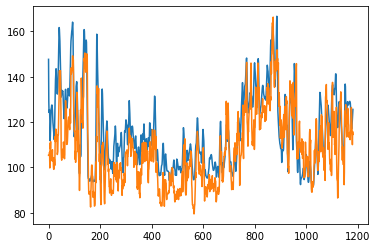

In [ ]:
#plt.plot(eval_DTSM)
#plt.plot(y_hat)
#plt.show()

In [ ]:
Cluster_1 = (5.80127095, 3.52103194)
Cluster_2 = (2.27100945, 7.48227453)

In [ ]:
# Well test 1

las = lasio.read('/content/drive/MyDrive/Leaderboard/0a7822c59487_TGS.las')
lat = las.well['SLAT'].value
long =las.well['SLON'].value

data = las.df()
#data = data.fillna(data.mean())
data = data.interpolate()

GR = (data['GRD'].values+data['GRS'].values+data['GRR_1'].values)/3.0 # Eliminate where GR, DENS, and NEUT is NaN
GR = signal.medfilt(GR,11)
window = 13 # the length of filter is 13 samples or ~ 2 metres
gr_sm = np.median(rolling_window(GR,window), -1)
gr_sm = np.pad(gr_sm, int(window/2), mode='edge')
GR = despike(GR, gr_sm, max_clip = 10)
GR = np.reshape(np.array(GR),(GR.shape[0],1))
DENS = (data['RHOZ'].values+data['RHOB'].values)/2.0 # Eliminate where GR, DENS, and NEUT is NaN
DENS = signal.medfilt(DENS,11)
window = 13 # the length of filter is 13 samples or ~ 2 metres
rho_sm = np.median(rolling_window(DENS,window), -1)
rho_sm = np.pad(rho_sm, int(window/2), mode='edge')
DENS = despike(DENS, rho_sm, max_clip = 0.1)

DENS = np.reshape(np.array(DENS),(DENS.shape[0],1))
NEUT = (data['NPOR_SS'].values+data['TNPH_SS'].values+data['TNPH_LS'].values+data['NPHI_SS'].values)/4.0 # Eliminate where GR, DENS, and NEUT is NaN
NEUT = signal.medfilt(NEUT,11)
window = 13 # the length of filter is 13 samples or ~ 2 metres
neut_sm = np.median(rolling_window(NEUT,window), -1)
neut_sm = np.pad(neut_sm, int(window/2), mode='edge')
NEUT = despike(NEUT, neut_sm, max_clip = 0.1)
NEUT = np.reshape(np.array(NEUT),(NEUT.shape[0],1))
DT = (data['DTCO'].values+data['DTRP'].values)/2.0 # Eliminate where GR, DENS, and NEUT is NaN
window = 13 # the length of filter is 13 samples or ~ 2 metres
dt_sm = np.median(rolling_window(DT,window), -1)
dt_sm = np.pad(dt_sm, int(window/2), mode='edge')
DT = despike(DT, dt_sm, max_clip = 10)
DT = np.reshape(np.array(DT),(DT.shape[0],1))

dat=np.concatenate((GR,DENS,NEUT,DT),axis=1)
arr = np.zeros((len(dat),2),dtype=float)
for i in range(len(dat)):
    arr[i,:]=[lat,long]
dat=np.concatenate((dat,arr),axis=1)

In [ ]:
data.describe()

,CALR,DPHI_LS,DPHI_SS,DPHZ_LS,DPHZ_SS,DRHO,DTCO,DTRP,GRD,GRR_1,GRS,HCALD,HCALR,HCALR_1,HDRA,HLLD,HLLD1,HLLS,HLLS_1,LLD,LLS,MSFL,NPHI_SS,NPOR_LS,NPOR_SS,PEF,PEFZ,RHOB,RHOZ,RXOZ,RXOZ1,SPHI_LS,TEND,TENR_1,TENS,TNPH_LS,TNPH_SS
count,4947.000000,4947.000000,4925.000000,5135.000000,5135.000000,4947.000000,5111.000000,5112.000000,5135.000000,4947.000000,5135.000000,5135.000000,5135.000000,4935.000000,5135.000000,5135.000000,4935.000000,5135.000000,4935.000000,4947.000000,4947.000000,4947.000000,1909.000000,5061.000000,5061.000000,4947.000000,5135.000000,4915.000000,5135.000000,5135.000000,4935.000000,5111.000000,5135.000000,4935.000000,5135.000000,5135.000000,5135.000000
mean,5.685730,0.185958,0.153892,0.087107,0.042581,0.048198,73.161341,73.840058,95.641376,151.142718,72.568255,8.534922,7.858058,7.639321,0.024491,9.123788,16.545034,9.597895,34.894745,67.636146,48.640091,23.824687,0.186441,0.197049,0.243991,2.854281,3.300101,2.396230,2.645122,27.985895,34.656193,0.180840,5754.599747,1926.243326,4433.754721,0.194913,0.246168
std,1.893949,0.177449,0.184302,0.005623,0.004511,0.056857,12.523577,12.539324,35.798060,16.306642,29.059209,0.086509,0.228822,0.010868,0.003890,8.097068,38.672221,9.817711,32.522403,362.068632,144.870491,77.744994,0.102214,0.102882,0.106300,0.502052,0.094511,0.318693,0.010100,5.122999,17.779910,0.088635,1721.732883,825.667887,406.469232,0.009803,0.010152
min,2.358100,0.002700,-0.038900,0.009100,-0.030000,-0.046300,43.543800,44.134900,11.455300,39.440500,14.037500,8.517200,7.798600,7.584100,-0.010100,6.467100,2.460200,6.874800,2.675600,1.454400,0.251900,0.194600,0.022500,-0.011800,0.013600,1.615900,3.025100,1.213300,2.536300,6.474800,0.197700,-0.028500,2079.387000,1409.407100,3720.059100,0.081200,0.125400
25%,5.725350,0.074500,0.038000,0.088000,0.043100,0.003500,61.447700,62.287125,77.543750,156.931000,55.622050,8.518000,7.811000,7.634700,0.024400,8.534000,16.019100,8.906200,37.645000,8.447050,7.728650,4.725700,0.104900,0.130300,0.178800,2.563600,3.282800,2.337200,2.646800,28.332400,19.952850,0.098050,5471.089200,1409.407100,4036.956000,0.196500,0.247800
50%,5.945600,0.093700,0.057800,0.088000,0.043100,0.016700,73.280700,73.945400,105.656900,156.931000,77.062000,8.518000,7.811000,7.634700,0.024400,8.534000,16.019100,8.906200,37.645000,10.878400,10.309800,5.771800,0.157900,0.199800,0.251000,2.876700,3.282800,2.561500,2.646800,28.332400,44.752300,0.182000,6348.508400,1409.407100,4433.869900,0.196500,0.247800
75%,6.522950,0.224150,0.202700,0.088000,0.043100,0.115700,82.314200,83.080800,118.033000,156.931000,88.872950,8.518000,7.811000,7.634700,0.024400,8.534000,16.019100,8.906200,37.645000,20.597550,19.491850,12.194150,0.260600,0.299700,0.348100,3.191150,3.282800,2.592250,2.646800,28.332400,44.752300,0.245500,6919.930000,3006.877700,4724.729750,0.196500,0.247800
max,12.008000,0.700400,0.700300,0.110700,0.077300,0.297100,106.423200,106.793200,299.572800,199.834400,199.895200,9.229800,9.317200,7.744000,0.105800,226.509500,1933.477000,286.927800,1190.179700,8728.520900,1928.627600,1329.269200,0.551200,0.545800,0.591700,8.948200,4.253000,2.708100,2.700100,255.369700,101.258400,0.415600,8159.179600,4051.379600,5364.113900,0.212500,0.263200


In [ ]:
W1 = np.array((lat,long))
if np.linalg.norm(Cluster_1-W1) <= np.linalg.norm(Cluster_2-W1):
    dat = scaler1.transform(dat)
    y_hat = model_1.predict(dat)
    y_hat = y_hat.reshape(-1,1)
    y_hat_1 = scaler3.inverse_transform(y_hat)
else:
    dat = scaler2.transform(dat)
    y_hat = model_2.predict(dat)
    y_hat = y_hat.reshape(-1,1)
    y_hat_1 = scaler4.inverse_transform(y_hat)

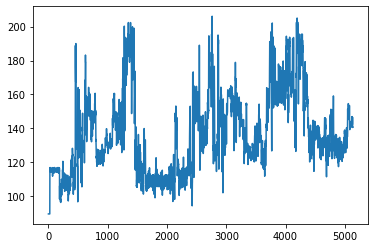

In [ ]:
plt.plot(y_hat_1)
plt.show()

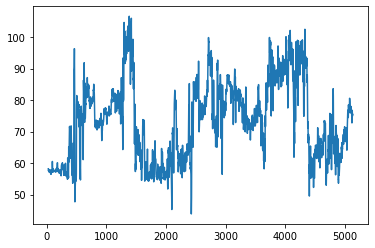

In [ ]:
plt.plot(DT)
plt.show()

In [ ]:
# Well test 2

las = lasio.read('/content/drive/MyDrive/Leaderboard/00d02be79f49_TGS.las')
lat = las.well['SLAT'].value
long =las.well['SLON'].value

data = las.df()
#data = data.fillna(data.mean())
data = data.interpolate()

GR = data['GRR'].values # Eliminate where GR, DENS, and NEUT is NaN
GR = signal.medfilt(GR,11)
window = 13 # the length of filter is 13 samples or ~ 2 metres
gr_sm = np.median(rolling_window(GR,window), -1)
gr_sm = np.pad(gr_sm, int(window/2), mode='edge')
GR = despike(GR, gr_sm, max_clip = 10)
GR = np.reshape(np.array(GR),(GR.shape[0],1))
DENS = data['RHOB'].values # Eliminate where GR, DENS, and NEUT is NaN
DENS = signal.medfilt(DENS,11)
window = 13 # the length of filter is 13 samples or ~ 2 metres
rho_sm = np.median(rolling_window(DENS,window), -1)
rho_sm = np.pad(rho_sm, int(window/2), mode='edge')
DENS = despike(DENS, rho_sm, max_clip = 0.1)

DENS = np.reshape(np.array(DENS),(DENS.shape[0],1))
NEUT = data['NPHI_LS'].values # Eliminate where GR, DENS, and NEUT is NaN
NEUT = signal.medfilt(NEUT,11)
window = 13 # the length of filter is 13 samples or ~ 2 metres
neut_sm = np.median(rolling_window(NEUT,window), -1)
neut_sm = np.pad(neut_sm, int(window/2), mode='edge')
NEUT = despike(NEUT, neut_sm, max_clip = 0.1)
NEUT = np.reshape(np.array(NEUT),(NEUT.shape[0],1))
DT = data['DTCO'].values # Eliminate where GR, DENS, and NEUT is NaN
window = 13 # the length of filter is 13 samples or ~ 2 metres
dt_sm = np.median(rolling_window(DT,window), -1)
dt_sm = np.pad(dt_sm, int(window/2), mode='edge')
DT = despike(DT, dt_sm, max_clip = 10)
DT = np.reshape(np.array(DT),(DT.shape[0],1))

dat=np.concatenate((GR,DENS,NEUT,DT),axis=1)
arr = np.zeros((len(dat),2),dtype=float)
for i in range(len(dat)):
    arr[i,:]=[lat,long]
dat=np.concatenate((dat,arr),axis=1)

In [ ]:
data

,DPHI_LS,NPHI_LS,DRHO,PEF,CALD,RHOB,GRR,ILD,ILM,SPR,SFLU,CILD,SFLA,DTCO
DEPT,,,,,,,,,,,,,,
9912.0,0.4860,0.1057,-0.2491,NaN,6.2363,1.8771,49.1883,1900.9751,1979.1610,12.2620,1.1093,NaN,NaN,NaN
9912.5,0.4769,0.0925,-0.2487,NaN,6.2481,1.8989,56.5820,1990.3184,1985.7312,5.1245,0.2062,NaN,NaN,NaN
9913.0,0.4480,0.0818,-0.2482,NaN,6.2844,2.0063,68.5213,1988.7848,1992.3221,-4.5998,0.2538,NaN,NaN,NaN
9913.5,0.3845,0.0791,-0.2478,NaN,6.6677,2.0603,78.8782,1987.2515,1975.0984,-14.8317,1.0988,NaN,NaN,NaN
9914.0,0.3215,0.0857,-0.2474,NaN,7.2943,2.1871,83.4741,1985.7203,1621.4595,-17.6811,7.7941,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10563.0,0.0240,0.0179,0.0008,NaN,5.7754,2.6689,103.2425,7.5443,7.3920,4.1529,13.8619,NaN,NaN,102.9745
10563.5,0.0256,0.0179,0.0003,NaN,5.7898,2.6667,103.2425,7.4225,7.1999,4.3319,13.0712,NaN,NaN,102.9745
10564.0,0.0262,0.0179,-0.0006,NaN,5.7889,2.6654,103.2425,7.2454,7.1717,4.3504,12.4916,NaN,NaN,102.9745


In [ ]:
W2 = np.array((lat,long))
if np.linalg.norm(Cluster_1-W2) <= np.linalg.norm(Cluster_2-W2):
    dat = scaler1.transform(dat)
    y_hat = model_1.predict(dat)
    y_hat = y_hat.reshape(-1,1)
    y_hat_2 = scaler3.inverse_transform(y_hat)
else:
    dat = scaler2.transform(dat)
    y_hat = model_2.predict(dat)
    y_hat = y_hat.reshape(-1,1)
    y_hat_2 = scaler4.inverse_transform(y_hat)

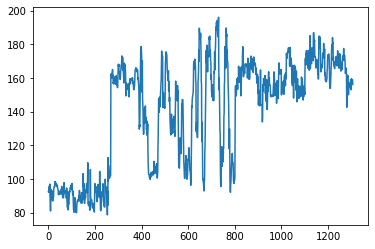

In [ ]:
plt.plot(y_hat_2)
plt.show()

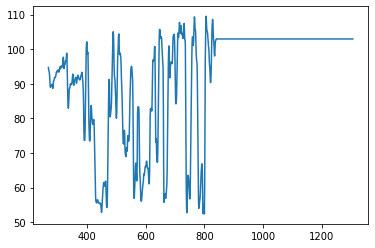

In [ ]:
plt.plot(DT)
plt.show()

In [ ]:
# Well test 3

las = lasio.read('/content/drive/MyDrive/Leaderboard/2f96a5f92418_TGS.las')
lat = las.well['SLAT'].value
long =las.well['SLON'].value

data = las.df()
#data = data.fillna(data.mean())
data = data.interpolate()

GR = data['GRR'].values # Eliminate where GR, DENS, and NEUT is NaN
GR = signal.medfilt(GR,11)
window = 13 # the length of filter is 13 samples or ~ 2 metres
gr_sm = np.median(rolling_window(GR,window), -1)
gr_sm = np.pad(gr_sm, int(window/2), mode='edge')
GR = despike(GR, gr_sm, max_clip = 10)
GR = np.reshape(np.array(GR),(GR.shape[0],1))
DENS = data['RHOZ'].values # Eliminate where GR, DENS, and NEUT is NaN
DENS = signal.medfilt(DENS,11)
window = 13 # the length of filter is 13 samples or ~ 2 metres
rho_sm = np.median(rolling_window(DENS,window), -1)
rho_sm = np.pad(rho_sm, int(window/2), mode='edge')
DENS = despike(DENS, rho_sm, max_clip = 0.1)

DENS = np.reshape(np.array(DENS),(DENS.shape[0],1))
NEUT = data['NPHI_LS'].values # Eliminate where GR, DENS, and NEUT is NaN
NEUT = signal.medfilt(NEUT,11)
window = 13 # the length of filter is 13 samples or ~ 2 metres
neut_sm = np.median(rolling_window(NEUT,window), -1)
neut_sm = np.pad(neut_sm, int(window/2), mode='edge')
NEUT = despike(NEUT, neut_sm, max_clip = 0.1)
NEUT = np.reshape(np.array(NEUT),(NEUT.shape[0],1))
DT = data['DTCO'].values # Eliminate where GR, DENS, and NEUT is NaN
window = 13 # the length of filter is 13 samples or ~ 2 metres
dt_sm = np.median(rolling_window(DT,window), -1)
dt_sm = np.pad(dt_sm, int(window/2), mode='edge')
DT = despike(DT, dt_sm, max_clip = 10)
DT = np.reshape(np.array(DT),(DT.shape[0],1))

dat=np.concatenate((GR,DENS,NEUT,DT),axis=1)
arr = np.zeros((len(dat),2),dtype=float)
for i in range(len(dat)):
    arr[i,:]=[lat,long]
dat=np.concatenate((dat,arr),axis=1)

In [ ]:
data

,AHT20,AHT30,AHT60,DPHZ_LS,GRR,HCALD,HDRA,NPHI_LS,PEFZ,RHOZ,SPR,DTCO,AHF20,AHF60,AHFCO60,AHT90
DEPT,,,,,,,,,,,,,,,,
12787.5,32.0439,32.9102,36.1351,0.0127,62.2343,9.8345,0.0254,0.0501,3.4395,2.6890,-24.1669,NaN,NaN,NaN,NaN,38.3292
12788.0,28.6194,29.3932,31.0545,0.0116,64.1594,9.8447,0.0191,0.0522,3.5170,2.6892,-24.0141,NaN,NaN,NaN,NaN,33.4088
12788.5,25.2142,25.8959,27.5076,0.0169,66.7112,9.8543,0.0149,0.0565,3.4918,2.6798,-23.6796,56.0509,NaN,NaN,NaN,28.5107
12789.0,22.4223,23.0286,25.6505,0.0255,69.5256,9.8578,0.0128,0.0606,3.4099,2.6637,-23.7228,55.7553,NaN,NaN,NaN,26.5559
12789.5,19.1397,19.6573,22.1401,0.0309,72.6061,9.8580,0.0139,0.0634,3.3407,2.6565,-23.7659,55.1612,NaN,NaN,NaN,22.7319
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14533.5,12.9516,10.1759,15.8122,0.0011,116.9884,5.8087,0.2008,0.1444,3.2887,2.7019,-32.9206,72.0386,NaN,NaN,NaN,19.1217
14534.0,10.3118,8.3469,12.3589,0.0045,116.9884,5.7933,0.2056,0.1444,3.0952,2.6997,-33.3963,72.3347,NaN,NaN,NaN,14.0426
14534.5,7.6720,7.0079,8.9056,0.0043,116.9884,5.7931,0.2151,0.1444,2.9018,2.7004,-33.6015,72.3308,NaN,NaN,NaN,8.9764


In [ ]:
W3 = np.array((lat,long))
if np.linalg.norm(Cluster_1-W3) <= np.linalg.norm(Cluster_2-W3):
    dat = scaler1.transform(dat)
    y_hat = model_1.predict(dat)
    y_hat = y_hat.reshape(-1,1)
    y_hat_3 = scaler3.inverse_transform(y_hat)
else:
    dat = scaler2.transform(dat)
    y_hat = model_2.predict(dat)
    y_hat = y_hat.reshape(-1,1)
    y_hat_3 = scaler4.inverse_transform(y_hat)

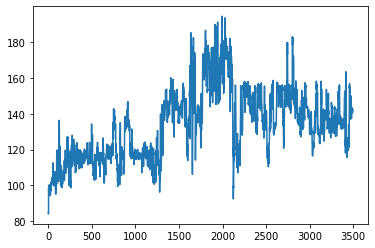

In [ ]:
plt.plot(y_hat_3)
plt.show()

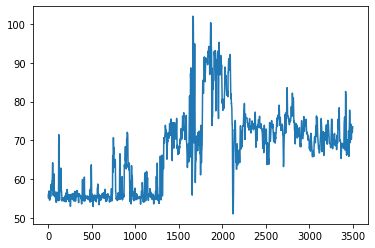

In [ ]:
plt.plot(DT)
plt.show()

In [ ]:
# Well test 4

las = lasio.read('/content/drive/MyDrive/Leaderboard/8e37531ba266_TGS.las')
lat = las.well['SLAT'].value
long =las.well['SLON'].value

data = las.df()
#data = data.fillna(data.mean())
data = data.interpolate()

GR = data['GRD'].values # Eliminate where GR, DENS, and NEUT is NaN
GR = signal.medfilt(GR,11)
window = 13 # the length of filter is 13 samples or ~ 2 metres
gr_sm = np.median(rolling_window(GR,window), -1)
gr_sm = np.pad(gr_sm, int(window/2), mode='edge')
GR = despike(GR, gr_sm, max_clip = 10)
GR = np.reshape(np.array(GR),(GR.shape[0],1))
DENS = data['RHOB'].values # Eliminate where GR, DENS, and NEUT is NaN ?
DENS = signal.medfilt(DENS,11)
window = 13 # the length of filter is 13 samples or ~ 2 metres
rho_sm = np.median(rolling_window(DENS,window), -1)
rho_sm = np.pad(rho_sm, int(window/2), mode='edge')
DENS = despike(DENS, rho_sm, max_clip = 0.1)

DENS = np.reshape(np.array(DENS),(DENS.shape[0],1))
NEUT = data['NPHI_LS'].values # Eliminate where GR, DENS, and NEUT is NaN
NEUT = signal.medfilt(NEUT,11)
window = 13 # the length of filter is 13 samples or ~ 2 metres
neut_sm = np.median(rolling_window(NEUT,window), -1)
neut_sm = np.pad(neut_sm, int(window/2), mode='edge')
NEUT = despike(NEUT, neut_sm, max_clip = 0.1)
NEUT = np.reshape(np.array(NEUT),(NEUT.shape[0],1))
DT = data['DTCO'].values # Eliminate where GR, DENS, and NEUT is NaN
window = 13 # the length of filter is 13 samples or ~ 2 metres
dt_sm = np.median(rolling_window(DT,window), -1)
dt_sm = np.pad(dt_sm, int(window/2), mode='edge')
DT = despike(DT, dt_sm, max_clip = 10)
DT = np.reshape(np.array(DT),(DT.shape[0],1))

dat=np.concatenate((GR,DENS,NEUT,DT),axis=1)
arr = np.zeros((len(dat),2),dtype=float)
for i in range(len(dat)):
    arr[i,:]=[lat,long]
dat=np.concatenate((dat,arr),axis=1)

In [ ]:
data

,LLD,LLS,MSFL,NPHI_LS,CALD,GRD,RHOB,PEF,DPHI_LS,DRHO,DTCO
DEPT,,,,,,,,,,,
2313.0,1742.3221,1611.5833,1970.7509,-0.0064,9.2219,4.8690,NaN,5.7287,-0.1847,0.0020,49.3995
2313.5,1701.2577,1223.3444,1784.0388,-0.0054,9.2214,5.4314,NaN,5.8181,-0.1921,0.0015,50.0797
2314.0,1091.9812,872.8607,1380.1421,-0.0037,9.2197,6.9379,NaN,5.6803,-0.1921,0.0011,52.1421
2314.5,694.8534,613.4688,1336.8389,-0.0018,9.2160,8.3430,NaN,5.3601,-0.1745,0.0006,53.2090
2315.0,571.6710,437.9040,2000.0000,-0.0020,9.2162,10.1664,NaN,5.3182,-0.1609,0.0001,53.4997
...,...,...,...,...,...,...,...,...,...,...,...
4826.0,2712.0273,1713.1652,1539.3755,0.0133,7.7432,85.4109,2.7911,3.2626,0.0259,0.0061,47.8760
4826.5,2396.1658,1603.5250,1757.2728,0.0133,7.7432,85.4109,2.7911,3.2626,0.0259,0.0061,47.8566
4827.0,2138.2012,1503.2882,1129.5292,0.0133,7.7432,85.4109,2.7911,3.2626,0.0259,0.0061,47.8405


In [ ]:
W4 = np.array((lat,long))
if np.linalg.norm(Cluster_1-W4) <= np.linalg.norm(Cluster_2-W4):
    dat = scaler1.transform(dat)
    y_hat = model_1.predict(dat)
    y_hat = y_hat.reshape(-1,1)
    y_hat_4 = scaler3.inverse_transform(y_hat)
else:
    dat = scaler2.transform(dat)
    y_hat = model_2.predict(dat)
    y_hat = y_hat.reshape(-1,1)
    y_hat_4 = scaler4.inverse_transform(y_hat)

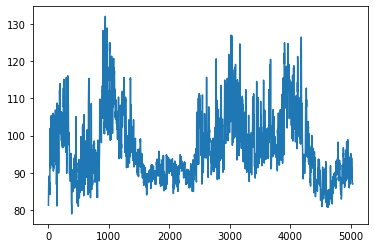

In [ ]:
plt.plot(y_hat_4)
plt.show()

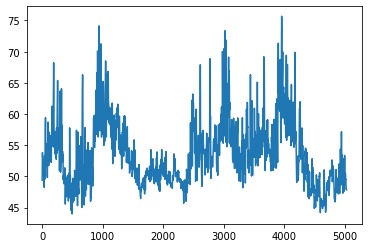

In [ ]:
plt.plot(DT)
plt.show()

In [ ]:
# Well test 5

las = lasio.read('/content/drive/MyDrive/Leaderboard/34a80ab7a5fa_TGS.las')
lat = las.well['SLAT'].value
long =las.well['SLON'].value

data = las.df()
#data = data.fillna(data.mean())
data = data.interpolate()

GR = (data['GR'].values+data['GRR'].values)/2.0 # Eliminate where GR, DENS, and NEUT is NaN
GR = signal.medfilt(GR,11)
window = 13 # the length of filter is 13 samples or ~ 2 metres
gr_sm = np.median(rolling_window(GR,window), -1)
gr_sm = np.pad(gr_sm, int(window/2), mode='edge')
GR = despike(GR, gr_sm, max_clip = 10)
GR = np.reshape(np.array(GR),(GR.shape[0],1))
DENS = data['RHOZ'].values # Eliminate where GR, DENS, and NEUT is NaN ?
DENS = signal.medfilt(DENS,11)
window = 13 # the length of filter is 13 samples or ~ 2 metres
rho_sm = np.median(rolling_window(DENS,window), -1)
rho_sm = np.pad(rho_sm, int(window/2), mode='edge')
DENS = despike(DENS, rho_sm, max_clip = 0.1)

DENS = np.reshape(np.array(DENS),(DENS.shape[0],1))
NEUT = data['NPOR_LS'].values # Eliminate where GR, DENS, and NEUT is NaN
NEUT = signal.medfilt(NEUT,11)
window = 13 # the length of filter is 13 samples or ~ 2 metres
neut_sm = np.median(rolling_window(NEUT,window), -1)
neut_sm = np.pad(neut_sm, int(window/2), mode='edge')
NEUT = despike(NEUT, neut_sm, max_clip = 0.1)
NEUT = np.reshape(np.array(NEUT),(NEUT.shape[0],1))
DT = data['DTCO'].values # Eliminate where GR, DENS, and NEUT is NaN
window = 13 # the length of filter is 13 samples or ~ 2 metres
dt_sm = np.median(rolling_window(DT,window), -1)
dt_sm = np.pad(dt_sm, int(window/2), mode='edge')
DT = despike(DT, dt_sm, max_clip = 10)
DT = np.reshape(np.array(DT),(DT.shape[0],1))

dat=np.concatenate((GR,DENS,NEUT,DT),axis=1)
arr = np.zeros((len(dat),2),dtype=float)
for i in range(len(dat)):
    arr[i,:]=[lat,long]
dat=np.concatenate((dat,arr),axis=1)

In [ ]:
data

,DTCO,GR,DPHZ_LS,HCALD,HDRA,NPOR_LS,PEFZ,RHOZ,AT10,AT30,AT90,SPR,GRR
DEPT,,,,,,,,,,,,,
7887.0,69.7828,NaN,0.0797,14.0301,0.1194,0.2105,3.2033,2.5715,6.5340,8.7404,9.2777,-20.4534,106.8395
7887.5,69.3553,NaN,0.0797,14.1436,0.1402,0.2173,3.2322,2.5727,6.4940,8.3379,8.2673,-21.0287,110.4341
7888.0,67.9840,NaN,0.0779,13.8465,0.1774,0.2335,3.2337,2.5656,6.3669,8.0632,8.1039,-21.3061,110.8945
7888.5,66.6319,NaN,0.0881,12.5077,0.2086,0.2431,3.2355,2.5167,5.9920,7.7445,8.6835,-21.2853,108.9048
7889.0,65.2799,NaN,0.1231,13.1330,0.2346,0.2511,3.1926,2.4871,5.7558,7.6431,8.1163,-21.2646,107.1343
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8894.0,71.5285,59.8227,0.0708,8.3906,0.1618,0.1900,3.1056,2.6132,8.7561,9.3927,8.9537,-29.2455,149.3206
8894.5,70.9240,62.7770,0.0817,8.3016,0.1529,0.1900,3.1069,2.5894,8.9454,9.7951,9.4013,-29.2126,150.3792
8895.0,70.4684,63.6632,0.0915,8.5849,0.1433,0.1995,3.1230,2.5709,8.7130,9.8721,9.5426,-29.1782,151.0764


In [ ]:
W5 = np.array((lat,long))
if np.linalg.norm(Cluster_1-W5) <= np.linalg.norm(Cluster_2-W5):
    dat = scaler1.transform(dat)
    y_hat = model_1.predict(dat)
    y_hat = y_hat.reshape(-1,1)
    y_hat_5 = scaler3.inverse_transform(y_hat)
else:
    dat = scaler2.transform(dat)
    y_hat = model_2.predict(dat)
    y_hat = y_hat.reshape(-1,1)
    y_hat_5 = scaler4.inverse_transform(y_hat)

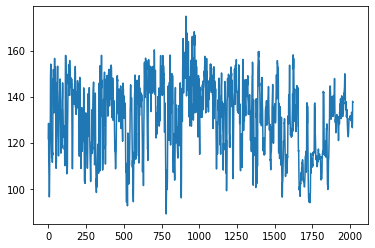

In [ ]:
plt.plot(y_hat_5)
plt.show()

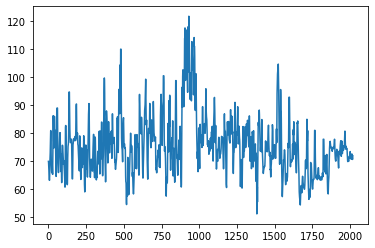

In [ ]:
plt.plot(DT)
plt.show()

In [ ]:
# Well test 6

las = lasio.read('/content/drive/MyDrive/Leaderboard/84c5fb9cc880_TGS.las')
lat = las.well['SLAT'].value
long =las.well['SLON'].value

data = las.df()
#data = data.fillna(data.mean())
data = data.interpolate()

GR = data['GRR'].values # Eliminate where GR, DENS, and NEUT is NaN
GR = signal.medfilt(GR,11)
window = 13 # the length of filter is 13 samples or ~ 2 metres
gr_sm = np.median(rolling_window(GR,window), -1)
gr_sm = np.pad(gr_sm, int(window/2), mode='edge')
GR = despike(GR, gr_sm, max_clip = 10)
GR = np.reshape(np.array(GR),(GR.shape[0],1))
DENS = data['RHOM'].values # Eliminate where GR, DENS, and NEUT is NaN ?
DENS = signal.medfilt(DENS,11)
window = 13 # the length of filter is 13 samples or ~ 2 metres
rho_sm = np.median(rolling_window(DENS,window), -1)
rho_sm = np.pad(rho_sm, int(window/2), mode='edge')
DENS = despike(DENS, rho_sm, max_clip = 0.1)

DENS = np.reshape(np.array(DENS),(DENS.shape[0],1))
NEUT = data['NPHI_LS'].values # Eliminate where GR, DENS, and NEUT is NaN
NEUT = signal.medfilt(NEUT,11)
window = 13 # the length of filter is 13 samples or ~ 2 metres
neut_sm = np.median(rolling_window(NEUT,window), -1)
neut_sm = np.pad(neut_sm, int(window/2), mode='edge')
NEUT = despike(NEUT, neut_sm, max_clip = 0.1)
NEUT = np.reshape(np.array(NEUT),(NEUT.shape[0],1))
DT = data['DTCO'].values # Eliminate where GR, DENS, and NEUT is NaN
window = 13 # the length of filter is 13 samples or ~ 2 metres
dt_sm = np.median(rolling_window(DT,window), -1)
dt_sm = np.pad(dt_sm, int(window/2), mode='edge')
DT = despike(DT, dt_sm, max_clip = 10)
DT = np.reshape(np.array(DT),(DT.shape[0],1))

dat=np.concatenate((GR,DENS,NEUT,DT),axis=1)
arr = np.zeros((len(dat),2),dtype=float)
for i in range(len(dat)):
    arr[i,:]=[lat,long]
dat=np.concatenate((dat,arr),axis=1)

In [ ]:
data.describe()

,NPHI_LS,DTCO,PEFZ,DPHZ_LS,HCALD,HDRA,RHOZ,DRH,LCALD,DPO_LS,RHOM,GRR,ILD,ILM,SFLU,SPR,IDPH,IMPH
count,1291.000000,1291.000000,0.0,0.0,0.0,0.0,0.0,1291.000000,1291.000000,1291.000000,1291.000000,1291.000000,0.0,0.0,0.0,1291.000000,1291.000000,1291.000000
mean,0.215912,86.578166,NaN,NaN,NaN,NaN,NaN,-0.007045,6.210844,0.055017,2.616598,91.192968,NaN,NaN,NaN,-56.659917,5.781819,7.804910
std,0.070989,10.403269,NaN,NaN,NaN,NaN,NaN,0.006961,0.073684,0.045493,0.077612,23.896420,NaN,NaN,NaN,23.118069,55.494275,79.811366
min,0.040400,63.674400,NaN,NaN,NaN,NaN,NaN,-0.056500,6.065200,-0.023900,1.896300,23.383500,NaN,NaN,NaN,-98.094900,0.340900,0.666800
25%,0.175750,81.819100,NaN,NaN,NaN,NaN,NaN,-0.009600,6.163250,0.032300,2.610000,79.467750,NaN,NaN,NaN,-80.803750,2.392050,2.317300
50%,0.216100,85.845400,NaN,NaN,NaN,NaN,NaN,-0.007300,6.188300,0.043700,2.636400,88.992600,NaN,NaN,NaN,-47.448600,2.722800,2.655400
75%,0.252350,89.631850,NaN,NaN,NaN,NaN,NaN,-0.004600,6.261700,0.058650,2.655000,102.741250,NaN,NaN,NaN,-39.203750,3.122150,3.128700
max,0.554900,130.216600,NaN,NaN,NaN,NaN,NaN,0.070100,6.543400,0.474800,2.749600,205.776200,NaN,NaN,NaN,9.684800,1979.710900,2014.840700


In [ ]:
W6 = np.array((lat,long))
if np.linalg.norm(Cluster_1-W6) <= np.linalg.norm(Cluster_2-W6):
    dat = scaler1.transform(dat)
    y_hat = model_1.predict(dat)
    y_hat = y_hat.reshape(-1,1)
    y_hat_6 = scaler3.inverse_transform(y_hat)
else:
    dat = scaler2.transform(dat)
    y_hat = model_2.predict(dat)
    y_hat = y_hat.reshape(-1,1)
    y_hat_6 = scaler4.inverse_transform(y_hat)

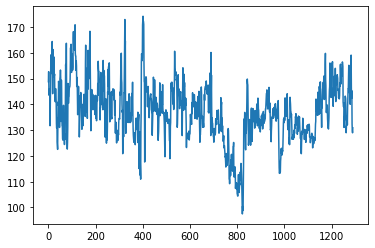

In [ ]:
plt.plot(y_hat_6)
plt.show()

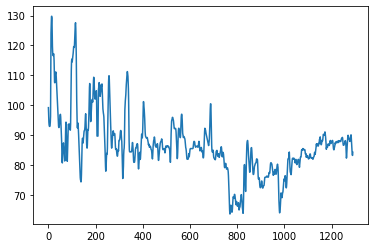

In [ ]:
plt.plot(DT)
plt.show()

In [ ]:
# Well test 7

las = lasio.read('/content/drive/MyDrive/Leaderboard/94c1f5cae85c_TGS.las')
lat = las.well['SLAT'].value
long =las.well['SLON'].value

data = las.df()
#data = data.fillna(data.mean())
data = data.interpolate()

GR = data['GRD'].values # Eliminate where GR, DENS, and NEUT is NaN
GR = signal.medfilt(GR,11)
window = 13 # the length of filter is 13 samples or ~ 2 metres
gr_sm = np.median(rolling_window(GR,window), -1)
gr_sm = np.pad(gr_sm, int(window/2), mode='edge')
GR = despike(GR, gr_sm, max_clip = 10)
GR = np.reshape(np.array(GR),(GR.shape[0],1))
DENS = data['RHOB'].values # Eliminate where GR, DENS, and NEUT is NaN ?
DENS = signal.medfilt(DENS,11)
window = 13 # the length of filter is 13 samples or ~ 2 metres
rho_sm = np.median(rolling_window(DENS,window), -1)
rho_sm = np.pad(rho_sm, int(window/2), mode='edge')
DENS = despike(DENS, rho_sm, max_clip = 0.1)

DENS = np.reshape(np.array(DENS),(DENS.shape[0],1))
NEUT = data['NPHI_LS'].values # Eliminate where GR, DENS, and NEUT is NaN
NEUT = signal.medfilt(NEUT,11)
window = 13 # the length of filter is 13 samples or ~ 2 metres
neut_sm = np.median(rolling_window(NEUT,window), -1)
neut_sm = np.pad(neut_sm, int(window/2), mode='edge')
NEUT = despike(NEUT, neut_sm, max_clip = 0.1)
NEUT = np.reshape(np.array(NEUT),(NEUT.shape[0],1))
DT = data['DTCO'].values # Eliminate where GR, DENS, and NEUT is NaN
window = 13 # the length of filter is 13 samples or ~ 2 metres
dt_sm = np.median(rolling_window(DT,window), -1)
dt_sm = np.pad(dt_sm, int(window/2), mode='edge')
DT = despike(DT, dt_sm, max_clip = 10)
DT = np.reshape(np.array(DT),(DT.shape[0],1))

dat=np.concatenate((GR,DENS,NEUT,DT),axis=1)
arr = np.zeros((len(dat),2),dtype=float)
for i in range(len(dat)):
    arr[i,:]=[lat,long]
dat=np.concatenate((dat,arr),axis=1)

In [ ]:
data

,GRD,NPHI_LS,DPHI_LS,DRHO,CALD,RHOB,PEFS,PEFL,DTCO,ILD,ILM
DEPT,,,,,,,,,,,
16900.0,24.1743,0.2041,0.1491,-0.2499,10.8194,2.6022,NaN,NaN,71.8275,1906.7026,2022.0276
16900.5,24.1527,0.2019,0.2300,-0.2498,10.8327,2.3962,NaN,NaN,65.7144,1972.9764,2029.6692
16901.0,24.6986,0.1990,0.1896,-0.2498,10.8498,2.3577,NaN,NaN,60.3096,1978.8535,2037.3385
16901.5,25.6613,0.1923,0.1163,-0.1976,10.8963,2.4746,NaN,NaN,59.1601,1984.7482,2027.2594
16902.0,25.8414,0.1844,-0.0037,0.0989,10.9457,2.6162,NaN,NaN,61.6817,426.6070,2012.9601
...,...,...,...,...,...,...,...,...,...,...,...
25396.0,68.8877,0.1168,-0.0057,0.0006,8.1451,2.7200,5.6625,5.9501,57.1283,145.4749,600.6196
25396.5,68.8877,0.1168,-0.0143,0.0036,8.1450,2.7346,5.4154,5.4018,57.5242,145.7434,609.1075
25397.0,68.8877,0.1168,-0.0217,0.0061,8.1448,2.7482,5.3590,5.2066,57.2507,146.0124,648.7321


In [ ]:
W7 = np.array((lat,long))
if np.linalg.norm(Cluster_1-W7) <= np.linalg.norm(Cluster_2-W7):
    dat = scaler1.transform(dat)
    y_hat = model_1.predict(dat)
    y_hat = y_hat.reshape(-1,1)
    y_hat_7 = scaler3.inverse_transform(y_hat)
else:
    dat = scaler2.transform(dat)
    y_hat = model_2.predict(dat)
    y_hat = y_hat.reshape(-1,1)
    y_hat_7 = scaler4.inverse_transform(y_hat)

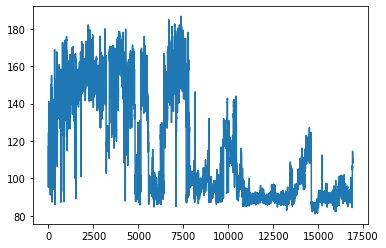

In [ ]:
plt.plot(y_hat_7)
plt.show()

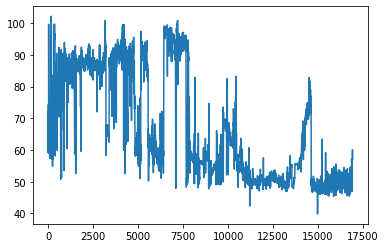

In [ ]:
plt.plot(DT)
plt.show()

In [ ]:
# Well test 8

las = lasio.read('/content/drive/MyDrive/Leaderboard/638f2cc65681_TGS.las')
lat = las.well['SLAT'].value
long =las.well['SLON'].value

data = las.df()
#data = data.fillna(data.mean())
data = data.interpolate()

GR = data['GRD'].values # Eliminate where GR, DENS, and NEUT is NaN
GR = signal.medfilt(GR,11)
window = 13 # the length of filter is 13 samples or ~ 2 metres
gr_sm = np.median(rolling_window(GR,window), -1)
gr_sm = np.pad(gr_sm, int(window/2), mode='edge')
GR = despike(GR, gr_sm, max_clip = 10)
GR = np.reshape(np.array(GR),(GR.shape[0],1))
DENS = data['RHOB'].values # Eliminate where GR, DENS, and NEUT is NaN ?
DENS = signal.medfilt(DENS,11)
window = 13 # the length of filter is 13 samples or ~ 2 metres
rho_sm = np.median(rolling_window(DENS,window), -1)
rho_sm = np.pad(rho_sm, int(window/2), mode='edge')
DENS = despike(DENS, rho_sm, max_clip = 0.1)

DENS = np.reshape(np.array(DENS),(DENS.shape[0],1))
NEUT = data['NPHI_LS'].values # Eliminate where GR, DENS, and NEUT is NaN
NEUT = signal.medfilt(NEUT,11)
window = 13 # the length of filter is 13 samples or ~ 2 metres
neut_sm = np.median(rolling_window(NEUT,window), -1)
neut_sm = np.pad(neut_sm, int(window/2), mode='edge')
NEUT = despike(NEUT, neut_sm, max_clip = 0.1)
NEUT = np.reshape(np.array(NEUT),(NEUT.shape[0],1))
DT = data['DTCO'].values # Eliminate where GR, DENS, and NEUT is NaN
window = 13 # the length of filter is 13 samples or ~ 2 metres
dt_sm = np.median(rolling_window(DT,window), -1)
dt_sm = np.pad(dt_sm, int(window/2), mode='edge')
DT = despike(DT, dt_sm, max_clip = 10)
DT = np.reshape(np.array(DT),(DT.shape[0],1))

dat=np.concatenate((GR,DENS,NEUT,DT),axis=1)
arr = np.zeros((len(dat),2),dtype=float)
for i in range(len(dat)):
    arr[i,:]=[lat,long]
dat=np.concatenate((dat,arr),axis=1)

In [ ]:
data

,GRD,NPHI_LS,CALD,PEF,DPHI_LS,DRHO,RHOB,DTCO
DEPT,,,,,,,,
5477.0,109.8204,0.2304,8.3639,2.6808,0.1222,-0.0105,2.5110,62.0852
5477.5,108.3283,0.2329,8.3488,2.9369,0.1183,-0.0082,2.5151,62.0802
5478.0,100.3604,0.2453,8.3210,3.3435,0.1158,-0.0092,2.5207,61.3165
5478.5,85.4166,0.2527,8.2916,3.8304,0.1044,-0.0099,2.5283,58.8969
5479.0,66.1692,0.2302,8.2764,4.5972,0.0741,-0.0082,2.5616,55.7223
...,...,...,...,...,...,...,...,...
6343.0,101.5116,0.1996,8.1120,2.9882,0.0756,0.0613,2.5859,85.5351
6343.5,101.5116,0.2023,8.1344,2.9558,0.0716,0.0599,2.5912,85.2844
6344.0,101.5116,0.2045,8.1344,2.9221,0.0721,0.0537,2.5939,85.0105


In [ ]:
W8 = np.array((lat,long))
if np.linalg.norm(Cluster_1-W8) <= np.linalg.norm(Cluster_2-W8):
    dat = scaler1.transform(dat)
    y_hat = model_1.predict(dat)
    y_hat = y_hat.reshape(-1,1)
    y_hat_8 = scaler3.inverse_transform(y_hat)
else:
    dat = scaler2.transform(dat)
    y_hat = model_2.predict(dat)
    y_hat = y_hat.reshape(-1,1)
    y_hat_8 = scaler4.inverse_transform(y_hat)

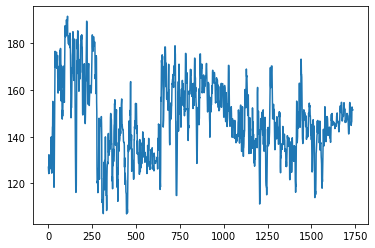

In [ ]:
plt.plot(y_hat_8)
plt.show()

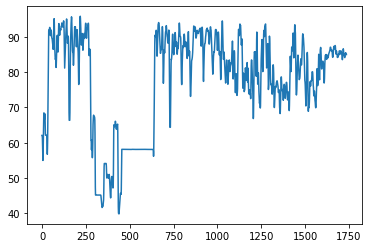

In [ ]:
plt.plot(DT)
plt.show()

In [ ]:
# Well test 9

las = lasio.read('/content/drive/MyDrive/Leaderboard/1684cc35f399_TGS.las')
lat = las.well['SLAT'].value
long =las.well['SLON'].value

data = las.df()
#data = data.fillna(data.mean())
data = data.interpolate()

GR = data['GRR'].values # Eliminate where GR, DENS, and NEUT is NaN
GR = signal.medfilt(GR,11)
window = 13 # the length of filter is 13 samples or ~ 2 metres
gr_sm = np.median(rolling_window(GR,window), -1)
gr_sm = np.pad(gr_sm, int(window/2), mode='edge')
GR = despike(GR, gr_sm, max_clip = 10)
GR = np.reshape(np.array(GR),(GR.shape[0],1))
DENS = data['RHOB'].values # Eliminate where GR, DENS, and NEUT is NaN ?
DENS = signal.medfilt(DENS,11)
window = 13 # the length of filter is 13 samples or ~ 2 metres
rho_sm = np.median(rolling_window(DENS,window), -1)
rho_sm = np.pad(rho_sm, int(window/2), mode='edge')
DENS = despike(DENS, rho_sm, max_clip = 0.1)

DENS = np.reshape(np.array(DENS),(DENS.shape[0],1))
NEUT = data['NPHI'].values # Eliminate where GR, DENS, and NEUT is NaN
NEUT = signal.medfilt(NEUT,11)
window = 13 # the length of filter is 13 samples or ~ 2 metres
neut_sm = np.median(rolling_window(NEUT,window), -1)
neut_sm = np.pad(neut_sm, int(window/2), mode='edge')
NEUT = despike(NEUT, neut_sm, max_clip = 0.1)
NEUT = np.reshape(np.array(NEUT),(NEUT.shape[0],1))
DT = data['DTCO'].values # Eliminate where GR, DENS, and NEUT is NaN
window = 13 # the length of filter is 13 samples or ~ 2 metres
dt_sm = np.median(rolling_window(DT,window), -1)
dt_sm = np.pad(dt_sm, int(window/2), mode='edge')
DT = despike(DT, dt_sm, max_clip = 10)
DT = np.reshape(np.array(DT),(DT.shape[0],1))

dat=np.concatenate((GR,DENS,NEUT,DT),axis=1)
arr = np.zeros((len(dat),2),dtype=float)
for i in range(len(dat)):
    arr[i,:]=[lat,long]
dat=np.concatenate((dat,arr),axis=1)

In [ ]:
data

,GRR,ILD,ILM,SFLU,SPR,CALR,DTCO,NPHI,DPHI,PE,DRHO,CALD,RHOB
DEPT,,,,,,,,,,,,,
5994.0,82.4304,9.1583,8.6697,8.6378,-24.9283,9.4701,71.2017,NaN,NaN,NaN,NaN,NaN,NaN
5994.5,80.1221,9.1626,8.6134,9.4136,-26.6600,9.4440,70.2243,NaN,NaN,NaN,NaN,NaN,NaN
5995.0,77.1246,9.1152,8.4855,10.0892,-27.2562,9.4560,67.5032,NaN,NaN,NaN,NaN,NaN,NaN
5995.5,76.2724,8.9201,8.3596,10.0951,-28.3344,9.4822,60.7898,NaN,NaN,NaN,NaN,NaN,NaN
5996.0,77.7058,8.1558,8.1499,9.8005,-30.2277,9.5882,56.5389,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12619.0,49.2102,19.4078,20.4200,26.9811,-4.6927,14.0549,59.9214,0.0147,0.0018,9.6087,0.0079,8.0495,2.7033
12619.5,43.3629,20.3790,21.6651,32.2151,-3.6559,14.0549,58.4130,0.0146,-0.0011,9.6087,0.0130,8.0495,2.7145
12620.0,38.6789,21.3987,23.6279,42.7477,-3.2519,14.0549,56.8803,0.0144,-0.0159,9.6087,0.0160,8.0244,2.7338


In [ ]:
W9 = np.array((lat,long))
if np.linalg.norm(Cluster_1-W9) <= np.linalg.norm(Cluster_2-W9):
    dat = scaler1.transform(dat)
    y_hat = model_1.predict(dat)
    y_hat = y_hat.reshape(-1,1)
    y_hat_9 = scaler3.inverse_transform(y_hat)
else:
    dat = scaler2.transform(dat)
    y_hat = model_2.predict(dat)
    y_hat = y_hat.reshape(-1,1)
    y_hat_9 = scaler4.inverse_transform(y_hat)

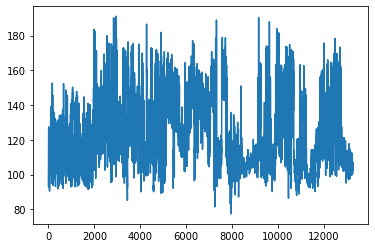

In [ ]:
plt.plot(y_hat_9)
plt.show()

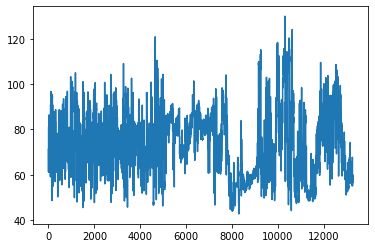

In [ ]:
plt.plot(DT)
plt.show()

In [ ]:
# Well test 10

las = lasio.read('/content/drive/MyDrive/Leaderboard/3369b6f8fb6f_TGS.las')
lat = las.well['SLAT'].value
long =las.well['SLON'].value

data = las.df()
#data = data.fillna(data.mean())
data = data.interpolate()

GR = (data['GRR'].values+data['GRD'].values+data['GRS'].values)/3.0 # Eliminate where GR, DENS, and NEUT is NaN
GR = signal.medfilt(GR,11)
window = 13 # the length of filter is 13 samples or ~ 2 metres
gr_sm = np.median(rolling_window(GR,window), -1)
gr_sm = np.pad(gr_sm, int(window/2), mode='edge')
GR = despike(GR, gr_sm, max_clip = 10)
GR = np.reshape(np.array(GR),(GR.shape[0],1))
DENS = data['RHOB'].values # Eliminate where GR, DENS, and NEUT is NaN ?
DENS = signal.medfilt(DENS,11)
window = 13 # the length of filter is 13 samples or ~ 2 metres
rho_sm = np.median(rolling_window(DENS,window), -1)
rho_sm = np.pad(rho_sm, int(window/2), mode='edge')
DENS = despike(DENS, rho_sm, max_clip = 0.1)

DENS = np.reshape(np.array(DENS),(DENS.shape[0],1))
NEUT = data['NPHI_LS'].values # Eliminate where GR, DENS, and NEUT is NaN
NEUT = signal.medfilt(NEUT,11)
window = 13 # the length of filter is 13 samples or ~ 2 metres
neut_sm = np.median(rolling_window(NEUT,window), -1)
neut_sm = np.pad(neut_sm, int(window/2), mode='edge')
NEUT = despike(NEUT, neut_sm, max_clip = 0.1)
NEUT = np.reshape(np.array(NEUT),(NEUT.shape[0],1))
DT = data['DTCO'].values # Eliminate where GR, DENS, and NEUT is NaN
window = 13 # the length of filter is 13 samples or ~ 2 metres
dt_sm = np.median(rolling_window(DT,window), -1)
dt_sm = np.pad(dt_sm, int(window/2), mode='edge')
DT = despike(DT, dt_sm, max_clip = 10)
DT = np.reshape(np.array(DT),(DT.shape[0],1))

dat=np.concatenate((GR,DENS,NEUT,DT),axis=1)
arr = np.zeros((len(dat),2),dtype=float)
for i in range(len(dat)):
    arr[i,:]=[lat,long]
dat=np.concatenate((dat,arr),axis=1)

In [ ]:
data

,CAL1R,CALD,CALS,CALSR,DPHI_LS,DRHO,DTCO,GRD,GRR,GRS,LLD,LLS,MSFL,NPHI_LS,PEF,RHOB,TEND,TENR,TENS
DEPT,,,,,,,,,,,,,,,,,,,
2961.0,8.5602,8.9346,8.7044,8.9885,-0.1272,-0.0122,54.0801,9.8467,11.3916,7.6374,261.7472,289.3381,306.3479,-0.0003,5.2632,2.9105,1479.4890,1514.8238,2253.1988
2961.5,8.5948,8.9870,8.7460,9.0424,-0.1318,-0.0134,54.6483,9.0971,12.3863,8.9341,211.2559,235.0291,186.8927,-0.0001,5.3167,2.9173,1479.7488,1515.0494,2253.1988
2962.0,8.6169,9.0695,8.7886,9.0714,-0.1289,-0.0142,56.3880,10.1752,13.0676,11.5908,152.2069,180.7201,123.0859,0.0021,5.4142,2.9177,1478.5747,1515.2751,2253.1988
2962.5,8.6344,9.1633,8.8126,9.1446,-0.1180,-0.0153,57.8296,12.7489,14.2930,14.2475,93.1579,126.4111,97.5890,0.0074,5.3428,2.9071,1471.6647,1515.5007,2253.1988
2963.0,8.6519,9.2894,8.8365,9.2912,-0.1071,-0.0164,58.9231,15.3452,15.8905,16.7218,45.3447,72.1021,67.2604,0.0099,5.2830,2.8943,1464.7546,1515.7264,2253.1988
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3659.0,8.1092,7.9175,7.2122,7.9131,0.0131,0.0021,54.1337,84.6561,70.7848,78.0449,30.3453,36.1755,18.9724,0.0723,2.9805,2.6875,1699.9678,1788.0815,2538.5901
3659.5,8.1133,7.9078,7.1870,7.9345,-0.0124,0.0041,54.2645,69.9640,59.9674,78.0449,35.3256,43.9769,56.7152,0.0561,3.0772,2.7069,1707.9691,1723.7066,2533.7020
3660.0,8.1162,7.9110,7.0518,7.9355,-0.0194,0.0046,54.2185,57.5512,53.0923,78.0449,42.1603,53.4824,94.2186,0.0416,3.0797,2.7189,1697.6108,1633.5353,2528.8138


In [ ]:
W10 = np.array((lat,long))
if np.linalg.norm(Cluster_1-W10) <= np.linalg.norm(Cluster_2-W10):
    dat = scaler1.transform(dat)
    y_hat = model_1.predict(dat)
    y_hat = y_hat.reshape(-1,1)
    y_hat_10 = scaler3.inverse_transform(y_hat)
else:
    dat = scaler2.transform(dat)
    y_hat = model_2.predict(dat)
    y_hat = y_hat.reshape(-1,1)
    y_hat_10 = scaler4.inverse_transform(y_hat)

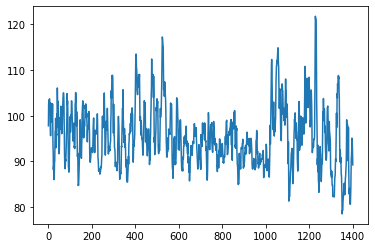

In [ ]:
plt.plot(y_hat_10)
plt.show()

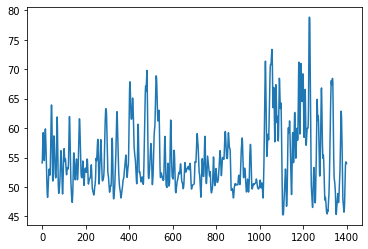

In [ ]:
plt.plot(DT)
plt.show()

In [ ]:
# Well test 11

las = lasio.read('/content/drive/MyDrive/Leaderboard/7595ba9fb314_TGS.las')
lat = las.well['SLAT'].value
long =las.well['SLON'].value

data = las.df()
#data = data.fillna(data.mean())
data = data.interpolate()

GR = (data['GRR'].values+data['GRD'].values+data['GRS'].values)/3.0 # Eliminate where GR, DENS, and NEUT is NaN
GR = signal.medfilt(GR,11)
window = 13 # the length of filter is 13 samples or ~ 2 metres
gr_sm = np.median(rolling_window(GR,window), -1)
gr_sm = np.pad(gr_sm, int(window/2), mode='edge')
GR = despike(GR, gr_sm, max_clip = 10)
GR = np.reshape(np.array(GR),(GR.shape[0],1))
DENS = data['RHOB'].values # Eliminate where GR, DENS, and NEUT is NaN ?
DENS = signal.medfilt(DENS,11)
window = 13 # the length of filter is 13 samples or ~ 2 metres
rho_sm = np.median(rolling_window(DENS,window), -1)
rho_sm = np.pad(rho_sm, int(window/2), mode='edge')
DENS = despike(DENS, rho_sm, max_clip = 0.1)

DENS = np.reshape(np.array(DENS),(DENS.shape[0],1))
NEUT = data['NPHI'].values # Eliminate where GR, DENS, and NEUT is NaN
NEUT = signal.medfilt(NEUT,11)
window = 13 # the length of filter is 13 samples or ~ 2 metres
neut_sm = np.median(rolling_window(NEUT,window), -1)
neut_sm = np.pad(neut_sm, int(window/2), mode='edge')
NEUT = despike(NEUT, neut_sm, max_clip = 0.1)
NEUT = np.reshape(np.array(NEUT),(NEUT.shape[0],1))
DT = data['DTCO'].values # Eliminate where GR, DENS, and NEUT is NaN
window = 13 # the length of filter is 13 samples or ~ 2 metres
dt_sm = np.median(rolling_window(DT,window), -1)
dt_sm = np.pad(dt_sm, int(window/2), mode='edge')
DT = despike(DT, dt_sm, max_clip = 10)
DT = np.reshape(np.array(DT),(DT.shape[0],1))

dat=np.concatenate((GR,DENS,NEUT,DT),axis=1)
arr = np.zeros((len(dat),2),dtype=float)
for i in range(len(dat)):
    arr[i,:]=[lat,long]
dat=np.concatenate((dat,arr),axis=1)

In [ ]:
data

,GRS,DTCO,TENS,GRR,SPR,TENR,SFLU,ILD,ILM,GRD,CALD,RHOB,PEF,DRHO,TEND,NPHI
DEPT,,,,,,,,,,,,,,,,
10398.0,78.881,57.365,3213.5730,120.246,-21.821,4486.6211,3.647,2.894,2.894,122.867,8.703,2.564,4.215,0.003,4474.9868,0.475
10398.5,78.881,57.365,3213.5730,120.225,-21.787,4487.9058,3.392,2.894,2.894,124.074,8.663,2.537,4.283,0.005,4480.2192,0.507
10399.0,78.881,57.365,3213.5730,117.041,-21.757,4489.1909,3.288,2.994,2.994,120.549,8.621,2.536,4.229,0.010,4485.4512,0.498
10399.5,78.881,57.365,3213.5730,111.869,-21.481,4490.4761,3.288,3.180,3.180,116.829,8.582,2.562,4.153,0.015,4490.6831,0.489
10400.0,78.881,57.365,3213.5730,106.318,-21.121,4491.7612,3.601,3.376,3.376,113.971,8.540,2.587,4.067,0.020,4495.9160,0.427
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11342.0,67.793,82.986,3413.1741,136.800,-3.668,4996.8428,5.767,4.029,4.040,141.730,7.927,2.644,4.040,0.048,5166.9941,0.299
11342.5,67.793,82.116,3413.1741,135.659,-3.864,4997.4331,5.432,3.936,3.964,145.774,7.920,2.650,4.150,0.056,5156.5161,0.295
11343.0,67.793,82.427,3413.1741,131.684,-4.059,4998.0229,5.093,3.846,3.889,144.529,7.913,2.651,4.285,0.064,5145.4268,0.296


In [ ]:
W11 = np.array((lat,long))
if np.linalg.norm(Cluster_1-W11) <= np.linalg.norm(Cluster_2-W11):
    dat = scaler1.transform(dat)
    y_hat = model_1.predict(dat)
    y_hat = y_hat.reshape(-1,1)
    y_hat_11 = scaler3.inverse_transform(y_hat)
else:
    dat = scaler2.transform(dat)
    y_hat = model_2.predict(dat)
    y_hat = y_hat.reshape(-1,1)
    y_hat_11 = scaler4.inverse_transform(y_hat)

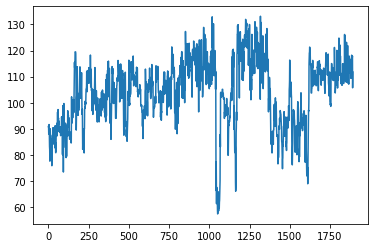

In [ ]:
plt.plot(y_hat_11)
plt.show()

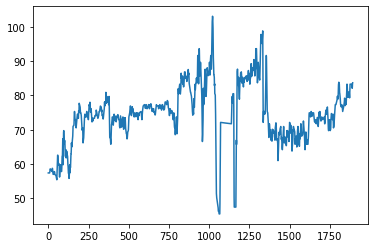

In [ ]:
plt.plot(DT)
plt.show()

In [ ]:
# Well test 12

las = lasio.read('/content/drive/MyDrive/Leaderboard/63250f7d463b_TGS.las')
lat = las.well['SLAT'].value
long =las.well['SLON'].value

data = las.df()
#data = data.fillna(data.mean())
data = data.interpolate()

GR = data['GRS'].values # Eliminate where GR, DENS, and NEUT is NaN
GR = signal.medfilt(GR,11)
window = 13 # the length of filter is 13 samples or ~ 2 metres
gr_sm = np.median(rolling_window(GR,window), -1)
gr_sm = np.pad(gr_sm, int(window/2), mode='edge')
GR = despike(GR, gr_sm, max_clip = 10)
GR = np.reshape(np.array(GR),(GR.shape[0],1))
DENS = data['RHOB'].values # Eliminate where GR, DENS, and NEUT is NaN ?
DENS = signal.medfilt(DENS,11)
window = 13 # the length of filter is 13 samples or ~ 2 metres
rho_sm = np.median(rolling_window(DENS,window), -1)
rho_sm = np.pad(rho_sm, int(window/2), mode='edge')
DENS = despike(DENS, rho_sm, max_clip = 0.1)

DENS = np.reshape(np.array(DENS),(DENS.shape[0],1))
NEUT = data['NPHI'].values # Eliminate where GR, DENS, and NEUT is NaN
NEUT = signal.medfilt(NEUT,11)
window = 13 # the length of filter is 13 samples or ~ 2 metres
neut_sm = np.median(rolling_window(NEUT,window), -1)
neut_sm = np.pad(neut_sm, int(window/2), mode='edge')
NEUT = despike(NEUT, neut_sm, max_clip = 0.1)
NEUT = np.reshape(np.array(NEUT),(NEUT.shape[0],1))
DT = data['DTCO'].values # Eliminate where GR, DENS, and NEUT is NaN
window = 13 # the length of filter is 13 samples or ~ 2 metres
dt_sm = np.median(rolling_window(DT,window), -1)
dt_sm = np.pad(dt_sm, int(window/2), mode='edge')
DT = despike(DT, dt_sm, max_clip = 10)
DT = np.reshape(np.array(DT),(DT.shape[0],1))

dat=np.concatenate((GR,DENS,NEUT,DT),axis=1)
arr = np.zeros((len(dat),2),dtype=float)
for i in range(len(dat)):
    arr[i,:]=[lat,long]
dat=np.concatenate((dat,arr),axis=1)

In [ ]:
data

,CALD,NPHI,DPHI,PEF,DRHO,RHOB,SPR,ILD,ILM,SFLU,GRS,DTCO,DTST
DEPT,,,,,,,,,,,,,
5241.0,NaN,0.2775,NaN,6.5248,NaN,NaN,-75.8252,2000.0000,2000.0000,0.2000,29.9834,NaN,NaN
5241.5,8.8372,0.3126,0.2135,8.1880,-0.0093,2.7636,-76.4198,279.8688,135.7065,0.2000,29.3893,53.2616,212.5477
5242.0,8.5544,0.3023,0.2402,9.1796,-0.0153,2.9059,-77.4827,54.6863,440.3126,0.2740,30.1466,53.6450,213.5974
5242.5,7.8678,0.3030,0.2834,9.8258,-0.0303,2.9995,-78.1924,47.4479,301.8137,0.7885,34.3582,53.7931,213.1454
5243.0,7.2709,0.2626,0.3024,9.9616,-0.0378,2.9979,-78.6148,388.9121,871.7139,5.2242,37.6681,53.1934,211.4923
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12180.0,8.3767,0.0055,0.0045,4.6999,-0.0102,2.5136,-101.4191,1803.8805,1705.5511,1824.7322,33.6900,88.4787,203.1446
12180.5,8.3613,0.0055,0.0060,4.9108,-0.0094,2.5136,-102.3383,1732.7635,1875.7690,1953.3624,33.6900,86.4331,202.9875
12181.0,8.3483,0.0055,0.0075,5.1367,-0.0086,2.5136,-103.3766,1493.0460,1961.0082,1532.7422,33.6900,85.5269,203.1300


In [ ]:
W12 = np.array((lat,long))
if np.linalg.norm(Cluster_1-W12) <= np.linalg.norm(Cluster_2-W12):
    dat = scaler1.transform(dat)
    y_hat = model_1.predict(dat)
    y_hat = y_hat.reshape(-1,1)
    y_hat_12 = scaler3.inverse_transform(y_hat)
else:
    dat = scaler2.transform(dat)
    y_hat = model_2.predict(dat)
    y_hat = y_hat.reshape(-1,1)
    y_hat_12 = scaler4.inverse_transform(y_hat)

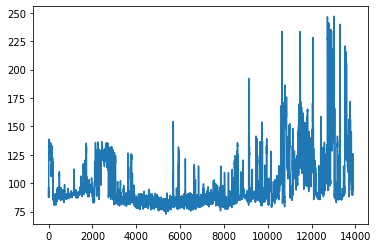

In [ ]:
plt.plot(y_hat_12)
plt.show()

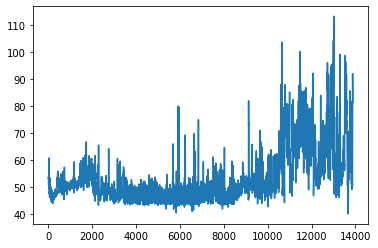

In [ ]:
plt.plot(DT)
plt.show()

In [ ]:
# Well test 13

las = lasio.read('/content/drive/MyDrive/Leaderboard/113412eec2a6_TGS.las')
lat = las.well['SLAT'].value
long =las.well['SLON'].value

data = las.df()
#data = data.fillna(data.mean())
data = data.interpolate()

GR = data['GRR'].values # Eliminate where GR, DENS, and NEUT is NaN
GR = signal.medfilt(GR,11)
window = 13 # the length of filter is 13 samples or ~ 2 metres
gr_sm = np.median(rolling_window(GR,window), -1)
gr_sm = np.pad(gr_sm, int(window/2), mode='edge')
GR = despike(GR, gr_sm, max_clip = 10)
GR = np.reshape(np.array(GR),(GR.shape[0],1))
DENS = data['RHOB'].values # Eliminate where GR, DENS, and NEUT is NaN ?
DENS = signal.medfilt(DENS,11)
window = 13 # the length of filter is 13 samples or ~ 2 metres
rho_sm = np.median(rolling_window(DENS,window), -1)
rho_sm = np.pad(rho_sm, int(window/2), mode='edge')
DENS = despike(DENS, rho_sm, max_clip = 0.1)

DENS = np.reshape(np.array(DENS),(DENS.shape[0],1))
NEUT = data['NPHI'].values # Eliminate where GR, DENS, and NEUT is NaN
NEUT = signal.medfilt(NEUT,11)
window = 13 # the length of filter is 13 samples or ~ 2 metres
neut_sm = np.median(rolling_window(NEUT,window), -1)
neut_sm = np.pad(neut_sm, int(window/2), mode='edge')
NEUT = despike(NEUT, neut_sm, max_clip = 0.1)
NEUT = np.reshape(np.array(NEUT),(NEUT.shape[0],1))
DT = data['DTCO'].values # Eliminate where GR, DENS, and NEUT is NaN
window = 13 # the length of filter is 13 samples or ~ 2 metres
dt_sm = np.median(rolling_window(DT,window), -1)
dt_sm = np.pad(dt_sm, int(window/2), mode='edge')
DT = despike(DT, dt_sm, max_clip = 10)
DT = np.reshape(np.array(DT),(DT.shape[0],1))

dat=np.concatenate((GR,DENS,NEUT,DT),axis=1)
arr = np.zeros((len(dat),2),dtype=float)
for i in range(len(dat)):
    arr[i,:]=[lat,long]
dat=np.concatenate((dat,arr),axis=1)

In [ ]:
data

,SPR,ILD,ILM,GRR,CILD,DTCO,PEF,RHOB,DRHO,DPHI,NPHI,SFL
DEPT,,,,,,,,,,,,
5000.0,-72.2748,2.4415,2.9490,60.7090,NaN,82.0401,NaN,NaN,NaN,NaN,NaN,3.3210
5000.5,-72.0094,2.4028,3.8094,65.9077,NaN,81.7476,NaN,NaN,NaN,NaN,NaN,4.1722
5001.0,-71.0984,2.4028,4.9310,72.2684,NaN,80.6990,NaN,NaN,NaN,NaN,NaN,5.3198
5001.5,-70.5518,2.4473,5.9885,77.1485,NaN,79.7359,NaN,NaN,NaN,NaN,NaN,6.5570
5002.0,-71.0551,2.6012,7.0463,76.1521,NaN,78.7728,NaN,NaN,NaN,NaN,NaN,7.3595
...,...,...,...,...,...,...,...,...,...,...,...,...
11420.5,-12.7672,1732.0214,867.9210,18.6516,NaN,47.1984,4.6466,2.7314,-0.0015,-0.0127,0.0045,2000.0000
11421.0,-11.1095,1910.3356,890.6668,19.2449,NaN,47.5876,4.6871,2.7271,-0.0008,-0.0096,0.0027,2000.0000
11421.5,-8.9185,1910.3356,906.3063,20.0298,NaN,50.6926,4.7170,2.7279,0.0000,-0.0080,0.0057,2000.0000


In [ ]:
W13 = np.array((lat,long))
if np.linalg.norm(Cluster_1-W13) <= np.linalg.norm(Cluster_2-W13):
    dat = scaler1.transform(dat)
    y_hat = model_1.predict(dat)
    y_hat = y_hat.reshape(-1,1)
    y_hat_13 = scaler3.inverse_transform(y_hat)
else:
    dat = scaler2.transform(dat)
    y_hat = model_2.predict(dat)
    y_hat = y_hat.reshape(-1,1)
    y_hat_13 = scaler4.inverse_transform(y_hat)

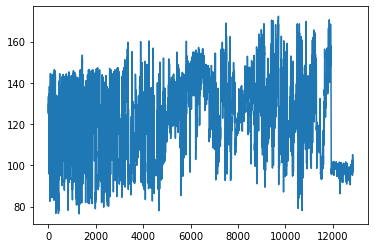

In [ ]:
plt.plot(y_hat_13)
plt.show()

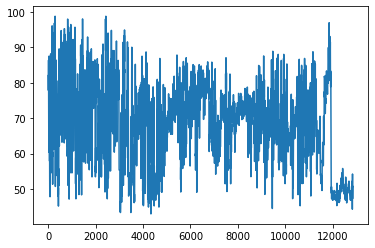

In [ ]:
plt.plot(DT)
plt.show()

In [ ]:
# Well test 14

las = lasio.read('/content/drive/MyDrive/Leaderboard/302460e3021a_TGS.las')
lat = las.well['SLAT'].value
long =las.well['SLON'].value

data = las.df()
#data = data.fillna(data.mean())
data = data.interpolate()

GR = data['GRR'].values # Eliminate where GR, DENS, and NEUT is NaN
GR = signal.medfilt(GR,11)
window = 13 # the length of filter is 13 samples or ~ 2 metres
gr_sm = np.median(rolling_window(GR,window), -1)
gr_sm = np.pad(gr_sm, int(window/2), mode='edge')
GR = despike(GR, gr_sm, max_clip = 10)
GR = np.reshape(np.array(GR),(GR.shape[0],1))
DENS = data['RHOZ'].values # Eliminate where GR, DENS, and NEUT is NaN ?
DENS = signal.medfilt(DENS,11)
window = 13 # the length of filter is 13 samples or ~ 2 metres
rho_sm = np.median(rolling_window(DENS,window), -1)
rho_sm = np.pad(rho_sm, int(window/2), mode='edge')
DENS = despike(DENS, rho_sm, max_clip = 0.1)

DENS = np.reshape(np.array(DENS),(DENS.shape[0],1))
NEUT = data['NPHI_LS'].values # Eliminate where GR, DENS, and NEUT is NaN
NEUT = signal.medfilt(NEUT,11)
window = 13 # the length of filter is 13 samples or ~ 2 metres
neut_sm = np.median(rolling_window(NEUT,window), -1)
neut_sm = np.pad(neut_sm, int(window/2), mode='edge')
NEUT = despike(NEUT, neut_sm, max_clip = 0.1)
NEUT = np.reshape(np.array(NEUT),(NEUT.shape[0],1))
DT = data['DTCO'].values # Eliminate where GR, DENS, and NEUT is NaN
window = 13 # the length of filter is 13 samples or ~ 2 metres
dt_sm = np.median(rolling_window(DT,window), -1)
dt_sm = np.pad(dt_sm, int(window/2), mode='edge')
DT = despike(DT, dt_sm, max_clip = 10)
DT = np.reshape(np.array(DT),(DT.shape[0],1))

dat=np.concatenate((GR,DENS,NEUT,DT),axis=1)
arr = np.zeros((len(dat),2),dtype=float)
for i in range(len(dat)):
    arr[i,:]=[lat,long]
dat=np.concatenate((dat,arr),axis=1)

In [ ]:
data

,DTCO,RHOZ,DPHZ_LS,NPHI_LS,PEFZ,HCALD,HDRA,SPR,AT10,AT30,AT90,GRR
DEPT,,,,,,,,,,,,
586.0,86.9076,NaN,0.1941,0.2900,2.6737,11.4332,0.1359,-20.6767,0.8022,0.8974,1.4655,56.5540
586.5,96.7415,NaN,0.2686,0.3362,2.7753,10.9471,0.0931,-20.6659,0.7969,0.8983,1.4760,59.9667
587.0,105.1219,NaN,0.3089,0.3817,2.8356,10.6142,0.0354,-20.6570,0.7916,0.8992,1.4660,65.4160
587.5,106.2516,NaN,0.3272,0.3973,2.9110,10.2057,0.0264,-20.6481,0.7809,0.9001,1.4362,72.6780
588.0,105.7222,NaN,0.3263,0.3832,2.9412,9.6460,0.0257,-20.6391,0.7690,0.9010,1.3590,81.7526
...,...,...,...,...,...,...,...,...,...,...,...,...
6064.0,60.5304,2.6129,0.0571,0.0790,4.5261,7.5323,0.0423,-32.5304,8.5269,14.1393,9.9660,34.2774
6064.5,58.6059,2.6137,0.0480,0.0820,4.5258,7.5320,0.0484,-32.5244,14.0279,19.4528,23.0275,33.1651
6065.0,59.3217,2.6415,0.0360,0.0837,4.4954,7.5770,0.0514,-32.5185,14.6257,14.3368,31.6649,32.2785


In [ ]:
W14 = np.array((lat,long))
if np.linalg.norm(Cluster_1-W14) <= np.linalg.norm(Cluster_2-W14):
    dat = scaler1.transform(dat)
    y_hat = model_1.predict(dat)
    y_hat = y_hat.reshape(-1,1)
    y_hat_14 = scaler3.inverse_transform(y_hat)
else:
    dat = scaler2.transform(dat)
    y_hat = model_2.predict(dat)
    y_hat = y_hat.reshape(-1,1)
    y_hat_14 = scaler4.inverse_transform(y_hat)

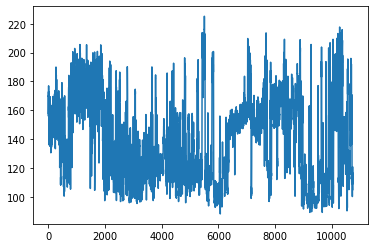

In [ ]:
plt.plot(y_hat_14)
plt.show()

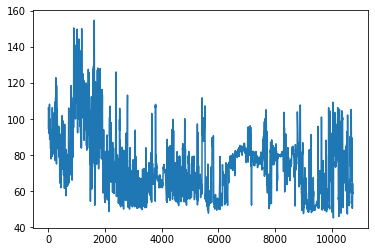

In [ ]:
plt.plot(DT)
plt.show()

In [ ]:
# Well test 15

las = lasio.read('/content/drive/MyDrive/Leaderboard/20372701d5e2_TGS.las')
lat = las.well['SLAT'].value
long =las.well['SLON'].value

data = las.df()
#data = data.fillna(data.mean())
data = data.interpolate()

GR = data['GRR'].values # Eliminate where GR, DENS, and NEUT is NaN
GR = signal.medfilt(GR,11)
window = 13 # the length of filter is 13 samples or ~ 2 metres
gr_sm = np.median(rolling_window(GR,window), -1)
gr_sm = np.pad(gr_sm, int(window/2), mode='edge')
GR = despike(GR, gr_sm, max_clip = 10)
GR = np.reshape(np.array(GR),(GR.shape[0],1))
DENS = data['RHOZ'].values # Eliminate where GR, DENS, and NEUT is NaN ?
DENS = signal.medfilt(DENS,11)
window = 13 # the length of filter is 13 samples or ~ 2 metres
rho_sm = np.median(rolling_window(DENS,window), -1)
rho_sm = np.pad(rho_sm, int(window/2), mode='edge')
DENS = despike(DENS, rho_sm, max_clip = 0.1)

DENS = np.reshape(np.array(DENS),(DENS.shape[0],1))
NEUT = data['NPHI_LS'].values # Eliminate where GR, DENS, and NEUT is NaN
NEUT = signal.medfilt(NEUT,11)
window = 13 # the length of filter is 13 samples or ~ 2 metres
neut_sm = np.median(rolling_window(NEUT,window), -1)
neut_sm = np.pad(neut_sm, int(window/2), mode='edge')
NEUT = despike(NEUT, neut_sm, max_clip = 0.1)
NEUT = np.reshape(np.array(NEUT),(NEUT.shape[0],1))
DT = data['DTCO'].values # Eliminate where GR, DENS, and NEUT is NaN
window = 13 # the length of filter is 13 samples or ~ 2 metres
dt_sm = np.median(rolling_window(DT,window), -1)
dt_sm = np.pad(dt_sm, int(window/2), mode='edge')
DT = despike(DT, dt_sm, max_clip = 10)
DT = np.reshape(np.array(DT),(DT.shape[0],1))

dat=np.concatenate((GR,DENS,NEUT,DT),axis=1)
arr = np.zeros((len(dat),2),dtype=float)
for i in range(len(dat)):
    arr[i,:]=[lat,long]
dat=np.concatenate((dat,arr),axis=1)

In [ ]:
data

,AT90,DPHZ_LS,NPHI_LS,HCALD,HDRA,PEFZ,RHOZ,DPO,DRH,LCALR,PEFL,RHOM,AT20,AT30,AT60,GRR,SPR,AHFCO60,DTCO
DEPT,,,,,,,,,,,,,,,,,,,
13105.0,2.9864,0.074,0.3007,8.0923,NaN,3.984,2.5836,NaN,-0.1304,4.8001,NaN,NaN,3.2329,2.4750,2.6125,70.7036,-0.1430,NaN,124.0252
13105.5,2.9864,0.074,0.3007,8.0923,NaN,3.984,2.5836,NaN,-0.0453,4.7985,NaN,NaN,3.2580,2.4741,2.5945,73.7563,1.7125,NaN,111.5703
13106.0,2.9864,0.074,0.3007,8.0923,NaN,3.984,2.5836,NaN,-0.0191,4.7969,NaN,NaN,3.2833,2.4733,2.5766,75.4523,2.9749,NaN,109.1775
13106.5,2.9864,0.074,0.3007,8.0923,NaN,3.984,2.5836,NaN,-0.0085,4.7953,NaN,NaN,3.2826,2.4725,2.5589,75.9056,3.7897,NaN,108.1797
13107.0,2.9864,0.074,0.3007,8.0923,NaN,3.984,2.5836,0.2996,-0.0099,4.7938,10.0008,NaN,3.2777,2.4716,2.5413,75.8939,4.3763,NaN,107.2757
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14176.0,2.9864,0.074,0.3010,8.0923,NaN,3.984,2.5836,0.0300,0.0217,4.3564,9.9974,2.6594,2.0386,2.0958,2.1490,121.7436,6.5218,NaN,90.4112
14176.5,2.9864,0.074,0.3010,8.0923,NaN,3.984,2.5836,0.0312,0.0211,4.3699,9.9974,2.6566,2.0386,2.0958,2.1490,121.7436,6.1996,NaN,90.4127
14177.0,2.9864,0.074,0.3010,8.0923,NaN,3.984,2.5836,0.0307,0.0242,4.3611,9.9974,2.6605,2.0386,2.0958,2.1490,121.7436,6.0508,NaN,90.4141


In [ ]:
W15 = np.array((lat,long))
if np.linalg.norm(Cluster_1-W15) <= np.linalg.norm(Cluster_2-W15):
    dat = scaler1.transform(dat)
    y_hat = model_1.predict(dat)
    y_hat = y_hat.reshape(-1,1)
    y_hat_15 = scaler3.inverse_transform(y_hat)
else:
    dat = scaler2.transform(dat)
    y_hat = model_2.predict(dat)
    y_hat = y_hat.reshape(-1,1)
    y_hat_15 = scaler4.inverse_transform(y_hat)

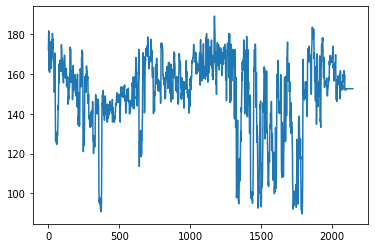

In [ ]:
plt.plot(y_hat_15)
plt.show()

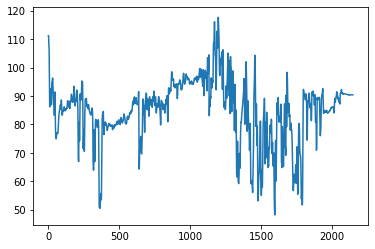

In [ ]:
plt.plot(DT)
plt.show()

In [ ]:
# Well test 16

las = lasio.read('/content/drive/MyDrive/Leaderboard/ae16a9f64878_TGS.las')
lat = las.well['SLAT'].value
long =las.well['SLON'].value

data = las.df()
#data = data.fillna(data.mean())
data = data.interpolate()

GR = data['GRR'].values # Eliminate where GR, DENS, and NEUT is NaN
GR = signal.medfilt(GR,11)
window = 13 # the length of filter is 13 samples or ~ 2 metres
gr_sm = np.median(rolling_window(GR,window), -1)
gr_sm = np.pad(gr_sm, int(window/2), mode='edge')
GR = despike(GR, gr_sm, max_clip = 10)
GR = np.reshape(np.array(GR),(GR.shape[0],1))
DENS = (data['RHOZ'].values+data['RHOB'].values)/2.0 # Eliminate where GR, DENS, and NEUT is NaN ?
DENS = signal.medfilt(DENS,11)
window = 13 # the length of filter is 13 samples or ~ 2 metres
rho_sm = np.median(rolling_window(DENS,window), -1)
rho_sm = np.pad(rho_sm, int(window/2), mode='edge')
DENS = despike(DENS, rho_sm, max_clip = 0.1)

DENS = np.reshape(np.array(DENS),(DENS.shape[0],1))
NEUT = data['NPHI_LS'].values # Eliminate where GR, DENS, and NEUT is NaN
NEUT = signal.medfilt(NEUT,11)
window = 13 # the length of filter is 13 samples or ~ 2 metres
neut_sm = np.median(rolling_window(NEUT,window), -1)
neut_sm = np.pad(neut_sm, int(window/2), mode='edge')
NEUT = despike(NEUT, neut_sm, max_clip = 0.1)
NEUT = np.reshape(np.array(NEUT),(NEUT.shape[0],1))
DT = data['DTCO'].values # Eliminate where GR, DENS, and NEUT is NaN
window = 13 # the length of filter is 13 samples or ~ 2 metres
dt_sm = np.median(rolling_window(DT,window), -1)
dt_sm = np.pad(dt_sm, int(window/2), mode='edge')
DT = despike(DT, dt_sm, max_clip = 10)
DT = np.reshape(np.array(DT),(DT.shape[0],1))

dat=np.concatenate((GR,DENS,NEUT,DT),axis=1)
arr = np.zeros((len(dat),2),dtype=float)
for i in range(len(dat)):
    arr[i,:]=[lat,long]
dat=np.concatenate((dat,arr),axis=1)

In [ ]:
data

,AHT10,AHT30,AHT90,CALD,DPHI_LS,DPHZ_LS,DPO_LS,DRH,DRHO,DTCO,DTOP,DTOS,GRR,HCALD,HCALR,HDRA,ILD,ILM,LCALD,NPHI_LS,PEFL,PEFZ,RHOB,RHOM,RHOZ,SFLU,SPR
DEPT,,,,,,,,,,,,,,,,,,,,,,,,,,,
5460.0,1.2305,2.6056,3.3080,NaN,NaN,NaN,NaN,NaN,NaN,102.6857,NaN,NaN,42.8367,NaN,15.5187,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-103.4477
5460.5,1.2339,2.6056,3.3433,NaN,NaN,NaN,NaN,NaN,NaN,101.9844,NaN,NaN,42.3115,NaN,17.0709,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-104.7230
5461.0,1.2382,2.6055,3.3775,NaN,NaN,NaN,NaN,NaN,NaN,99.5611,NaN,NaN,43.4643,NaN,15.2643,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-104.7433
5461.5,1.2424,2.6055,3.4070,NaN,NaN,NaN,NaN,NaN,NaN,99.3121,NaN,NaN,45.4581,NaN,15.0706,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-104.4986
5462.0,1.2467,2.6055,3.4365,NaN,NaN,NaN,NaN,NaN,NaN,98.2200,NaN,NaN,48.0830,NaN,15.8954,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-103.4347
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16614.0,9.8581,18.0612,28.2013,11.3934,0.0387,0.0483,0.0532,0.0001,-0.0124,88.5985,93.1863,128.6530,67.4058,12.4408,11.8754,0.0566,1.5763,1.6413,11.1126,0.2208,NaN,9.9972,2.6602,2.6229,2.6184,1.9521,-0.8552
16614.5,9.8581,18.0612,28.2013,11.3934,0.0387,0.0483,0.0545,0.0001,-0.0124,88.8664,93.8421,132.4008,66.9660,12.4408,11.8754,0.0566,1.5782,1.6648,11.0806,0.2083,NaN,9.9972,2.6602,2.6210,2.6184,1.9889,-0.8636
16615.0,9.8581,18.0612,28.2013,11.3934,0.0387,0.0483,0.0544,0.0001,-0.0124,90.9089,92.4951,136.1493,68.5667,12.4408,11.8754,0.0566,1.6066,1.6930,11.0486,0.1920,NaN,9.9972,2.6602,2.6194,2.6184,2.0208,-0.8745


In [ ]:
W16 = np.array((lat,long))
if np.linalg.norm(Cluster_1-W16) <= np.linalg.norm(Cluster_2-W16):
    dat = scaler1.transform(dat)
    y_hat = model_1.predict(dat)
    y_hat = y_hat.reshape(-1,1)
    y_hat_16 = scaler3.inverse_transform(y_hat)
else:
    dat = scaler2.transform(dat)
    y_hat = model_2.predict(dat)
    y_hat = y_hat.reshape(-1,1)
    y_hat_16 = scaler4.inverse_transform(y_hat)

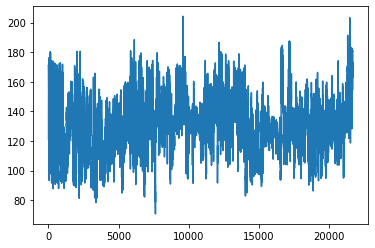

In [ ]:
plt.plot(y_hat_16)
plt.show()

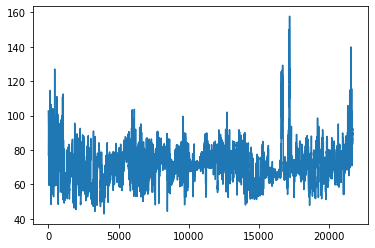

In [ ]:
plt.plot(DT)
plt.show()

In [ ]:
# Well test 17

las = lasio.read('/content/drive/MyDrive/Leaderboard/ed48bda2217f_TGS.las')
lat = las.well['SLAT'].value
long =las.well['SLON'].value

data = las.df()
#data = data.fillna(data.mean())
data = data.interpolate()

GR = data['GRR'].values # Eliminate where GR, DENS, and NEUT is NaN
GR = signal.medfilt(GR,11)
window = 13 # the length of filter is 13 samples or ~ 2 metres
gr_sm = np.median(rolling_window(GR,window), -1)
gr_sm = np.pad(gr_sm, int(window/2), mode='edge')
GR = despike(GR, gr_sm, max_clip = 10)
GR = np.reshape(np.array(GR),(GR.shape[0],1))
DENS = data['RHOZ'].values # Eliminate where GR, DENS, and NEUT is NaN ?
DENS = signal.medfilt(DENS,11)
window = 13 # the length of filter is 13 samples or ~ 2 metres
rho_sm = np.median(rolling_window(DENS,window), -1)
rho_sm = np.pad(rho_sm, int(window/2), mode='edge')
DENS = despike(DENS, rho_sm, max_clip = 0.1)

DENS = np.reshape(np.array(DENS),(DENS.shape[0],1))
NEUT = data['NPHI'].values # Eliminate where GR, DENS, and NEUT is NaN
NEUT = signal.medfilt(NEUT,11)
window = 13 # the length of filter is 13 samples or ~ 2 metres
neut_sm = np.median(rolling_window(NEUT,window), -1)
neut_sm = np.pad(neut_sm, int(window/2), mode='edge')
NEUT = despike(NEUT, neut_sm, max_clip = 0.1)
NEUT = np.reshape(np.array(NEUT),(NEUT.shape[0],1))
DT = data['DTCO'].values # Eliminate where GR, DENS, and NEUT is NaN
window = 13 # the length of filter is 13 samples or ~ 2 metres
dt_sm = np.median(rolling_window(DT,window), -1)
dt_sm = np.pad(dt_sm, int(window/2), mode='edge')
DT = despike(DT, dt_sm, max_clip = 10)
DT = np.reshape(np.array(DT),(DT.shape[0],1))

dat=np.concatenate((GR,DENS,NEUT,DT),axis=1)
arr = np.zeros((len(dat),2),dtype=float)
for i in range(len(dat)):
    arr[i,:]=[lat,long]
dat=np.concatenate((dat,arr),axis=1)

In [ ]:
data

,GRR,SPR,AT20,AT30,AT60,AF20,AF60,AFCO,DTCO,HCAL,PEFZ,HDRA,RHOZ,DPHZ,PEF,DPHI,DRHO,RHOB,CALD,NPHI
DEPT,,,,,,,,,,,,,,,,,,,,
3085.0,39.4887,-66.3933,NaN,NaN,NaN,0.0000,0.6607,897.4763,75.1053,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3085.5,45.5689,-79.3386,NaN,NaN,NaN,0.0025,0.6634,895.9982,75.2554,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3086.0,49.6625,-86.8938,NaN,NaN,NaN,0.0049,0.6664,891.8267,76.0030,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3086.5,50.4187,-80.1322,NaN,NaN,NaN,0.0074,0.7696,888.5900,92.6096,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3087.0,48.9277,-66.6515,NaN,NaN,NaN,0.0099,0.8227,876.8627,100.8530,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15153.0,132.6193,-1.8546,2.3745,2.3295,2.3589,8.5095,8.2831,112.2755,94.7159,7.8036,3.1640,0.0941,2.2336,0.2835,NaN,NaN,NaN,NaN,NaN,0.3336
15153.5,129.4589,-1.8606,2.5846,2.3950,2.4255,8.5095,8.2831,112.2755,91.7607,8.1343,3.1951,0.1345,2.2231,0.2804,NaN,NaN,NaN,NaN,NaN,0.3383
15154.0,128.1057,-1.9397,2.7326,2.5311,2.5641,8.5095,8.2831,112.2755,86.1418,8.8867,3.2182,0.1779,2.3046,0.2175,NaN,NaN,NaN,NaN,NaN,0.3360


In [ ]:
W17 = np.array((lat,long))
if np.linalg.norm(Cluster_1-W17) <= np.linalg.norm(Cluster_2-W17):
    dat = scaler1.transform(dat)
    y_hat = model_1.predict(dat)
    y_hat = y_hat.reshape(-1,1)
    y_hat_17 = scaler3.inverse_transform(y_hat)
else:
    dat = scaler2.transform(dat)
    y_hat = model_2.predict(dat)
    y_hat = y_hat.reshape(-1,1)
    y_hat_17 = scaler4.inverse_transform(y_hat)

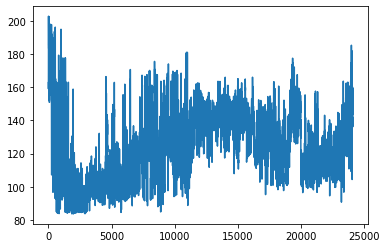

In [ ]:
plt.plot(y_hat_17)
plt.show()

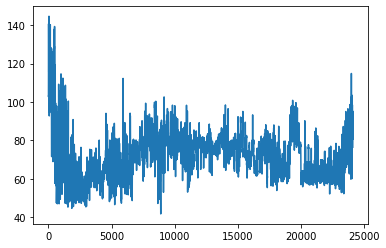

In [ ]:
plt.plot(DT)
plt.show()

In [ ]:
# Well test 18

las = lasio.read('/content/drive/MyDrive/Leaderboard/eed1e9537976_TGS.las')
lat = las.well['SLAT'].value
long =las.well['SLON'].value

data = las.df()
#data = data.fillna(data.mean())
data = data.interpolate()



GR = data['GRR'].values # Eliminate where GR, DENS, and NEUT is NaN
GR = signal.medfilt(GR,11)
window = 13 # the length of filter is 13 samples or ~ 2 metres
gr_sm = np.median(rolling_window(GR,window), -1)
gr_sm = np.pad(gr_sm, int(window/2), mode='edge')
GR = despike(GR, gr_sm, max_clip = 10)
GR = np.reshape(np.array(GR),(GR.shape[0],1))
DENS = data['RHOZ'].values # Eliminate where GR, DENS, and NEUT is NaN ?
DENS = signal.medfilt(DENS,11)
window = 13 # the length of filter is 13 samples or ~ 2 metres
rho_sm = np.median(rolling_window(DENS,window), -1)
rho_sm = np.pad(rho_sm, int(window/2), mode='edge')
DENS = despike(DENS, rho_sm, max_clip = 0.1)

DENS = np.reshape(np.array(DENS),(DENS.shape[0],1))
NEUT = data['NPOR_LS'].values # Eliminate where GR, DENS, and NEUT is NaN
NEUT = signal.medfilt(NEUT,11)
window = 13 # the length of filter is 13 samples or ~ 2 metres
neut_sm = np.median(rolling_window(NEUT,window), -1)
neut_sm = np.pad(neut_sm, int(window/2), mode='edge')
NEUT = despike(NEUT, neut_sm, max_clip = 0.1)
NEUT = np.reshape(np.array(NEUT),(NEUT.shape[0],1))
DT = (data['DTCO'].values+data['DT4P'].values)/2.0 # Eliminate where GR, DENS, and NEUT is NaN
window = 13 # the length of filter is 13 samples or ~ 2 metres
dt_sm = np.median(rolling_window(DT,window), -1)
dt_sm = np.pad(dt_sm, int(window/2), mode='edge')
DT = despike(DT, dt_sm, max_clip = 10)
DT = np.reshape(np.array(DT),(DT.shape[0],1))

dat=np.concatenate((GR,DENS,NEUT,DT),axis=1)
arr = np.zeros((len(dat),2),dtype=float)
for i in range(len(dat)):
    arr[i,:]=[lat,long]
dat=np.concatenate((dat,arr),axis=1)

In [ ]:
data

,DPHZ_LS,HCALD,NPOR_LS,PEFZ,HDRA,RHOZ,AT10,AT30,AT90,GRR,SPR,DT4P,DT4S,DTCO,DT2R,DT2
DEPT,,,,,,,,,,,,,,,,
7997.0,0.0952,11.4366,0.2291,3.1835,0.1268,2.5928,8.4732,8.3594,9.5325,89.4327,-39.9863,70.5899,130.6955,70.4597,128.9496,128.2201
7997.5,0.1003,11.3169,0.2396,3.1529,0.1352,2.5636,10.1020,10.0339,9.8606,92.0784,-40.8553,71.1789,130.2095,71.3532,128.9612,128.2317
7998.0,0.0801,11.1179,0.2244,3.1224,0.1195,2.5429,11.8821,12.4580,11.4478,96.4939,-41.5774,71.4718,131.9382,71.6358,128.9731,128.2435
7998.5,0.0633,10.8300,0.2012,3.1212,0.0951,2.5404,13.0619,12.7996,13.8361,100.6226,-42.1231,70.5765,134.4916,70.1030,128.9850,128.2553
7999.0,0.0845,10.3443,0.2104,3.0612,0.0961,2.5563,11.1051,11.8821,12.8388,102.8938,-42.8850,69.0883,132.4070,67.7302,127.8100,127.0899
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9973.0,0.0477,8.6683,0.1754,3.2805,0.0157,2.6318,4.9781,4.8895,5.8705,141.6702,-18.0477,70.6548,140.8933,72.4888,136.3313,137.5148
9973.5,0.0429,8.6392,0.1754,3.3389,0.0059,2.6354,4.4976,4.4774,4.6004,141.6702,-18.6062,70.6548,140.8933,71.5946,136.3313,137.5148
9974.0,0.0425,8.6100,0.1754,3.4553,-0.0029,2.6349,4.6210,4.3284,4.7588,141.6702,-18.9292,70.6548,140.8933,70.4024,136.3313,137.5148


In [ ]:
W18 = np.array((lat,long))
if np.linalg.norm(Cluster_1-W18) <= np.linalg.norm(Cluster_2-W18):
    dat = scaler1.transform(dat)
    y_hat = model_1.predict(dat)
    y_hat = y_hat.reshape(-1,1)
    y_hat_18 = scaler3.inverse_transform(y_hat)
else:
    dat = scaler2.transform(dat)
    y_hat = model_2.predict(dat)
    y_hat = y_hat.reshape(-1,1)
    y_hat_18 = scaler4.inverse_transform(y_hat)

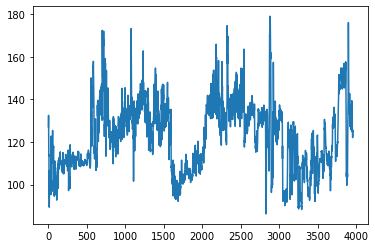

In [ ]:
plt.plot(y_hat_18)
plt.show()

[]

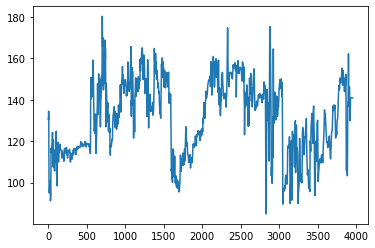

In [ ]:
plt.plot(data['DT4S'].values)
plt.plot()

[]

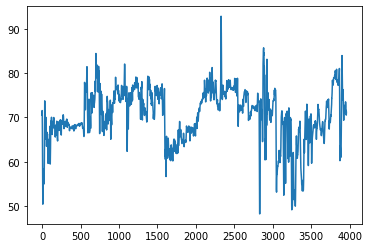

In [ ]:
plt.plot(DT)
plt.plot()

In [ ]:
# Well test 19

las = lasio.read('/content/drive/MyDrive/Leaderboard/fca03aa6acde_TGS.las')
lat = las.well['SLAT'].value
long =las.well['SLON'].value

data = las.df()
#data = data.fillna(data.mean())
data = data.interpolate()



GR = (data['GRR'].values+data['GRD'].values)/2.0 # Eliminate where GR, DENS, and NEUT is NaN
GR = signal.medfilt(GR,11)
window = 13 # the length of filter is 13 samples or ~ 2 metres
gr_sm = np.median(rolling_window(GR,window), -1)
gr_sm = np.pad(gr_sm, int(window/2), mode='edge')
GR = despike(GR, gr_sm, max_clip = 10)
GR = np.reshape(np.array(GR),(GR.shape[0],1))
DENS = data['RHOB'].values # Eliminate where GR, DENS, and NEUT is NaN ?
DENS = signal.medfilt(DENS,11)
window = 13 # the length of filter is 13 samples or ~ 2 metres
rho_sm = np.median(rolling_window(DENS,window), -1)
rho_sm = np.pad(rho_sm, int(window/2), mode='edge')
DENS = despike(DENS, rho_sm, max_clip = 0.1)

DENS = np.reshape(np.array(DENS),(DENS.shape[0],1))
NEUT = data['NPHI_LS'].values # Eliminate where GR, DENS, and NEUT is NaN
NEUT = signal.medfilt(NEUT,11)
window = 13 # the length of filter is 13 samples or ~ 2 metres
neut_sm = np.median(rolling_window(NEUT,window), -1)
neut_sm = np.pad(neut_sm, int(window/2), mode='edge')
NEUT = despike(NEUT, neut_sm, max_clip = 0.1)
NEUT = np.reshape(np.array(NEUT),(NEUT.shape[0],1))
DT = data['DTCO'].values # Eliminate where GR, DENS, and NEUT is NaN
window = 13 # the length of filter is 13 samples or ~ 2 metres
dt_sm = np.median(rolling_window(DT,window), -1)
dt_sm = np.pad(dt_sm, int(window/2), mode='edge')
DT = despike(DT, dt_sm, max_clip = 10)
DT = np.reshape(np.array(DT),(DT.shape[0],1))

dat=np.concatenate((GR,DENS,NEUT,DT),axis=1)
arr = np.zeros((len(dat),2),dtype=float)
for i in range(len(dat)):
    arr[i,:]=[lat,long]
dat=np.concatenate((dat,arr),axis=1)

In [ ]:
data

,GRR,LLD,LLS,MSFL,CALSR,NPHI_LS,GRD,DRHO,DPHI_LS,PEF,RHOB,DTCO
DEPT,,,,,,,,,,,,
10797.0,110.0855,22.8253,22.5343,23.5886,9.1937,0.1370,121.7897,-0.0130,0.0066,3.3119,2.7009,56.8127
10797.5,109.1869,22.5314,22.2441,19.9023,9.1928,0.1435,119.0905,-0.0147,0.0015,3.2848,2.7088,57.0313
10798.0,109.4369,22.2413,21.9577,24.6117,9.1919,0.1494,116.4959,-0.0145,-0.0071,3.2546,2.7212,57.0372
10798.5,110.3845,21.9549,21.6749,19.0391,9.1910,0.1534,115.2020,-0.0131,-0.0115,3.2233,2.7301,57.0430
10799.0,114.1460,21.6722,21.4028,20.3375,9.1901,0.1533,117.8764,-0.0145,-0.0078,3.1831,2.7236,57.0488
...,...,...,...,...,...,...,...,...,...,...,...,...
11527.0,12.3530,6641.4297,2768.1201,488.6901,7.6183,-0.0034,14.8561,-0.0173,0.0193,4.3907,2.6803,52.7585
11527.5,10.7183,12856.5000,3220.1169,1060.1091,7.6217,-0.0046,14.0757,-0.0164,0.0230,4.1885,2.6730,53.2061
11528.0,9.9311,19529.4473,2953.9829,814.1271,7.6223,-0.0051,14.8512,-0.0128,0.0295,4.0292,2.6654,53.6432


In [ ]:
W19 = np.array((lat,long))
if np.linalg.norm(Cluster_1-W19) <= np.linalg.norm(Cluster_2-W19):
    dat = scaler1.transform(dat)
    y_hat = model_1.predict(dat)
    y_hat = y_hat.reshape(-1,1)
    y_hat_19 = scaler3.inverse_transform(y_hat)
else:
    dat = scaler2.transform(dat)
    y_hat = model_2.predict(dat)
    y_hat = y_hat.reshape(-1,1)
    y_hat_19 = scaler4.inverse_transform(y_hat)

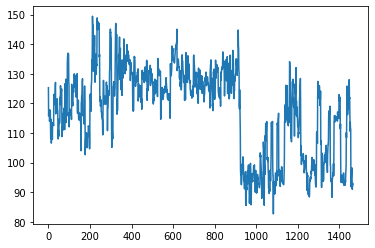

In [ ]:
plt.plot(y_hat_19)
plt.show()

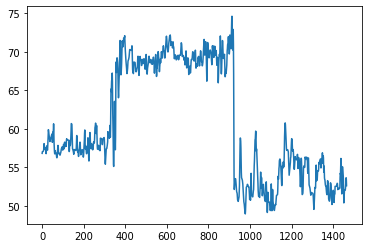

In [ ]:
plt.plot(DT)
plt.show()

In [ ]:
# Well test 20

las = lasio.read('/content/drive/MyDrive/Leaderboard/ff7845ea074d_TGS.las')
lat = las.well['SLAT'].value
long =las.well['SLON'].value

data = las.df()
#data = data.fillna(data.mean())
data = data.interpolate()



GR = (data['GRR'].values+data['GRD'].values+data['GRS'].values)/3.0 # Eliminate where GR, DENS, and NEUT is NaN
GR = signal.medfilt(GR,11)
window = 13 # the length of filter is 13 samples or ~ 2 metres
gr_sm = np.median(rolling_window(GR,window), -1)
gr_sm = np.pad(gr_sm, int(window/2), mode='edge')
GR = despike(GR, gr_sm, max_clip = 10)
GR = np.reshape(np.array(GR),(GR.shape[0],1))
DENS = data['RHOB'].values # Eliminate where GR, DENS, and NEUT is NaN ?
DENS = signal.medfilt(DENS,11)
window = 13 # the length of filter is 13 samples or ~ 2 metres
rho_sm = np.median(rolling_window(DENS,window), -1)
rho_sm = np.pad(rho_sm, int(window/2), mode='edge')
DENS = despike(DENS, rho_sm, max_clip = 0.1)

DENS = np.reshape(np.array(DENS),(DENS.shape[0],1))
NEUT = data['NPHI_LS'].values # Eliminate where GR, DENS, and NEUT is NaN
NEUT = signal.medfilt(NEUT,11)
window = 13 # the length of filter is 13 samples or ~ 2 metres
neut_sm = np.median(rolling_window(NEUT,window), -1)
neut_sm = np.pad(neut_sm, int(window/2), mode='edge')
NEUT = despike(NEUT, neut_sm, max_clip = 0.1)
NEUT = np.reshape(np.array(NEUT),(NEUT.shape[0],1))
DT = data['DTCO'].values # Eliminate where GR, DENS, and NEUT is NaN
window = 13 # the length of filter is 13 samples or ~ 2 metres
dt_sm = np.median(rolling_window(DT,window), -1)
dt_sm = np.pad(dt_sm, int(window/2), mode='edge')
DT = despike(DT, dt_sm, max_clip = 10)
DT = np.reshape(np.array(DT),(DT.shape[0],1))

dat=np.concatenate((GR,DENS,NEUT,DT),axis=1)
arr = np.zeros((len(dat),2),dtype=float)
for i in range(len(dat)):
    arr[i,:]=[lat,long]
dat=np.concatenate((dat,arr),axis=1)

In [ ]:
data

,CALD,CILD,DPHI_LS,DRHO,DTCO,GRD,GRR,GRS,ILD,ILM,NPHI_LS,PEF,RHOB,SFLA,SFLU,SPR,TEND,TENR,TENS
DEPT,,,,,,,,,,,,,,,,,,,
6984.0,NaN,NaN,NaN,NaN,53.2193,NaN,12.2273,8.3856,43.0457,35.3551,NaN,NaN,NaN,NaN,90.6969,-105.9360,NaN,2828.0667,3092.9297
6984.5,NaN,NaN,NaN,NaN,52.4380,NaN,9.8619,9.3071,43.9756,34.5501,NaN,NaN,NaN,NaN,88.4926,-106.2947,NaN,2826.2815,3089.7869
6985.0,NaN,NaN,NaN,NaN,51.6567,NaN,8.9463,9.5639,44.6007,33.7072,NaN,NaN,NaN,NaN,89.2624,-106.8272,NaN,2836.6003,3086.6443
6985.5,NaN,NaN,NaN,NaN,51.4208,NaN,9.1174,9.0939,44.8237,34.0908,NaN,NaN,NaN,NaN,92.5508,-106.7741,NaN,2847.0264,3083.5015
6986.0,NaN,NaN,NaN,NaN,51.2788,NaN,9.1703,8.8256,44.8582,34.3955,NaN,NaN,NaN,NaN,95.8585,-106.7001,NaN,2857.4524,3080.3586
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8817.0,7.7050,NaN,0.0503,0.0539,51.0738,230.6033,236.8992,198.2077,1944.9128,874.5989,0.0100,2.4312,2.6322,NaN,1654.8389,-76.5499,4167.3564,3809.6677,4089.7834
8817.5,7.5904,NaN,0.0623,0.0715,51.6112,230.6022,236.8992,198.2105,1944.9128,874.5989,0.0105,2.4303,2.6145,NaN,1654.8389,-76.5499,4160.8433,3845.6101,4092.9836
8818.0,7.4601,NaN,0.0799,0.0916,51.9350,230.6058,236.8992,198.2134,1944.9128,874.5989,0.0108,2.3676,2.5828,NaN,1654.8389,-76.5499,4166.6270,3755.7061,4058.7727


In [ ]:
W20 = np.array((lat,long))
if np.linalg.norm(Cluster_1-W20) <= np.linalg.norm(Cluster_2-W20):
    dat = scaler1.transform(dat)
    y_hat = model_1.predict(dat)
    y_hat = y_hat.reshape(-1,1)
    y_hat_20 = scaler3.inverse_transform(y_hat)
else:
    dat = scaler2.transform(dat)
    y_hat = model_2.predict(dat)
    y_hat = y_hat.reshape(-1,1)
    y_hat_20 = scaler4.inverse_transform(y_hat)

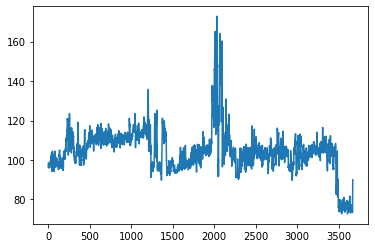

In [ ]:
plt.plot(y_hat_20)
plt.show()

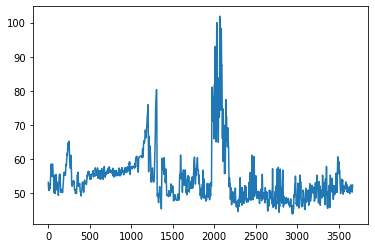

In [ ]:
plt.plot(DT)
plt.show()

In [ ]:
import pandas as pd 
res1 = np.zeros(100000)
res2 = np.zeros(100000)
res3 = np.zeros(100000)
res4 = np.zeros(100000)
res5 = np.zeros(100000)
res6 = np.zeros(100000)
res7 = np.zeros(100000)
res8 = np.zeros(100000)
res9 = np.zeros(100000)
res10 = np.zeros(100000)
res11 = np.zeros(100000)
res12 = np.zeros(100000)
res13 = np.zeros(100000)
res14 = np.zeros(100000)
res15 = np.zeros(100000)
res16 = np.zeros(100000)
res17 = np.zeros(100000)
res18 = np.zeros(100000)
res19 = np.zeros(100000)
res20 = np.zeros(100000)

res1[0:y_hat_1.shape[0]]=y_hat_1[:,0]
res2[0:y_hat_2.shape[0]]=y_hat_2[:,0]
res3[0:y_hat_3.shape[0]]=y_hat_3[:,0]
res4[0:y_hat_4.shape[0]]=y_hat_4[:,0]
res5[0:y_hat_5.shape[0]]=y_hat_5[:,0]
res6[0:y_hat_6.shape[0]]=y_hat_6[:,0]
res7[0:y_hat_7.shape[0]]=y_hat_7[:,0]
res8[0:y_hat_8.shape[0]]=y_hat_8[:,0]
res9[0:y_hat_9.shape[0]]=y_hat_9[:,0]
res10[0:y_hat_10.shape[0]]=y_hat_10[:,0]
res11[0:y_hat_11.shape[0]]=y_hat_11[:,0]
res12[0:y_hat_12.shape[0]]=y_hat_12[:,0]
res13[0:y_hat_13.shape[0]]=y_hat_13[:,0]
res14[0:y_hat_14.shape[0]]=y_hat_14[:,0]
res15[0:y_hat_15.shape[0]]=y_hat_15[:,0]
res16[0:y_hat_16.shape[0]]=y_hat_16[:,0]
res17[0:y_hat_17.shape[0]]=y_hat_17[:,0]
res18[0:y_hat_18.shape[0]]=y_hat_18[:,0]
res19[0:y_hat_19.shape[0]]=y_hat_19[:,0]
res20[0:y_hat_20.shape[0]]=y_hat_20[:,0]


d = {'Well 1':res1 ,'Well 2': res2,'Well 3': res3,'Well 4': res4,'Well 5': res5,'Well 6': res6,'Well 7': res7,'Well 8': res8,'Well 9': res9,'Well 10': res10,'Well 11':res11 ,'Well 12': res12,'Well 13': res13,'Well 14': res14,'Well 15': res15,'Well 16': res16,'Well 17': res17,'Well 18': res18,'Well 19': res19,'Well 20': res20}
df = pd.DataFrame(data=d)
df

,Well 1,Well 2,Well 3,Well 4,Well 5,Well 6,Well 7,Well 8,Well 9,Well 10,Well 11,Well 12,Well 13,Well 14,Well 15,Well 16,Well 17,Well 18,Well 19,Well 20
0,89.651686,92.437811,84.866721,81.240859,121.730843,148.769622,116.887161,126.918107,93.360961,97.779550,90.860650,87.971421,129.541726,157.905988,171.737061,170.912258,162.802565,127.117836,125.307932,98.437422
1,89.651686,92.437811,84.162008,82.962115,128.362683,152.640141,105.273337,125.723853,97.718885,102.451216,90.860650,95.663497,124.940943,164.259031,178.190098,170.931161,161.046959,132.337145,115.782214,95.998018
2,89.651686,94.277638,98.893197,86.716570,113.601770,145.995161,100.738484,124.169128,96.278111,103.375319,88.019317,95.884080,125.081196,155.937086,181.536212,169.184194,159.063843,132.508271,117.415097,97.876566
3,89.651686,91.958469,96.914792,86.168559,111.232850,143.502374,95.332363,132.249329,100.998193,102.847335,88.019317,96.362513,128.499036,168.815925,180.468526,164.903918,165.204073,120.814939,117.785552,97.876566
4,89.651686,95.769862,94.804156,87.778118,109.683061,145.873094,100.775657,127.799120,100.998193,103.327592,91.643720,96.001612,126.700160,172.947225,170.503350,161.434549,165.204073,117.043222,117.785552,97.876566
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
99996,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
99997,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
99998,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
df.to_excel("/content/drive/MyDrive/testfinal.xlsx")